In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

print("="*80)
print("军事通信效能评估系统 - 组合赋权法")
print("="*80)
print(f"评估时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

军事通信效能评估系统 - 组合赋权法
评估时间: 2026-02-13 11:15:45



In [2]:
DB_CONFIG = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'military_communication_effectiveness',
    'charset': 'utf8mb4'
}

def get_db_connection():
    """获取数据库连接"""
    return mysql.connector.connect(**DB_CONFIG)

def extract_indicators_from_raw_tables():
    """
    从原始表中提取20个指标
    整合 during_battle_communications 和 communication_network_lifecycle 表的数据
    
    返回:
        DataFrame: 包含20个指标的数据框
    """
    conn = get_db_connection()
    
    # SQL查询1: 从 during_battle_communications 表聚合数据
    query_dbc = """
    SELECT 
        test_id,
        scenario_id,
        
        -- C1. 响应能力 (RS)
        AVG(call_setup_duration_ms) as RS_avg_call_setup_duration_ms,
        AVG(transmission_delay_ms) as RS_avg_transmission_delay_ms,
        
        -- C2. 处理能力 (PO)
        AVG(instant_throughput) as PO_effective_throughput,
        AVG(instant_throughput / channel_bandwidth) as PO_spectral_efficiency,
        
        -- C3. 有效性 (EF)
        AVG(communication_distance) as EF_avg_communication_distance,
        AVG(instant_ber) as EF_avg_ber,
        AVG(instant_plr) as EF_avg_plr,
        SUM(CASE WHEN communication_success = 1 THEN 1 ELSE 0 END) / COUNT(*) as EF_task_success_rate,
        
        -- C4. 可靠性 (RL) - 部分指标
        SUM(CASE WHEN communication_success = 1 THEN 1 ELSE 0 END) / COUNT(*) as RL_communication_success_rate,
        
        -- C5. 抗干扰性 (AJ)
        AVG(instant_sinr) as AJ_avg_sinr,
        AVG(jamming_margin) as AJ_avg_jamming_margin,
        
        -- C6. 人为操作 (HO)
        AVG(operator_reaction_time_ms) as HO_avg_operator_reaction_time_ms,
        SUM(CASE WHEN operation_error = 0 THEN 1 ELSE 0 END) / COUNT(*) as HO_operation_success_rate,
        
        -- C8. 安全性 (SC)
        SUM(CASE WHEN key_updated = 1 THEN 1 ELSE 0 END) / 
            NULLIF(SUM(communication_duration_ms) / 3600000.0, 0) as SC_key_compromise_frequency,
        SUM(CASE WHEN detected = 1 THEN 1 ELSE 0 END) / COUNT(*) as SC_detection_probability,
        1 - (SUM(CASE WHEN intercepted = 1 THEN 1 ELSE 0 END) / 
            NULLIF(COUNT(*), 0)) as SC_interception_resistance,
        
        -- 统计信息
        COUNT(*) as total_communications
        
    FROM during_battle_communications
    GROUP BY test_id, scenario_id
    ORDER BY test_id
    """
    
    # SQL查询2: 从 communication_network_lifecycle 表聚合数据
    query_lc = """
    SELECT 
        test_id,
        scenario_id,
        
        -- C4. 可靠性 (RL) - 剩余指标
        (SUM(total_lifecycle_duration_ms) - COALESCE(SUM(total_interruption_duration_ms), 0)) / 
            NULLIF(SUM(total_lifecycle_duration_ms), 0) as RL_communication_availability_rate,
        AVG(CASE WHEN network_crash_occurred = 1 THEN total_interruption_duration_ms ELSE NULL END) as RL_recovery_duration_ms,
        SUM(CASE WHEN network_crash_occurred = 1 THEN 1 ELSE 0 END) / COUNT(*) as RL_crash_rate,
        
        -- C7. 组网能力 (NC)
        AVG(network_setup_duration_ms) as NC_avg_network_setup_duration_ms,
        AVG(connectivity_rate) as NC_avg_connectivity_rate,
        
        -- 统计信息
        COUNT(*) as total_lifecycles
        
    FROM communication_network_lifecycle
    GROUP BY test_id, scenario_id
    ORDER BY test_id
    """
    
    # 执行查询
    df_dbc = pd.read_sql(query_dbc, conn)
    df_lc = pd.read_sql(query_lc, conn)
    conn.close()
    
    # 合并两个数据框
    df_merged = pd.merge(df_dbc, df_lc, on=['test_id', 'scenario_id'], how='left')
    
    # 处理缺失值
    df_merged['RL_communication_availability_rate'] = df_merged['RL_communication_availability_rate'].fillna(1.0)
    df_merged['RL_recovery_duration_ms'] = df_merged['RL_recovery_duration_ms'].fillna(0)
    df_merged['RL_crash_rate'] = df_merged['RL_crash_rate'].fillna(0)
    df_merged['NC_avg_connectivity_rate'] = df_merged['NC_avg_connectivity_rate'] / 100.0  # 转换为0-1
    
    return df_merged

print("步骤1: 从原始表提取20个评估指标")
print("-"*80)

# 从原始表提取数据
df_raw = extract_indicators_from_raw_tables()

print(f"✓ 成功从 during_battle_communications 表提取数据")
print(f"✓ 成功从 communication_network_lifecycle 表提取数据")
print(f"✓ 合并后共 {len(df_raw)} 个测试批次")
print(f"✓ 包含 21 个评估指标")
print()

# 显示提取的数据预览
print("提取的数据预览:")
preview_cols = ['test_id', 'RS_avg_call_setup_duration_ms', 'PO_effective_throughput', 
                'RL_crash_rate', 'SC_detection_probability', 'total_communications']
print(df_raw[preview_cols].to_string(index=False))
print()

步骤1: 从原始表提取20个评估指标
--------------------------------------------------------------------------------
✓ 成功从 during_battle_communications 表提取数据
✓ 成功从 communication_network_lifecycle 表提取数据
✓ 合并后共 10 个测试批次
✓ 包含 21 个评估指标

提取的数据预览:
      test_id  RS_avg_call_setup_duration_ms  PO_effective_throughput  RL_crash_rate  SC_detection_probability  total_communications
TEST-2026-001                    1521.608846             31294.087308         0.0000                    0.0385                    26
TEST-2026-002                    1447.931115             25623.263077         0.0000                    0.0000                    26
TEST-2026-003                    1381.833905             26080.912857         0.6667                    0.0000                    21
TEST-2026-004                    1517.714550             27383.045000         0.0000                    0.2000                    20
TEST-2026-005                    1531.415320             25776.820800         0.0000                    0.0400

In [3]:
print("存储评估数据到数据库")
print("-"*80)

def save_to_database(df_raw):
    """
    将原始指标数据和评估结果存储到 military_effectiveness_evaluation 表
    
    参数:
        df_raw: 原始指标数据
    """
    conn = get_db_connection()
    cursor = conn.cursor()
    
    # 准备插入数据
    insert_count = 0
    update_count = 0
    
    for idx, row in df_raw.iterrows():
        test_id = row['test_id']
        scenario_id = row['scenario_id']
        
        # 检查是否已存在
        cursor.execute("SELECT evaluation_id FROM military_effectiveness_evaluation WHERE test_id = %s", (test_id,))
        existing = cursor.fetchone()
        
        if existing:
            # 更新现有记录
            update_sql = """
            UPDATE military_effectiveness_evaluation SET
                scenario_id = %s,
                RS_avg_call_setup_duration_ms = %s,
                RS_avg_transmission_delay_ms = %s,
                PO_effective_throughput = %s,
                PO_spectral_efficiency = %s,
                EF_avg_communication_distance = %s,
                EF_avg_ber = %s,
                EF_avg_plr = %s,
                EF_task_success_rate = %s,
                RL_communication_availability_rate = %s,
                RL_communication_success_rate = %s,
                RL_recovery_duration_ms = %s,
                RL_crash_rate = %s,
                AJ_avg_sinr = %s,
                AJ_avg_jamming_margin = %s,
                HO_avg_operator_reaction_time_ms = %s,
                HO_operation_success_rate = %s,
                NC_avg_network_setup_duration_ms = %s,
                NC_avg_connectivity_rate = %s,
                SC_key_compromise_frequency = %s,
                SC_detection_probability = %s,
                SC_interception_resistance = %s,
                total_communications = %s,
                total_lifecycles = %s,
                updated_at = CURRENT_TIMESTAMP
            WHERE test_id = %s
            """
            
            cursor.execute(update_sql, (
                scenario_id,
                row['RS_avg_call_setup_duration_ms'],
                row['RS_avg_transmission_delay_ms'],
                row['PO_effective_throughput'],
                row['PO_spectral_efficiency'],
                row['EF_avg_communication_distance'],
                row['EF_avg_ber'],
                row['EF_avg_plr'],
                row['EF_task_success_rate'],
                row['RL_communication_availability_rate'],
                row['RL_communication_success_rate'],
                row['RL_recovery_duration_ms'],
                row['RL_crash_rate'],
                row['AJ_avg_sinr'],
                row['AJ_avg_jamming_margin'],
                row['HO_avg_operator_reaction_time_ms'],
                row['HO_operation_success_rate'],
                row['NC_avg_network_setup_duration_ms'],
                row['NC_avg_connectivity_rate'],
                row['SC_key_compromise_frequency'],
                row['SC_detection_probability'],
                row['SC_interception_resistance'],
                row['total_communications'],
                row['total_lifecycles'],
                test_id
            ))
            update_count += 1
        else:
            # 插入新记录
            insert_sql = """
            INSERT INTO military_effectiveness_evaluation (
                scenario_id, test_id,
                RS_avg_call_setup_duration_ms, RS_avg_transmission_delay_ms,
                PO_effective_throughput, PO_spectral_efficiency,
                EF_avg_communication_distance, EF_avg_ber, EF_avg_plr, EF_task_success_rate,
                RL_communication_availability_rate, RL_communication_success_rate,
                RL_recovery_duration_ms, RL_crash_rate,
                AJ_avg_sinr, AJ_avg_jamming_margin,
                HO_avg_operator_reaction_time_ms, HO_operation_success_rate,
                NC_avg_network_setup_duration_ms, NC_avg_connectivity_rate,
                SC_key_compromise_frequency, SC_detection_probability, SC_interception_resistance,
                total_communications, total_lifecycles
            ) VALUES (
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s
            )
            """
            
            cursor.execute(insert_sql, (
                scenario_id, test_id,
                row['RS_avg_call_setup_duration_ms'],
                row['RS_avg_transmission_delay_ms'],
                row['PO_effective_throughput'],
                row['PO_spectral_efficiency'],
                row['EF_avg_communication_distance'],
                row['EF_avg_ber'],
                row['EF_avg_plr'],
                row['EF_task_success_rate'],
                row['RL_communication_availability_rate'],
                row['RL_communication_success_rate'],
                row['RL_recovery_duration_ms'],
                row['RL_crash_rate'],
                row['AJ_avg_sinr'],
                row['AJ_avg_jamming_margin'],
                row['HO_avg_operator_reaction_time_ms'],
                row['HO_operation_success_rate'],
                row['NC_avg_network_setup_duration_ms'],
                row['NC_avg_connectivity_rate'],
                row['SC_key_compromise_frequency'],
                row['SC_detection_probability'],
                row['SC_interception_resistance'],
                row['total_communications'],
                row['total_lifecycles']
            ))
            insert_count += 1
    
    conn.commit()
    cursor.close()
    conn.close()
    
    return insert_count, update_count

try:
    insert_count, update_count = save_to_database(df_raw)
    print(f"✓ 数据存储成功")
    print(f"  - 新增记录: {insert_count} 条")
    print(f"  - 更新记录: {update_count} 条")
    print(f"  - 总计: {insert_count + update_count} 条")
except Exception as e:
    print(f"✗ 数据存储失败: {str(e)}")

存储评估数据到数据库
--------------------------------------------------------------------------------
✓ 数据存储成功
  - 新增记录: 0 条
  - 更新记录: 10 条
  - 总计: 10 条


In [4]:
print("步骤2: 定义指标体系")
print("-"*80)

# 指标配置：维度 → 指标列表
INDICATOR_SYSTEM = {
    'RL': {  # 可靠性 - 优先级1
        'name': '可靠性',
        'priority': 1,
        'indicators': [
            {'code': 'RL_communication_availability_rate', 'name': '通信可用性', 'direction': 'max'},
            {'code': 'RL_communication_success_rate', 'name': '通信成功率', 'direction': 'max'},
            {'code': 'RL_recovery_duration_ms', 'name': '恢复时长', 'direction': 'min'},
            {'code': 'RL_crash_rate', 'name': '崩溃比例', 'direction': 'min'}
        ]
    },
    'SC': {  # 安全性 - 优先级2
        'name': '安全性',
        'priority': 2,
        'indicators': [
            {'code': 'SC_key_compromise_frequency', 'name': '密钥泄露频率', 'direction': 'min'},
            {'code': 'SC_detection_probability', 'name': '被侦察概率', 'direction': 'min'},
            {'code': 'SC_interception_resistance', 'name': '抗拦截能力', 'direction': 'max'}
        ]
    },
    'AJ': {  # 抗干扰性 - 优先级3
        'name': '抗干扰性',
        'priority': 3,
        'indicators': [
            {'code': 'AJ_avg_sinr', 'name': '平均信干噪比', 'direction': 'max'},
            {'code': 'AJ_avg_jamming_margin', 'name': '平均抗干扰余量', 'direction': 'max'}
        ]
    },
    'EF': {  # 有效性 - 优先级4
        'name': '有效性',
        'priority': 4,
        'indicators': [
            {'code': 'EF_avg_communication_distance', 'name': '平均通信距离', 'direction': 'max'},
            {'code': 'EF_avg_ber', 'name': '平均误码率', 'direction': 'min'},
            {'code': 'EF_avg_plr', 'name': '平均丢包率', 'direction': 'min'},
            {'code': 'EF_task_success_rate', 'name': '任务成功率', 'direction': 'max'}
        ]
    },
    'PO': {  # 处理能力 - 优先级5
        'name': '处理能力',
        'priority': 5,
        'indicators': [
            {'code': 'PO_effective_throughput', 'name': '有效吞吐量', 'direction': 'max'},
            {'code': 'PO_spectral_efficiency', 'name': '频谱效率', 'direction': 'max'}
        ]
    },
    'NC': {  # 组网能力 - 优先级6
        'name': '组网能力',
        'priority': 6,
        'indicators': [
            {'code': 'NC_avg_network_setup_duration_ms', 'name': '平均组网时长', 'direction': 'min'},
            {'code': 'NC_avg_connectivity_rate', 'name': '平均连通率', 'direction': 'max'}
        ]
    },
    'HO': {  # 人为操作 - 优先级7
        'name': '人为操作',
        'priority': 7,
        'indicators': [
            {'code': 'HO_avg_operator_reaction_time_ms', 'name': '平均操作员反应时间', 'direction': 'min'},
            {'code': 'HO_operation_success_rate', 'name': '操作成功率', 'direction': 'max'}
        ]
    },
    'RS': {  # 响应能力 - 优先级8
        'name': '响应能力',
        'priority': 8,
        'indicators': [
            {'code': 'RS_avg_call_setup_duration_ms', 'name': '平均呼叫建立时长', 'direction': 'min'},
            {'code': 'RS_avg_transmission_delay_ms', 'name': '平均传输时延', 'direction': 'min'}
        ]
    }
}

# 打印指标体系
print("指标体系（按主观优先级排序）:")
for dim_code in sorted(INDICATOR_SYSTEM.keys(), key=lambda x: INDICATOR_SYSTEM[x]['priority']):
    dim = INDICATOR_SYSTEM[dim_code]
    print(f"  {dim['priority']}. {dim_code} - {dim['name']} ({len(dim['indicators'])}个指标)")

print(f"\n总计: 8个维度, 21个指标")
print()

步骤2: 定义指标体系
--------------------------------------------------------------------------------
指标体系（按主观优先级排序）:
  1. RL - 可靠性 (4个指标)
  2. SC - 安全性 (3个指标)
  3. AJ - 抗干扰性 (2个指标)
  4. EF - 有效性 (4个指标)
  5. PO - 处理能力 (2个指标)
  6. NC - 组网能力 (2个指标)
  7. HO - 人为操作 (2个指标)
  8. RS - 响应能力 (2个指标)

总计: 8个维度, 21个指标



In [5]:
print("步骤3: 数据标准化（归一化到0-100分）")
print("-"*80)
print("使用归一化方法: Min-Max归一化")
print("说明: 所有指标统一使用Min-Max归一化，简单直观，适合小样本数据")
print("      极小值指标（误码率、丢包率）先进行对数变换")
print()

# 定义极小值指标（需要对数变换）
# 这些指标跨越多个数量级（10⁻⁶ ~ 10⁻²），需要对数变换将指数级差异转为线性差异
LOGARITHMIC_INDICATORS = {
    'EF_avg_ber',   # 误码率（10⁻⁵ ~ 10⁻³，跨3个数量级）
    'EF_avg_plr',   # 丢包率（10⁻⁴ ~ 10⁻²，跨2个数量级）
}

def normalize_indicator(series, direction, indicator_code=None):
    """
    Min-Max归一化方法：所有指标都使用Min-Max归一化
    
    处理流程：
    1. 极小值指标（误码率、丢包率）→ 先对数变换，将指数级差异转为线性差异
    2. 所有指标 → 统一使用Min-Max归一化到0-100分
    
    原理（Min-Max归一化）:
        normalized = (x - min) / (max - min) × 100
        
        对于逆向指标（越小越好）：
        normalized = (max - x) / (max - min) × 100
    
    参数:
        series: 指标数据序列
        direction: 'max'表示越大越好，'min'表示越小越好
        indicator_code: 指标代码，用于判断是否需要对数变换
    
    返回:
        归一化后的序列（0-100分）
    
    优点:
        - 简单直观，易于理解
        - 保留原始数据的相对关系
        - 不受样本量影响
        - 适合小样本数据
        - 即使只有2个不同值也能正常工作
    """
    # 处理空值
    if series.isna().all():
        return pd.Series([50] * len(series), index=series.index)
    
    # 步骤1：预处理（对数变换）
    # 只对极小值指标进行对数变换，将指数级差异转为线性差异
    if indicator_code in LOGARITHMIC_INDICATORS:
        # 对数变换：-log10(value)
        # 误码率：10⁻⁵ → 5, 10⁻³ → 3
        # 丢包率：10⁻⁴ → 4, 10⁻² → 2
        series = -np.log10(series + 1e-10)  # 加极小值避免log(0)
    
    # 步骤2：Min-Max归一化
    min_val = series.min()
    max_val = series.max()
    
    # 如果最大值等于最小值（所有值相同），返回中等水平
    if max_val == min_val:
        return pd.Series([50] * len(series), index=series.index)
    
    # Min-Max归一化
    if direction == 'max':
        # 越大越好：(x - min) / (max - min) × 100
        normalized = (series - min_val) / (max_val - min_val) * 100
    else:
        # 越小越好：(max - x) / (max - min) × 100
        normalized = (max_val - series) / (max_val - min_val) * 100
    
    return normalized

print("极小值指标（先对数变换，再Min-Max归一化）:")
for idx, indicator in enumerate(sorted(LOGARITHMIC_INDICATORS), 1):
    print(f"  {idx}. {indicator}")
print()
print("其他指标（直接Min-Max归一化）:")
print("  - 概率类: 成功率、可用性、连通率等（0-1范围）")
print("  - 时延类: 呼叫建立时长、传输时延、反应时间等")
print("  - 距离类: 通信距离")
print("  - 吞吐量: 有效吞吐量、频谱效率")
print("  - 信号类: 信干噪比、抗干扰余量")
print("  - 频率类: 密钥泄露频率")
print("  - 等等...")
print()
print("✅ 优点: 简单直观，适合小样本数据，不会出现IQR=0的问题")
print()

# 创建标准化数据框
df_normalized = df_raw[['test_id', 'scenario_id']].copy()

# 对每个指标进行标准化
for dim_code, dim_info in INDICATOR_SYSTEM.items():
    for indicator in dim_info['indicators']:
        col_name = indicator['code']
        direction = indicator['direction']
        
        if col_name in df_raw.columns:
            # 传入指标代码，用于判断是否为概率类指标
            df_normalized[col_name] = normalize_indicator(df_raw[col_name], direction, col_name)
        else:
            print(f"⚠ 警告: 指标 {col_name} 不存在于数据中")
            df_normalized[col_name] = 50  # 默认中等水平

print(f"✓ 完成21个指标的标准化")
print(f"✓ 标准化后数据范围: 0-100分")
print()

# 显示标准化后的数据预览
print("标准化后数据预览（前3个测试批次）:")
display_cols = ['test_id'] + [ind['code'] for dim in INDICATOR_SYSTEM.values() for ind in dim['indicators'][:2]]
print(df_normalized[display_cols].head(3).to_string(index=False))
print()

步骤3: 数据标准化（归一化到0-100分）
--------------------------------------------------------------------------------
使用归一化方法: Min-Max归一化
说明: 所有指标统一使用Min-Max归一化，简单直观，适合小样本数据
      极小值指标（误码率、丢包率）先进行对数变换

极小值指标（先对数变换，再Min-Max归一化）:
  1. EF_avg_ber
  2. EF_avg_plr

其他指标（直接Min-Max归一化）:
  - 概率类: 成功率、可用性、连通率等（0-1范围）
  - 时延类: 呼叫建立时长、传输时延、反应时间等
  - 距离类: 通信距离
  - 吞吐量: 有效吞吐量、频谱效率
  - 信号类: 信干噪比、抗干扰余量
  - 频率类: 密钥泄露频率
  - 等等...

✅ 优点: 简单直观，适合小样本数据，不会出现IQR=0的问题

✓ 完成21个指标的标准化
✓ 标准化后数据范围: 0-100分

标准化后数据预览（前3个测试批次）:
      test_id  RL_communication_availability_rate  RL_communication_success_rate  SC_key_compromise_frequency  SC_detection_probability  AJ_avg_sinr  AJ_avg_jamming_margin  EF_avg_communication_distance  EF_avg_ber  PO_effective_throughput  PO_spectral_efficiency  NC_avg_network_setup_duration_ms  NC_avg_connectivity_rate  HO_avg_operator_reaction_time_ms  HO_operation_success_rate  RS_avg_call_setup_duration_ms  RS_avg_transmission_delay_ms
TEST-2026-001                          100.000000              

In [6]:
#print(df_normalized['RL_communication_availability_rate'].head(10).to_string(index=False))
#print(df_normalized['SC_key_compromise_frequency'].head(10).to_string(index=False)) ## 密钥泄露频率参数得改
#print(df_normalized['SC_detection_probability'].head(10).to_string(index=False))
#print(df_normalized['SC_detection_probability'].head(10).to_string(index=False))
print(df_normalized['RL_crash_rate'].head(10).to_string(index=False))

100.0
100.0
  0.0
100.0
100.0
100.0
  0.0
100.0
100.0
100.0


In [7]:
print("步骤5: AHP层次分析法计算主观权重（α）")
print("-"*80)

def ahp_calculate_weights(judgment_matrix):
    """
    AHP计算权重
    
    参数:
        judgment_matrix: 判断矩阵（numpy数组）
    
    返回:
        weights: 权重向量
        CR: 一致性比率
    """
    n = len(judgment_matrix)
    
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(judgment_matrix)
    
    # 找到最大特征值及其对应的特征向量
    max_eigenvalue_index = np.argmax(eigenvalues.real)
    max_eigenvalue = eigenvalues[max_eigenvalue_index].real
    max_eigenvector = eigenvectors[:, max_eigenvalue_index].real
    
    # 归一化得到权重
    weights = max_eigenvector / max_eigenvector.sum()
    
    # 一致性检验
    CI = (max_eigenvalue - n) / (n - 1)
    
    # RI值表（随机一致性指标）
    RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 
               8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_dict.get(n, 1.41)
    
    CR = CI / RI if RI != 0 else 0
    
    return weights, CR

# 5.1 准则层判断矩阵（8个维度）
# 优先级: RL > SC > AJ > EF > PO > NC > HO > RS
print("5.1 准则层判断矩阵（8个维度）")
print("    优先级: 可靠性 > 安全性 > 抗干扰性 > 有效性 > 处理能力 > 组网能力 > 人为操作 > 响应能力")

# 构建判断矩阵（按优先级排序）
# RL, SC, AJ, EF, PO, NC, HO, RS
criteria_matrix = np.array([
    [1,   2,   3,   4,   5,   6,   7,   8],    # RL 可靠性
    [1/2, 1,   2,   3,   4,   5,   6,   7],    # SC 安全性
    [1/3, 1/2, 1,   2,   3,   4,   5,   6],    # AJ 抗干扰性
    [1/4, 1/3, 1/2, 1,   2,   3,   4,   5],    # EF 有效性
    [1/5, 1/4, 1/3, 1/2, 1,   2,   3,   4],    # PO 处理能力
    [1/6, 1/5, 1/4, 1/3, 1/2, 1,   2,   3],    # NC 组网能力
    [1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1,   2],    # HO 人为操作
    [1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1]     # RS 响应能力
])

criteria_weights, criteria_CR = ahp_calculate_weights(criteria_matrix)

print(f"    一致性比率 CR = {criteria_CR:.4f}", end="")
if criteria_CR < 0.1:
    print(" ✓ (通过一致性检验)")
else:
    print(" ✗ (未通过一致性检验)")

# 维度代码（按优先级排序）
dim_codes_ordered = ['RL', 'SC', 'AJ', 'EF', 'PO', 'NC', 'HO', 'RS']

print("\n    准则层权重:")
for i, dim_code in enumerate(dim_codes_ordered):
    weight = criteria_weights[i]
    print(f"      {INDICATOR_SYSTEM[dim_code]['name']} ({dim_code}): {weight:.6f} ({weight*100:.2f}%)")

print()
print("说明: 准则层（维度层）使用AHP主观权重")
print("      因素层（指标层）使用熵权法客观权重（已在步骤4中计算）")
print()

# 5.2 定义灰色层次评估法的白化权函数
print("5.2 定义灰色层次评估法的白化权函数")
print("    灰类定义（10分制）:")
print("      第1灰类'优秀': ⊗₁∈[9, ∞)")
print("      第2灰类'良好': ⊗₂∈[0, 7, 10]")
print("      第3灰类'中等': ⊗₃∈[0, 5, 8]")
print("      第4灰类'较差': ⊗₄∈[0, 1, 5]")
print()

def whitening_function_1(x):
    """第1灰类"优秀"：⊗₁∈[9, ∞) - 上限测度"""
    if x < 7:
        return 0
    elif 7 <= x < 9:
        return (x - 7) / 2
    else:  # x >= 9
        return 1

def whitening_function_2(x):
    """第2灰类"良好"：⊗₂∈[0, 7, 10] - 中间测度"""
    if x < 5:
        return 0
    elif 5 <= x < 7:
        return (x - 5) / 2
    elif 7 <= x <= 10:
        return (10 - x) / 3
    else:  # x > 10
        return 0

def whitening_function_3(x):
    """第3灰类"中等"：⊗₃∈[0, 5, 8] - 中间测度"""
    if x < 3:
        return 0
    elif 3 <= x < 5:
        return (x - 3) / 2
    elif 5 <= x <= 8:
        return (8 - x) / 3
    else:  # x > 8
        return 0

def whitening_function_4(x):
    """第4灰类"较差"：⊗₄∈[0, 1, 5] - 下限测度"""
    if x <= 1:
        return 1
    elif 1 < x < 3:
        return (3 - x) / 2
    else:  # x >= 3
        return 0

# 灰类代表值（10分制）
GREY_CLASS_VALUES = [9.5, 7.0, 5.0, 1.0]  # [优秀, 良好, 中等, 较差]

# 白化权函数列表
WHITENING_FUNCTIONS = [
    whitening_function_1,
    whitening_function_2,
    whitening_function_3,
    whitening_function_4
]

print("✓ 白化权函数定义完成")
print(f"✓ 灰类代表值: {GREY_CLASS_VALUES}")
print()

步骤5: AHP层次分析法计算主观权重（α）
--------------------------------------------------------------------------------
5.1 准则层判断矩阵（8个维度）
    优先级: 可靠性 > 安全性 > 抗干扰性 > 有效性 > 处理能力 > 组网能力 > 人为操作 > 响应能力
    一致性比率 CR = 0.0292 ✓ (通过一致性检验)

    准则层权重:
      可靠性 (RL): 0.331325 (33.13%)
      安全性 (SC): 0.230660 (23.07%)
      抗干扰性 (AJ): 0.157235 (15.72%)
      有效性 (EF): 0.105903 (10.59%)
      处理能力 (PO): 0.070936 (7.09%)
      组网能力 (NC): 0.047681 (4.77%)
      人为操作 (HO): 0.032698 (3.27%)
      响应能力 (RS): 0.023562 (2.36%)

说明: 准则层（维度层）使用AHP主观权重
      因素层（指标层）使用熵权法客观权重（已在步骤4中计算）

5.2 定义灰色层次评估法的白化权函数
    灰类定义（10分制）:
      第1灰类'优秀': ⊗₁∈[9, ∞)
      第2灰类'良好': ⊗₂∈[0, 7, 10]
      第3灰类'中等': ⊗₃∈[0, 5, 8]
      第4灰类'较差': ⊗₄∈[0, 1, 5]

✓ 白化权函数定义完成
✓ 灰类代表值: [9.5, 7.0, 5.0, 1.0]



In [8]:
print("步骤4: 混合赋权法计算权重")
print("-"*80)
print("说明: 采用混合赋权法")
print("      一级维度（8个维度）：使用AHP主观权重")
print("      二级指标（维度内部）：使用熵权法客观权重")
print("      最终权重 = AHP维度权重 × 熵权法指标权重")
print()

def calculate_indicator_entropy_weights(df_norm, indicator_system):
    """
    在每个维度内部使用熵权法计算指标的客观权重
    
    参数:
        df_norm: 标准化后的数据框
        indicator_system: 指标体系
    
    返回:
        维度内指标权重字典 {indicator_code: weight_in_dimension}
    """
    
    print("在每个维度内部计算指标的熵权（客观权重）:")
    
    indicator_weights = {}
    
    for dim_code, dim_info in sorted(indicator_system.items(), key=lambda x: x[1]['priority']):
        print(f"\n  {dim_info['name']} ({dim_code}):")
        
        indicator_cols = [ind['code'] for ind in dim_info['indicators']]
        
        # 提取该维度的指标数据
        dim_indicator_data = df_norm[indicator_cols].values
        n_samples, n_indicators = dim_indicator_data.shape
        
        if n_indicators == 1:
            # 只有1个指标，权重为1
            indicator_weights[indicator_cols[0]] = 1.0
            print(f"    {dim_info['indicators'][0]['name']}: 1.000000 (100.00%)")
        else:
            # 计算维度内指标的熵权
            data_normalized = dim_indicator_data / 100.0
            data_sum = data_normalized.sum(axis=0)
            data_sum[data_sum == 0] = 1
            p = data_normalized / data_sum
            
            k = 1 / np.log(n_samples)
            entropy = np.zeros(n_indicators)
            
            for j in range(n_indicators):
                p_j = p[:, j]
                p_j = p_j[p_j > 0]
                if len(p_j) > 0:
                    entropy[j] = -k * np.sum(p_j * np.log(p_j))
                else:
                    entropy[j] = 0
            
            d = 1 - entropy
            
            # 避免所有权重为0的情况
            if d.sum() == 0:
                # 如果所有指标的信息熵都是1（完全均匀分布），则平均分配权重
                weights = np.ones(n_indicators) / n_indicators
            else:
                weights = d / d.sum()
            
            # 存储维度内权重
            for i, ind_code in enumerate(indicator_cols):
                indicator_weights[ind_code] = weights[i]
                ind_name = dim_info['indicators'][i]['name']
                print(f"    {ind_name}: {weights[i]:.6f} ({weights[i]*100:.2f}%)")
    
    print()
    return indicator_weights

# 计算维度内指标的熵权（客观权重）
indicator_entropy_weights = calculate_indicator_entropy_weights(df_normalized, INDICATOR_SYSTEM)

print()

# ============================================================================
# 第五部分：AHP层次分析法计算主观权重
# ============================================================================

print("步骤5: AHP层次分析法计算主观权重（α）")
print("-"*80)

def ahp_calculate_weights(judgment_matrix):
    """
    AHP计算权重
    
    参数:
        judgment_matrix: 判断矩阵（numpy数组）
    
    返回:
        weights: 权重向量
        CR: 一致性比率
    """
    n = len(judgment_matrix)
    
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(judgment_matrix)
    
    # 找到最大特征值及其对应的特征向量
    max_eigenvalue_index = np.argmax(eigenvalues.real)
    max_eigenvalue = eigenvalues[max_eigenvalue_index].real
    max_eigenvector = eigenvectors[:, max_eigenvalue_index].real
    
    # 归一化得到权重
    weights = max_eigenvector / max_eigenvector.sum()
    
    # 一致性检验
    CI = (max_eigenvalue - n) / (n - 1)
    
    # RI值表（随机一致性指标）
    RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 
               8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_dict.get(n, 1.41)
    
    CR = CI / RI if RI != 0 else 0
    
    return weights, CR

# 5.1 准则层判断矩阵（8个维度）
# 优先级: RL > SC > AJ > EF > PO > NC > HO > RS
print("5.1 准则层判断矩阵（8个维度）")
print("    优先级: 可靠性 > 安全性 > 抗干扰性 > 有效性 > 处理能力 > 组网能力 > 人为操作 > 响应能力")

# 构建判断矩阵（按优先级排序）
# RL, SC, AJ, EF, PO, NC, HO, RS
criteria_matrix = np.array([
    [1,   2,   3,   4,   5,   6,   7,   8],    # RL 可靠性
    [1/2, 1,   2,   3,   4,   5,   6,   7],    # SC 安全性
    [1/3, 1/2, 1,   2,   3,   4,   5,   6],    # AJ 抗干扰性
    [1/4, 1/3, 1/2, 1,   2,   3,   4,   5],    # EF 有效性
    [1/5, 1/4, 1/3, 1/2, 1,   2,   3,   4],    # PO 处理能力
    [1/6, 1/5, 1/4, 1/3, 1/2, 1,   2,   3],    # NC 组网能力
    [1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1,   2],    # HO 人为操作
    [1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1]     # RS 响应能力
])

criteria_weights, criteria_CR = ahp_calculate_weights(criteria_matrix)

print(f"    一致性比率 CR = {criteria_CR:.4f}", end="")
if criteria_CR < 0.1:
    print(" ✓ (通过一致性检验)")
else:
    print(" ✗ (未通过一致性检验)")

# 维度代码（按优先级排序）
dim_codes_ordered = ['RL', 'SC', 'AJ', 'EF', 'PO', 'NC', 'HO', 'RS']

print("\n    准则层权重:")
for i, dim_code in enumerate(dim_codes_ordered):
    weight = criteria_weights[i]
    print(f"      {INDICATOR_SYSTEM[dim_code]['name']} ({dim_code}): {weight:.6f} ({weight*100:.2f}%)")

print()
print("说明: 准则层（维度层）使用AHP主观权重")
print("      因素层（指标层）使用熵权法客观权重（已在步骤4中计算）")
print()

# 5.2 组合AHP维度权重和熵权法指标权重
print("5.2 组合AHP维度权重和熵权法指标权重")
print("    最终权重 = AHP维度权重 × 熵权法指标权重")

final_weights = {}

for i, dim_code in enumerate(dim_codes_ordered):
    dim_weight = criteria_weights[i]  # AHP维度权重
    dim_info = INDICATOR_SYSTEM[dim_code]
    
    print(f"\n    {dim_info['name']} ({dim_code}) - AHP维度权重: {dim_weight:.6f}")
    
    for indicator in dim_info['indicators']:
        code = indicator['code']
        entropy_weight = indicator_entropy_weights[code]  # 熵权法指标权重
        total_weight = dim_weight * entropy_weight
        final_weights[code] = total_weight
        print(f"      {indicator['name']}: {entropy_weight:.6f} × {dim_weight:.6f} = {total_weight:.6f} ({total_weight*100:.2f}%)")

print()

步骤4: 混合赋权法计算权重
--------------------------------------------------------------------------------
说明: 采用混合赋权法
      一级维度（8个维度）：使用AHP主观权重
      二级指标（维度内部）：使用熵权法客观权重
      最终权重 = AHP维度权重 × 熵权法指标权重

在每个维度内部计算指标的熵权（客观权重）:

  可靠性 (RL):
    通信可用性: 0.180141 (18.01%)
    通信成功率: 0.337101 (33.71%)
    恢复时长: 0.180149 (18.01%)
    崩溃比例: 0.302609 (30.26%)

  安全性 (SC):
    密钥泄露频率: 0.386491 (38.65%)
    被侦察概率: 0.289418 (28.94%)
    抗拦截能力: 0.324091 (32.41%)

  抗干扰性 (AJ):
    平均信干噪比: 0.457367 (45.74%)
    平均抗干扰余量: 0.542633 (54.26%)

  有效性 (EF):
    平均通信距离: 0.216355 (21.64%)
    平均误码率: 0.361209 (36.12%)
    平均丢包率: 0.173138 (17.31%)
    任务成功率: 0.249298 (24.93%)

  处理能力 (PO):
    有效吞吐量: 0.439320 (43.93%)
    频谱效率: 0.560680 (56.07%)

  组网能力 (NC):
    平均组网时长: 0.569764 (56.98%)
    平均连通率: 0.430236 (43.02%)

  人为操作 (HO):
    平均操作员反应时间: 0.494754 (49.48%)
    操作成功率: 0.505246 (50.52%)

  响应能力 (RS):
    平均呼叫建立时长: 0.591925 (59.19%)
    平均传输时延: 0.408075 (40.81%)


步骤5: AHP层次分析法计算主观权重（α）
------------------------------

In [9]:
print("步骤6: 灰色层次评估计算")
print("-"*80)
print("使用白化权函数计算灰色评估系数")
print()

def calculate_grey_coefficients(value_100):
    """
    计算单个指标值的灰色评估系数
    
    参数:
        value_100: 标准化后的指标值（0-100分）
    
    返回:
        grey_vector: 灰色评估权向量 [r1, r2, r3, r4]
    """
    # 转换到10分制
    value_10 = value_100 / 10.0
    
    # 计算白化权函数值
    f_values = [f(value_10) for f in WHITENING_FUNCTIONS]
    
    # 归一化得到灰色评估权向量
    total = sum(f_values)
    if total == 0:
        # 如果所有白化权函数值都为0，返回均匀分布
        return [0.25, 0.25, 0.25, 0.25]
    else:
        return [f / total for f in f_values]

# 6.1 计算指标层灰色评估系数
print("6.1 计算指标层灰色评估系数")
print("    对每个指标的标准化值计算其对4个灰类的隶属度")
print()

# 创建得分数据框
df_scores = df_normalized[['test_id', 'scenario_id']].copy()

# 存储每个指标的灰色评估权向量
df_grey_coefficients = {}

for dim_code, dim_info in INDICATOR_SYSTEM.items():
    for indicator in dim_info['indicators']:
        code = indicator['code']
        
        # 对每个测试方案的该指标计算灰色评估权向量
        grey_vectors = []
        for idx, row in df_normalized.iterrows():
            value = row[code]
            grey_vector = calculate_grey_coefficients(value)
            grey_vectors.append(grey_vector)
        
        df_grey_coefficients[code] = grey_vectors

print(f"✓ 完成21个指标的灰色评估系数计算")
print(f"✓ 每个指标生成4个灰色评估系数（对应4个灰类）")
print()

# 6.2 计算维度层灰色评估
print("6.2 计算维度层灰色评估")
print("    使用熵权法局部权重加权指标层灰色评估系数")
print()

for dim_code, dim_info in INDICATOR_SYSTEM.items():
    print(f"  计算 {dim_info['name']} ({dim_code}) 维度的灰色评估...")
    
    # 对每个测试方案
    dim_grey_vectors = []
    for test_idx in range(len(df_normalized)):
        # 初始化维度的灰色评估权向量 [r1, r2, r3, r4]
        dim_grey_vector = [0.0, 0.0, 0.0, 0.0]
        
        # 使用熵权法局部权重加权
        for indicator in dim_info['indicators']:
            code = indicator['code']
            entropy_weight = indicator_entropy_weights[code]  # 熵权法局部权重
            
            # 该指标的灰色评估权向量
            indicator_grey_vector = df_grey_coefficients[code][test_idx]
            
            # 加权累加
            for i in range(4):
                dim_grey_vector[i] += entropy_weight * indicator_grey_vector[i]
        
        dim_grey_vectors.append(dim_grey_vector)
    
    # 存储维度的灰色评估权向量
    for i in range(4):
        df_scores[f'{dim_code}_grey_{i+1}'] = [vec[i] for vec in dim_grey_vectors]
    
    # 计算维度得分（10分制）
    dim_scores_10 = [sum(vec[i] * GREY_CLASS_VALUES[i] for i in range(4)) for vec in dim_grey_vectors]
    
    # 转换回100分制
    df_scores[f'{dim_code}_score'] = [score * 10 for score in dim_scores_10]

print(f"✓ 完成8个维度的灰色评估计算")
print()

# 6.3 计算目标层综合评估
print("6.3 计算目标层综合评估")
print("    使用AHP维度权重加权维度层灰色评估系数")
print()

# 对每个测试方案
total_grey_vectors = []
for test_idx in range(len(df_normalized)):
    # 初始化总体灰色评估权向量 [r1, r2, r3, r4]
    total_grey_vector = [0.0, 0.0, 0.0, 0.0]
    
    # 使用AHP维度权重加权
    for i, dim_code in enumerate(dim_codes_ordered):
        ahp_weight = criteria_weights[i]  # AHP维度权重
        
        # 该维度的灰色评估权向量
        dim_grey_vector = [
            df_scores.iloc[test_idx][f'{dim_code}_grey_1'],
            df_scores.iloc[test_idx][f'{dim_code}_grey_2'],
            df_scores.iloc[test_idx][f'{dim_code}_grey_3'],
            df_scores.iloc[test_idx][f'{dim_code}_grey_4']
        ]
        
        # 加权累加
        for j in range(4):
            total_grey_vector[j] += ahp_weight * dim_grey_vector[j]
    
    total_grey_vectors.append(total_grey_vector)

# 存储总体灰色评估权向量
for j in range(4):
    df_scores[f'total_grey_{j+1}'] = [vec[j] for vec in total_grey_vectors]

# 计算综合得分（10分制）
total_scores_10 = [sum(vec[j] * GREY_CLASS_VALUES[j] for j in range(4)) for vec in total_grey_vectors]

# 转换回100分制
df_scores['total_score'] = [score * 10 for score in total_scores_10]

print(f"✓ 完成综合评估计算")
print()

# 6.4 评估等级
def get_grade(score):
    """
    根据灰色评估得分确定等级
    基于10分制的灰类定义转换到100分制
    """
    if score >= 80:  # 对应10分制的9分以上
        return '优秀'
    elif score >= 60:  # 对应10分制的7分以上
        return '良好'
    elif score >= 40:  # 对应10分制的5分以上
        return '中等'
    else:  # 对应10分制的5分以下
        return '较差'

df_scores['grade'] = df_scores['total_score'].apply(get_grade)

# 6.5 排名
df_scores['rank'] = df_scores['total_score'].rank(ascending=False, method='min').astype(int)

# 按排名排序
df_scores = df_scores.sort_values('rank')

print("✓ 完成综合评分计算")
print()

步骤6: 灰色层次评估计算
--------------------------------------------------------------------------------
使用白化权函数计算灰色评估系数

6.1 计算指标层灰色评估系数
    对每个指标的标准化值计算其对4个灰类的隶属度

✓ 完成21个指标的灰色评估系数计算
✓ 每个指标生成4个灰色评估系数（对应4个灰类）

6.2 计算维度层灰色评估
    使用熵权法局部权重加权指标层灰色评估系数

  计算 可靠性 (RL) 维度的灰色评估...
  计算 安全性 (SC) 维度的灰色评估...
  计算 抗干扰性 (AJ) 维度的灰色评估...
  计算 有效性 (EF) 维度的灰色评估...
  计算 处理能力 (PO) 维度的灰色评估...
  计算 组网能力 (NC) 维度的灰色评估...
  计算 人为操作 (HO) 维度的灰色评估...
  计算 响应能力 (RS) 维度的灰色评估...
✓ 完成8个维度的灰色评估计算

6.3 计算目标层综合评估
    使用AHP维度权重加权维度层灰色评估系数

✓ 完成综合评估计算

✓ 完成综合评分计算



In [10]:
print("="*80)
print("评估结果汇总")
print("="*80)
print()

# 输出排名表
print("综合排名:")
print("-"*80)
result_cols = ['rank', 'test_id', 'total_score', 'grade'] + [f'{dim}_score' for dim in dim_codes_ordered]
result_display = df_scores[result_cols].copy()
result_display.columns = ['排名', '测试批次', '综合得分', '等级'] + [INDICATOR_SYSTEM[dim]['name'] for dim in dim_codes_ordered]

# 格式化输出
for col in result_display.columns[2:]:
    if col != '等级':
        result_display[col] = result_display[col].apply(lambda x: f"{x:.2f}")

print(result_display.to_string(index=False))
print()

# 详细报告（每个测试批次）
print("="*80)
print("详细评估报告")
print("="*80)

for idx, row in df_scores.iterrows():
    test_id = row['test_id']
    total_score = row['total_score']
    grade = row['grade']
    rank = row['rank']
    
    print(f"\n测试批次: {test_id}")
    print(f"综合得分: {total_score:.2f}分")
    print(f"评估等级: {grade}")
    print(f"排名: {rank}/{len(df_scores)}")
    
    # 显示灰色评估权向量
    grey_vector = [row[f'total_grey_{i}'] for i in range(1, 5)]
    print(f"灰色评估权向量: [{grey_vector[0]:.3f}, {grey_vector[1]:.3f}, {grey_vector[2]:.3f}, {grey_vector[3]:.3f}]")
    print(f"  → 优秀倾向: {grey_vector[0]*100:.1f}%")
    print(f"  → 良好倾向: {grey_vector[1]*100:.1f}%")
    print(f"  → 中等倾向: {grey_vector[2]*100:.1f}%")
    print(f"  → 较差倾向: {grey_vector[3]*100:.1f}%")
    print()
    
    print("维度得分:")
    for dim_code in dim_codes_ordered:
        dim_name = INDICATOR_SYSTEM[dim_code]['name']
        dim_score = row[f'{dim_code}_score']
        dim_grey = [row[f'{dim_code}_grey_{i}'] for i in range(1, 5)]
        print(f"  {dim_name:8s}: {dim_score:6.2f}分  灰色评估: [{dim_grey[0]:.2f}, {dim_grey[1]:.2f}, {dim_grey[2]:.2f}, {dim_grey[3]:.2f}]", end="")
        
        # 特殊标记
        if dim_code == 'RL':
            crash_rate = df_raw.loc[df_raw['test_id'] == test_id, 'RL_crash_rate'].values[0]
            if crash_rate == 0:
                print(" ⭐ (无崩溃)")
            else:
                print(f" ⚠ (崩溃比例: {crash_rate*100:.1f}%)")
        else:
            print()
    
    print()
    print("关键指标:")
    test_raw = df_raw[df_raw['test_id'] == test_id].iloc[0]
    
    # 可靠性关键指标
    crash_rate = test_raw['RL_crash_rate']
    availability = test_raw['RL_communication_availability_rate']
    success_rate = test_raw['RL_communication_success_rate']
    recovery_time = test_raw['RL_recovery_duration_ms']
    
    if crash_rate == 0:
        print(f"  ✓ 崩溃比例: 0% (优秀)")
    else:
        print(f"  ✗ 崩溃比例: {crash_rate*100:.1f}% (需改进)")
    
    print(f"  {'✓' if availability >= 0.95 else '⚠'} 通信可用性: {availability*100:.1f}%")
    print(f"  {'✓' if success_rate >= 0.90 else '⚠'} 通信成功率: {success_rate*100:.1f}%")
    
    if recovery_time == 0:
        print(f"  ✓ 恢复时长: 0ms (无崩溃)")
    else:
        print(f"  ⚠ 恢复时长: {recovery_time:.0f}ms ({recovery_time/1000:.1f}秒)")
    
    print("-"*80)

print()

评估结果汇总

综合排名:
--------------------------------------------------------------------------------
 排名          测试批次  综合得分 等级   可靠性   安全性  抗干扰性   有效性  处理能力  组网能力  人为操作  响应能力
  1 TEST-2026-001 70.38 良好 95.00 51.50 50.00 83.80 64.40 59.50 52.05 50.00
  2 TEST-2026-010 66.53 良好 79.83 72.95 66.86 62.62 27.57 39.24 29.79 55.54
  3 TEST-2026-006 65.59 良好 80.89 64.17 52.71 57.27 60.08 44.97 78.27 28.47
  4 TEST-2026-005 64.76 良好 79.83 90.62 50.00 26.90 10.00 46.57 93.42 30.06
  5 TEST-2026-009 61.89 良好 66.35 61.21 70.58 42.45 95.00 10.00 52.95 53.12
  6 TEST-2026-004 61.38 良好 79.83 68.85 33.61 50.67 32.43 61.93 71.88 33.68
  7 TEST-2026-002 54.74 中等 66.35 70.89 50.00 35.32 10.00 42.58 32.60 42.23
  8 TEST-2026-008 51.69 中等 66.35 58.45 10.00 51.74 27.57 88.46 59.66 44.69
  9 TEST-2026-003 43.90 中等 42.30 75.09 10.00 42.14 10.00 54.07 37.52 85.63
 10 TEST-2026-007 40.04 中等 28.92 34.54 56.12 47.37 50.00 33.80 66.33 56.01

详细评估报告

测试批次: TEST-2026-001
综合得分: 70.38分
评估等级: 良好
排名: 1/10
灰色评估权向量: [0.477, 0.1


步骤9: 8维度细粒度指标可视化
绘制8个维度的细粒度指标对比图...
说明: 使用灰色层次评估法计算的维度得分

✓ 图表已保存: 8维度细粒度指标分析_20260213_111546.png

【8维度细粒度分析报告】

【可靠性】AHP权重: 33.13%
--------------------------------------------------------------------------------

排名:
  1. TEST-2026-001: 95.00分 ⭐⭐⭐⭐⭐ 优秀
     细分: 通信可用性=100.0, 通信成功率=100.0, 恢复时长=100.0, 崩溃比例=100.0
  2. TEST-2026-006: 80.89分 ⭐⭐⭐⭐ 良好
     细分: 通信可用性=100.0, 通信成功率=53.3, 恢复时长=100.0, 崩溃比例=100.0
  3. TEST-2026-010: 79.83分 ⭐⭐⭐⭐ 良好
     细分: 通信可用性=100.0, 通信成功率=46.2, 恢复时长=100.0, 崩溃比例=100.0
  4. TEST-2026-005: 79.83分 ⭐⭐⭐⭐ 良好
     细分: 通信可用性=100.0, 通信成功率=44.0, 恢复时长=100.0, 崩溃比例=100.0
  5. TEST-2026-004: 79.83分 ⭐⭐⭐⭐ 良好
     细分: 通信可用性=100.0, 通信成功率=30.0, 恢复时长=100.0, 崩溃比例=100.0
  6. TEST-2026-009: 66.35分 ⭐⭐⭐ 中等
     细分: 通信可用性=100.0, 通信成功率=0.0, 恢复时长=100.0, 崩溃比例=100.0
  7. TEST-2026-002: 66.35分 ⭐⭐⭐ 中等
     细分: 通信可用性=100.0, 通信成功率=19.2, 恢复时长=100.0, 崩溃比例=100.0
  8. TEST-2026-008: 66.35分 ⭐⭐⭐ 中等
     细分: 通信可用性=100.0, 通信成功率=12.5, 恢复时长=100.0, 崩溃比例=100.0
  9. TEST-2026-003: 42.30分 ⚠ 较差
     细分: 通信可用性=

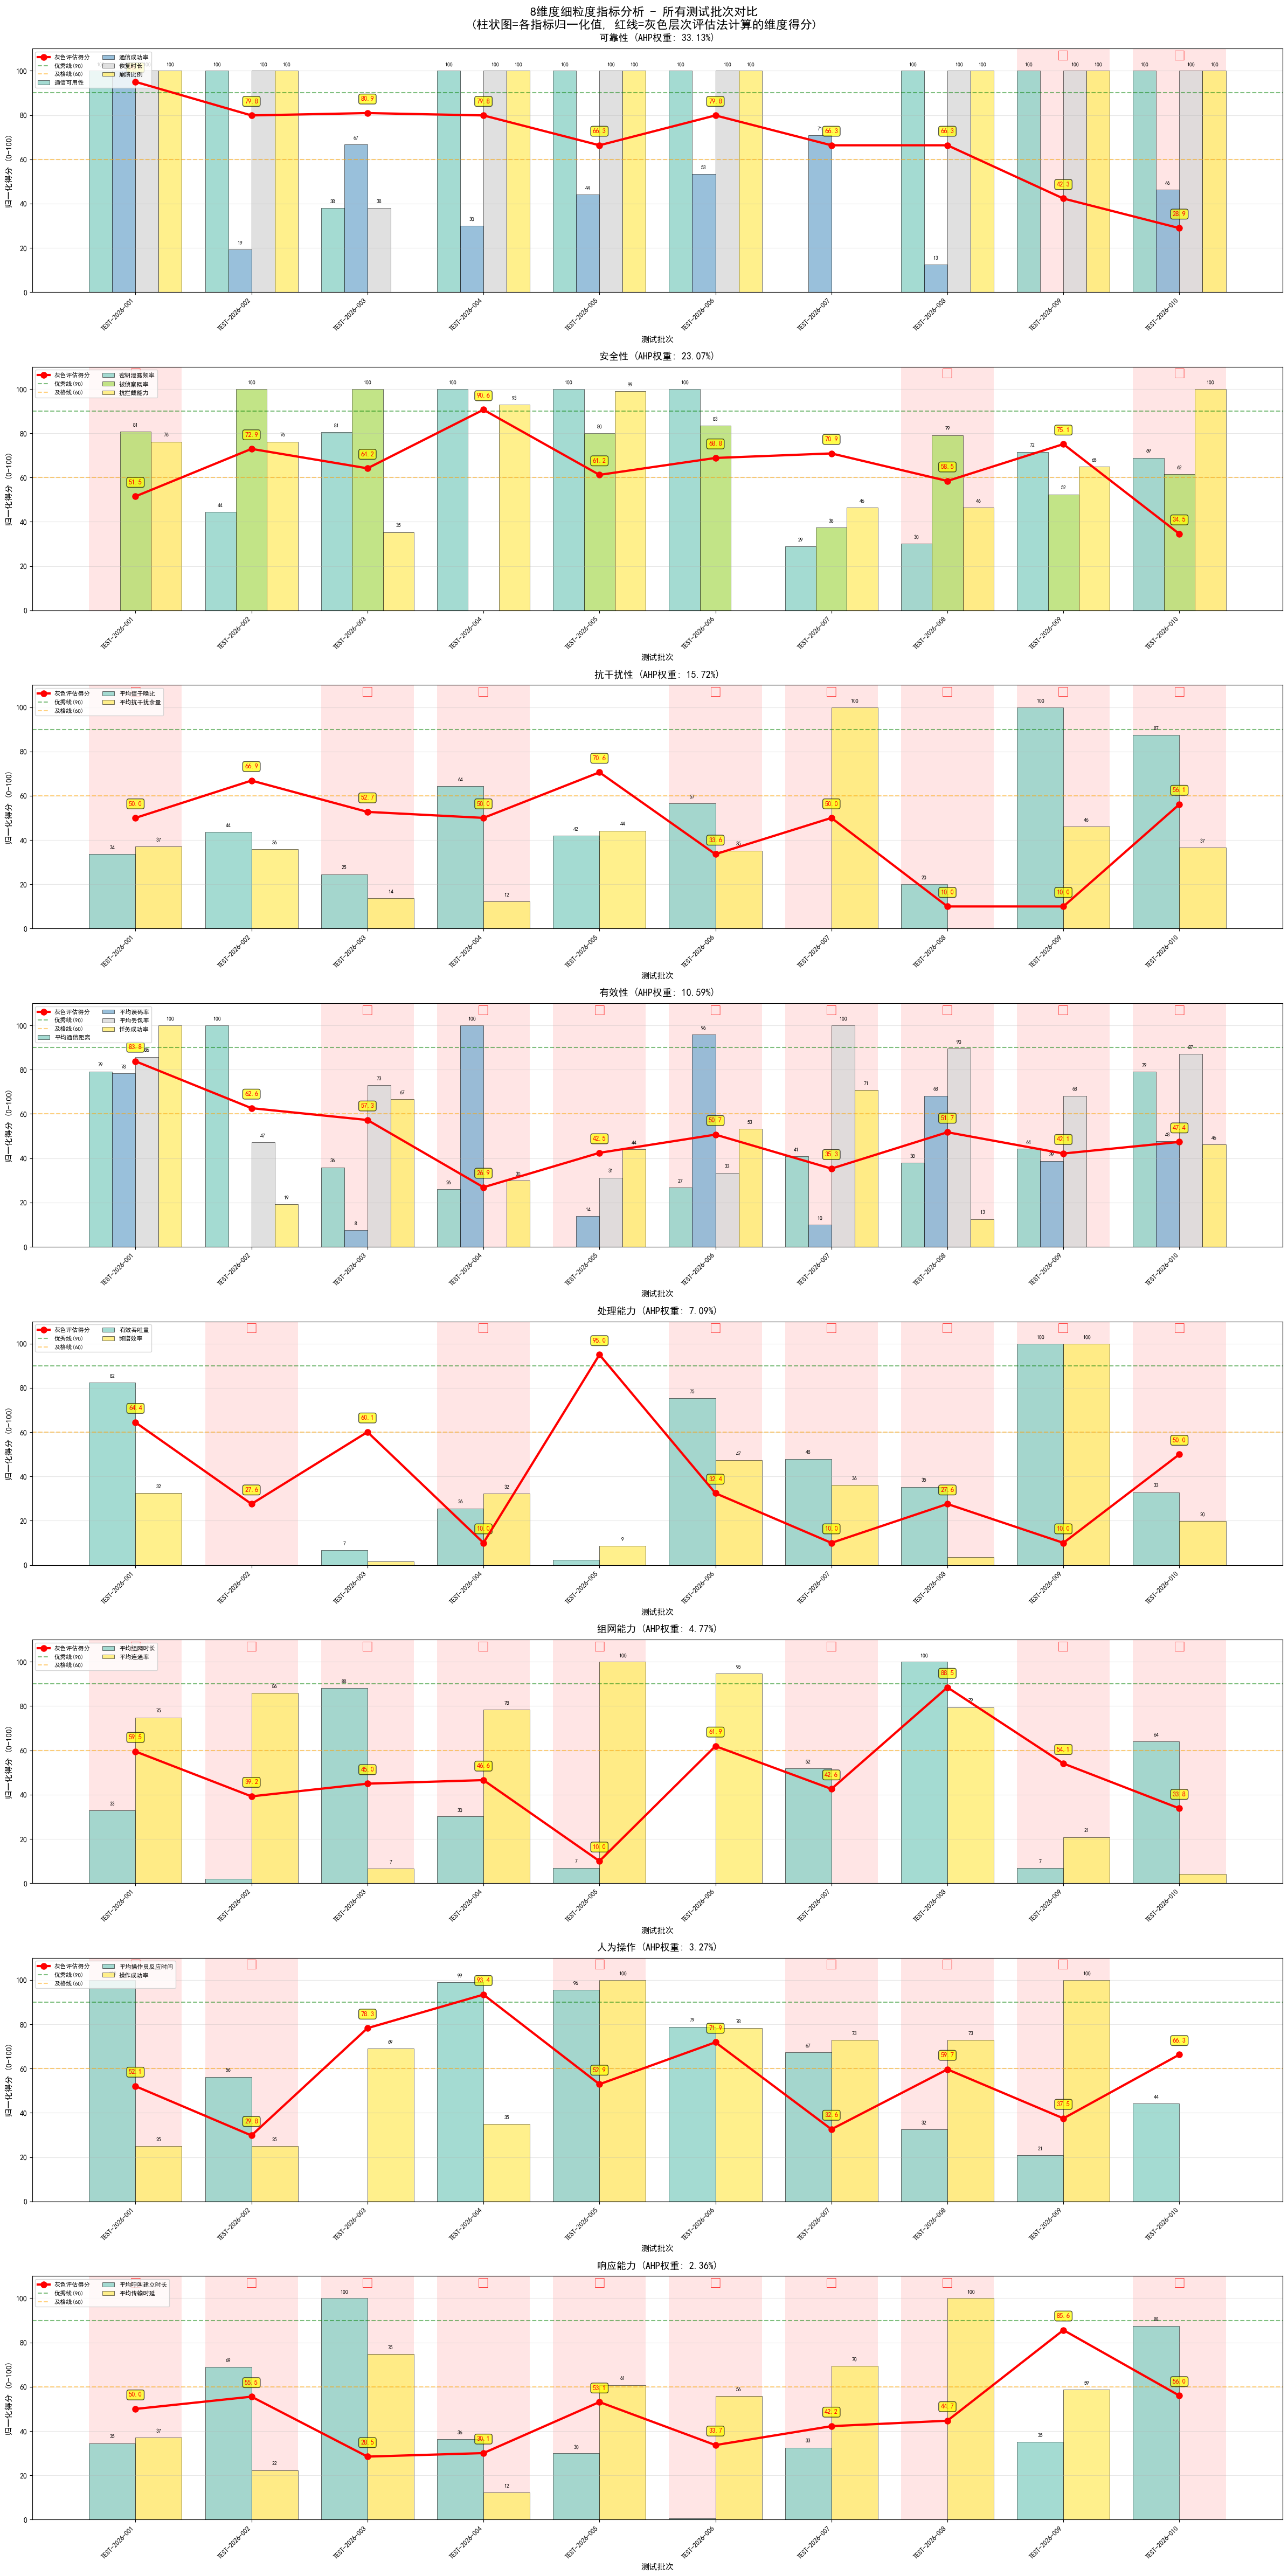


全部评估流程完成！

评估方法总结:
  ✓ 指标标准化: Min-Max归一化 (0-100分)
  ✓ 指标权重: 熵权法（客观权重）
  ✓ 维度权重: AHP层次分析法（主观权重）
  ✓ 评分方法: 灰色层次评估法（白化权函数 + 灰色评估系数）
  ✓ 灰类定义: 优秀[9,∞)、良好[0,7,10]、中等[0,5,8]、较差[0,1,5]



In [11]:
print("\n" + "="*80)
print("步骤9: 8维度细粒度指标可视化")
print("="*80)
print("绘制8个维度的细粒度指标对比图...")
print("说明: 使用灰色层次评估法计算的维度得分")
print()

from matplotlib.patches import Rectangle

# 创建8个子图（每行一个维度，显示更大）
fig = plt.figure(figsize=(24, 48))

# 使用前面定义的INDICATOR_SYSTEM和计算的criteria_weights
for idx, dim_code in enumerate(dim_codes_ordered, 1):
    dim_info = INDICATOR_SYSTEM[dim_code]
    dim_weight = criteria_weights[idx-1]  # 使用AHP计算的权重
    ax = plt.subplot(8, 1, idx)  # 8行1列，每行一个维度
    
    # 从INDICATOR_SYSTEM获取指标信息
    indicators = [ind['code'] for ind in dim_info['indicators']]
    labels = [ind['name'] for ind in dim_info['indicators']]
    n_indicators = len(indicators)
    n_tests = len(df_normalized)
    
    # 准备数据
    test_ids = df_normalized['test_id'].values
    dim_scores = df_scores[f'{dim_code}_score'].values  # 使用前面计算的维度得分
    
    # 设置柱状图参数
    x = np.arange(n_tests)
    width = 0.8 / n_indicators
    colors = plt.cm.Set3(np.linspace(0, 1, n_indicators))
    
    # 绘制分组柱状图
    for i, (indicator, label) in enumerate(zip(indicators, labels)):
        values = df_normalized[indicator].values
        offset = (i - n_indicators/2 + 0.5) * width
        bars = ax.bar(x + offset, values, width, label=label, 
                     color=colors[i], alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # 在柱子上标注数值（只标注大于5的值）
        for j, (bar, val) in enumerate(zip(bars, values)):
            if val > 5:
                ax.text(bar.get_x() + bar.get_width()/2, val + 2, 
                       f'{val:.0f}', ha='center', va='bottom', fontsize=7)
    
    # 添加维度得分线（灰色评估法计算的得分）
    ax.plot(x, dim_scores, 'r-o', linewidth=3, markersize=8, 
           label=f'灰色评估得分', zorder=10)
    
    # 在得分线上标注分数
    for i, (xi, score) in enumerate(zip(x, dim_scores)):
        ax.text(xi, score + 5, f'{score:.1f}', ha='center', va='bottom',
               fontsize=9, weight='bold', color='red',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # 添加参考线
    ax.axhline(y=90, color='green', linestyle='--', linewidth=1.5, alpha=0.5, label='优秀线(90)')
    ax.axhline(y=60, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='及格线(60)')
    
    # 设置坐标轴
    ax.set_xlabel('测试批次', fontsize=11, weight='bold')
    ax.set_ylabel('归一化得分 (0-100)', fontsize=11, weight='bold')
    ax.set_title(f'{dim_info["name"]} (AHP权重: {dim_weight*100:.2f}%)', 
                fontsize=13, weight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(test_ids, rotation=45, ha='right', fontsize=9)
    ax.set_ylim(0, 110)
    ax.legend(loc='upper left', fontsize=8, ncol=2)
    ax.grid(axis='y', alpha=0.3)
    
    # 高亮显示得分异常的测试（低于60分）
    for i, score in enumerate(dim_scores):
        if score < 60:
            # 添加红色背景标记
            rect = Rectangle((x[i]-0.4, 0), 0.8, 110, 
                           facecolor='red', alpha=0.1, zorder=0)
            ax.add_patch(rect)
            ax.text(x[i], 105, '⚠', ha='center', fontsize=16, color='red')

plt.suptitle('8维度细粒度指标分析 - 所有测试批次对比\n(柱状图=各指标归一化值, 红线=灰色层次评估法计算的维度得分)', 
            fontsize=16, weight='bold', y=0.995)
plt.tight_layout()

# 保存图片
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = f'8维度细粒度指标分析_{timestamp}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"✓ 图表已保存: {save_path}")

# 生成详细分析报告
print("\n" + "="*80)
print("【8维度细粒度分析报告】")
print("="*80)

for i, dim_code in enumerate(dim_codes_ordered):
    dim_info = INDICATOR_SYSTEM[dim_code]
    dim_weight = criteria_weights[i]  # 使用AHP计算的权重
    
    print(f"\n【{dim_info['name']}】AHP权重: {dim_weight*100:.2f}%")
    print("-"*80)
    
    # 获取该维度的数据
    dim_data = df_scores[['test_id', f'{dim_code}_score']].copy()
    
    # 添加细分指标
    for indicator in dim_info['indicators']:
        dim_data[indicator['code']] = df_normalized[indicator['code']]
    
    dim_data = dim_data.sort_values(f'{dim_code}_score', ascending=False)
    
    print("\n排名:")
    for rank, (idx, row) in enumerate(dim_data.iterrows(), 1):
        score = row[f'{dim_code}_score']
        test_id = row['test_id']
        
        if score >= 90:
            grade = "⭐⭐⭐⭐⭐ 优秀"
        elif score >= 70:
            grade = "⭐⭐⭐⭐ 良好"
        elif score >= 50:
            grade = "⭐⭐⭐ 中等"
        else:
            grade = "⚠ 较差"
        
        print(f"  {rank}. {test_id}: {score:.2f}分 {grade}")
        
        # 显示各指标得分
        indicator_scores = []
        for indicator in dim_info['indicators']:
            code = indicator['code']
            name = indicator['name']
            val = row[code]
            indicator_scores.append(f"{name}={val:.1f}")
        print(f"     细分: {', '.join(indicator_scores)}")
    
    # 分析异常值
    print("\n⚠ 需要关注的问题:")
    has_issues = False
    for idx, row in dim_data.iterrows():
        test_id = row['test_id']
        issues = []
        
        for indicator in dim_info['indicators']:
            code = indicator['code']
            name = indicator['name']
            val = row[code]
            if val < 40:
                issues.append(f"{name}过低({val:.1f})")
        
        if issues:
            print(f"  - {test_id}: {', '.join(issues)}")
            has_issues = True
    
    if not has_issues:
        print("  无明显问题 ✓")

print("\n" + "="*80)
print("可视化分析完成！")
print("="*80)
print("\n说明:")
print("  1. 柱状图显示各指标的归一化值（0-100分）")
print("  2. 红色折线显示灰色层次评估法计算的维度综合得分")
print("  3. 绿色虚线(90分)表示优秀线，橙色虚线(60分)表示及格线")
print("  4. 红色背景标记表示该测试批次在此维度得分不及格(<60分)")
print("  5. 黄色标签显示灰色评估得分，反映了不确定性的处理")
print()
print("💡 灰色评估法特点:")
print("  - 通过白化权函数处理指标的模糊性和不确定性")
print("  - 灰色评估权向量反映了各灰类（优秀/良好/中等/较差）的隶属度")
print("  - 综合得分 = 灰色评估权向量 · 灰类代表值")
print("  - 相比简单加权求和，更能反映评估的灰色特性")
print()

plt.show()

print("\n" + "="*80)
print("全部评估流程完成！")
print("="*80)
print("\n评估方法总结:")
print("  ✓ 指标标准化: Min-Max归一化 (0-100分)")
print("  ✓ 指标权重: 熵权法（客观权重）")
print("  ✓ 维度权重: AHP层次分析法（主观权重）")
print("  ✓ 评分方法: 灰色层次评估法（白化权函数 + 灰色评估系数）")
print("  ✓ 灰类定义: 优秀[9,∞)、良好[0,7,10]、中等[0,5,8]、较差[0,1,5]")
print()

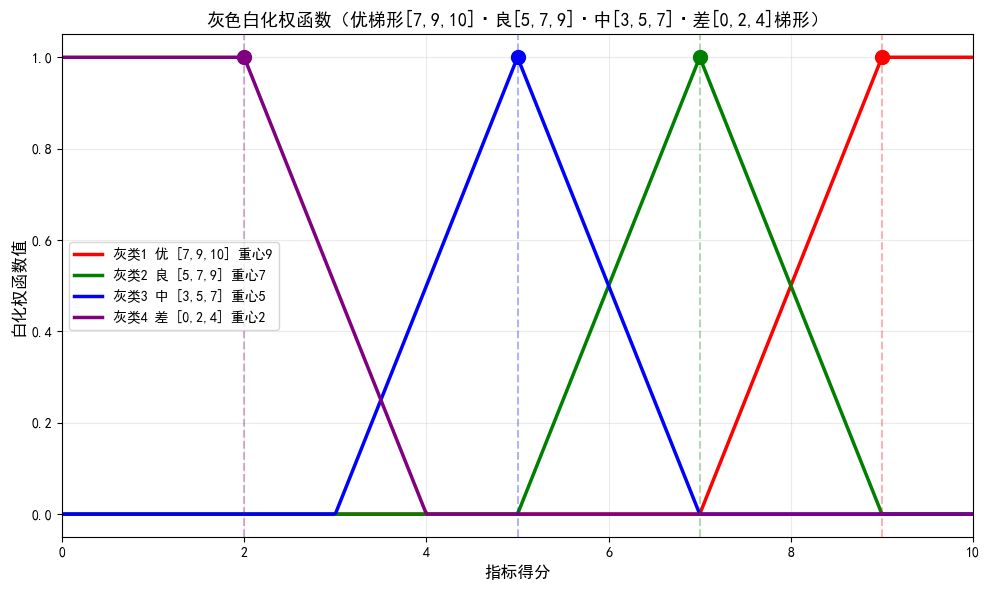

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

x = np.linspace(0, 10, 500)

def f4(x):
    return np.piecewise(x,
                        [x <= 2, (x > 2) & (x < 4), x >= 4],
                        [1, lambda x: (4 - x) / 2, 0])

def f3(x):
    return np.piecewise(x,
                        [(x > 3) & (x <= 5), (x > 5) & (x < 7), (x <= 3) | (x >= 7)],
                        [lambda x: (x - 3) / 2, lambda x: (7 - x) / 2, 0])

def f2(x):
    return np.piecewise(x,
                        [(x > 5) & (x <= 7), (x > 7) & (x < 9), (x <= 5) | (x >= 9)],
                        [lambda x: (x - 5) / 2, lambda x: (9 - x) / 2, 0])

def f1(x):
    return np.piecewise(x,
                        [(x > 7) & (x < 9), x >= 9, x <= 7],
                        [lambda x: (x - 7) / 2, 1, 0])

y1 = f1(x)
y2 = f2(x)
y3 = f3(x)
y4 = f4(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y1, 'r-', linewidth=2.5, label='灰类1 优 [7,9,10] 重心9')
plt.plot(x, y2, 'g-', linewidth=2.5, label='灰类2 良 [5,7,9] 重心7')
plt.plot(x, y3, 'b-', linewidth=2.5, label='灰类3 中 [3,5,7] 重心5')
plt.plot(x, y4, 'purple', linewidth=2.5, label='灰类4 差 [0,2,4] 重心2')

plt.scatter([9], [1], color='red', s=100, zorder=5)
plt.scatter([7], [1], color='green', s=100, zorder=5)
plt.scatter([5], [1], color='blue', s=100, zorder=5)
plt.scatter([2], [1], color='purple', s=100, zorder=5)

plt.axvline(9, color='red', linestyle='--', alpha=0.3)
plt.axvline(7, color='green', linestyle='--', alpha=0.3)
plt.axvline(5, color='blue', linestyle='--', alpha=0.3)
plt.axvline(2, color='purple', linestyle='--', alpha=0.3)

plt.title('灰色白化权函数（优梯形[7,9,10]·良[5,7,9]·中[3,5,7]·差[0,2,4]梯形）', fontsize=13)
plt.xlabel('指标得分', fontsize=12)
plt.ylabel('白化权函数值', fontsize=12)
plt.grid(alpha=0.25)
plt.legend(loc='best')
plt.ylim(-0.05, 1.05)
plt.xlim(0, 10)
plt.tight_layout()
plt.show()

端点梯形白化权函数（5灰类，调整后的端点）

端点定义：
--------------------------------------------------------------------------------
a_0 = -2
a_1 = 0
a_2 = 2
a_3 = 4
a_4 = 6
a_5 = 8
a_6 = 10
a_7 = 12
--------------------------------------------------------------------------------
灰类区间定义（按公式 [a_{k-1}, a_{k+2}]）：
--------------------------------------------------------------------------------
灰类1（劣）：[a_0, a_3] = [-2, 4]
灰类2（差）：[a_1, a_4] = [0, 6]
灰类3（中）：[a_2, a_5] = [2, 8]
灰类4（良）：[a_3, a_6] = [4, 10]
灰类5（优）：[a_4, a_7] = [6, 12]
--------------------------------------------------------------------------------

灰类参数详细计算：

灰类1（劣）：
  a_k = a_1 = 0
  a_2 = 2
  λ1 = (0 + 2)/2 = 1.0
  平台起点 c1 = (0 + 1.0)/2 = 0.50
  平台终点 d1 = (1.0 + 2)/2 = 1.50
  区间范围：[-2, 4]
  平台区域：[0.50, 1.50]

灰类2（差）：
  a_k = a_2 = 2
  a_3 = 4
  λ2 = (2 + 4)/2 = 3.0
  平台起点 c2 = (2 + 3.0)/2 = 2.50
  平台终点 d2 = (3.0 + 4)/2 = 3.50
  区间范围：[0, 6]
  平台区域：[2.50, 3.50]

灰类3（中）：
  a_k = a_3 = 4
  a_4 = 6
  λ3 = (4 + 6)/2 = 5.0
  平台起点 c3 = (4 + 5.0)/2 = 4.50
 

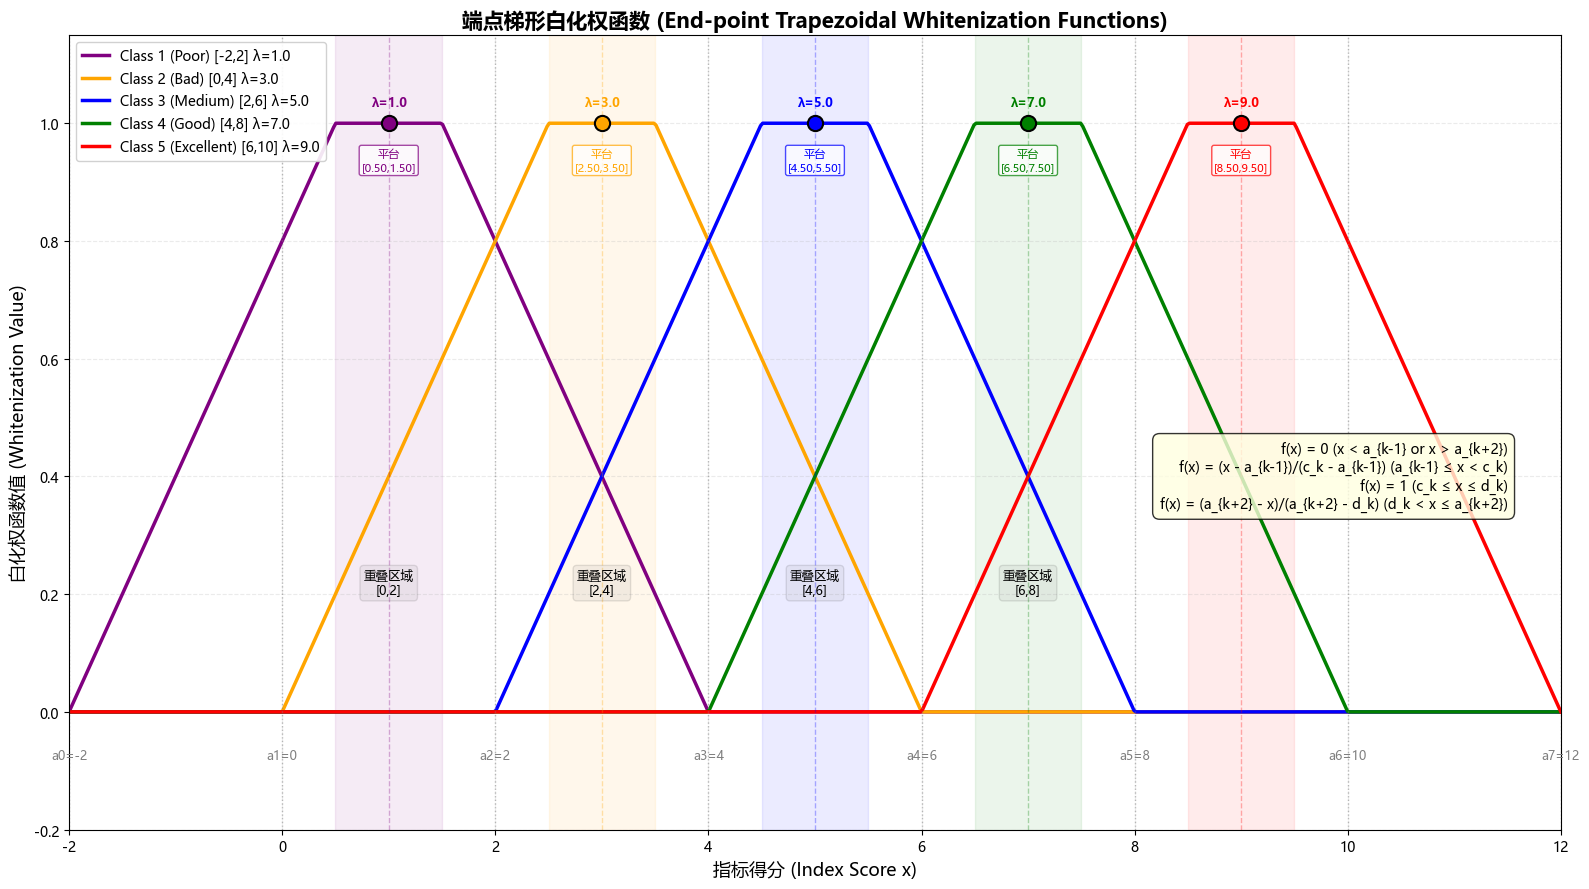


白化权函数值测试 (归一化结果):
x      Poor       Bad        Medium     Good       Excellent  AuxScore  
--------------------------------------------------------------------------------
-1.0   1.000      0.000      0.000      0.000      0.000      1.00      
0.0    1.000      0.000      0.000      0.000      0.000      1.00      
1.0    0.714      0.286      0.000      0.000      0.000      1.57      
2.0    0.500      0.500      0.000      0.000      0.000      2.00      
3.0    0.222      0.556      0.222      0.000      0.000      3.00      
4.0    0.000      0.500      0.500      0.000      0.000      4.00      
5.0    0.000      0.222      0.556      0.222      0.000      5.00      
6.0    0.000      0.000      0.500      0.500      0.000      6.00      
7.0    0.000      0.000      0.222      0.556      0.222      7.00      
8.0    0.000      0.000      0.000      0.500      0.500      8.00      
9.0    0.000      0.000      0.000      0.286      0.714      8.43      
10.0   0.000      0.000 

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字体 - 使用系统默认支持中文的字体
import platform
system = platform.system()

if system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
elif system == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti SC', 'Apple Color Emoji']
else:  # Linux
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC']
    
plt.rcParams['axes.unicode_minus'] = False

print("="*80)
print("端点梯形白化权函数（5灰类，调整后的端点）")
print("="*80)

# 端点定义
a = {
    0: -2,   # 左延拓
    1: 0,    # 第1个端点
    2: 2,    # 第2个端点
    3: 4,    # 第3个端点
    4: 6,    # 第4个端点
    5: 8,    # 第5个端点
    6: 10,   # 第6个端点
    7: 12    # 右延拓
}

print("\n端点定义：")
print("-"*80)
for i in range(8):
    print(f"a_{i} = {a[i]}")
print("-"*80)

# 灰类定义（从劣到优，k=1到5）
print("灰类区间定义（按公式 [a_{k-1}, a_{k+2}]）：")
print("-"*80)
grey_names = {1: "劣", 2: "差", 3: "中", 4: "良", 5: "优"}
for k in [1, 2, 3, 4, 5]:
    a_k_minus_1 = a[k-1]
    a_k_plus_2 = a[k+2]
    print(f"灰类{k}（{grey_names[k]}）：[a_{k-1}, a_{k+2}] = [{a_k_minus_1}, {a_k_plus_2}]")
print("-"*80)

def calculate_grey_params(k):
    """计算灰类k的参数"""
    a_k = a[k]
    a_k_plus_1 = a[k+1]
    
    # λ_k = (a_k + a_{k+1}) / 2
    lambda_k = (a_k + a_k_plus_1) / 2
    
    # 平台起点：(a_k + λ_k) / 2
    c_k = (a_k + lambda_k) / 2
    
    # 平台终点：(λ_k + a_{k+1}) / 2
    d_k = (lambda_k + a_k_plus_1) / 2
    
    # 区间边界
    a_k_minus_1 = a[k-1]
    a_k_plus_2 = a[k+2]
    
    return {
        'a_k': a_k,
        'a_k_plus_1': a_k_plus_1,
        'lambda_k': lambda_k,
        'c_k': c_k,
        'd_k': d_k,
        'a_k_minus_1': a_k_minus_1,
        'a_k_plus_2': a_k_plus_2
    }

def whitening_function_k(x, k):
    """通用的第k个灰类白化权函数"""
    params = calculate_grey_params(k)
    
    a_k_minus_1 = params['a_k_minus_1']
    c_k = params['c_k']
    d_k = params['d_k']
    a_k_plus_2 = params['a_k_plus_2']
    
    if x < a_k_minus_1 or x > a_k_plus_2:
        return 0
    elif a_k_minus_1 <= x < c_k:
        return (x - a_k_minus_1) / (c_k - a_k_minus_1)
    elif c_k <= x <= d_k:
        return 1
    elif d_k < x <= a_k_plus_2:
        return (a_k_plus_2 - x) / (a_k_plus_2 - d_k)
    else:
        return 0

# 创建5个白化权函数
def whitening_function_1(x):
    return whitening_function_k(x, 1)

def whitening_function_2(x):
    return whitening_function_k(x, 2)

def whitening_function_3(x):
    return whitening_function_k(x, 3)

def whitening_function_4(x):
    return whitening_function_k(x, 4)

def whitening_function_5(x):
    return whitening_function_k(x, 5)

WHITENING_FUNCTIONS = [
    whitening_function_1,
    whitening_function_2,
    whitening_function_3,
    whitening_function_4,
    whitening_function_5
]

# 计算灰类代表值
GREY_CLASS_VALUES = [
    calculate_grey_params(1)['lambda_k'],  # 劣
    calculate_grey_params(2)['lambda_k'],  # 差
    calculate_grey_params(3)['lambda_k'],  # 中
    calculate_grey_params(4)['lambda_k'],  # 良
    calculate_grey_params(5)['lambda_k'],  # 优
]

# 打印详细参数
print("\n灰类参数详细计算：")
print("="*80)
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    print(f"\n灰类{k}（{grey_names[k]}）：")
    print(f"  a_k = a_{k} = {params['a_k']}")
    print(f"  a_{k+1} = {params['a_k_plus_1']}")
    print(f"  λ{k} = ({params['a_k']} + {params['a_k_plus_1']})/2 = {params['lambda_k']:.1f}")
    print(f"  平台起点 c{k} = ({params['a_k']} + {params['lambda_k']:.1f})/2 = {params['c_k']:.2f}")
    print(f"  平台终点 d{k} = ({params['lambda_k']:.1f} + {params['a_k_plus_1']})/2 = {params['d_k']:.2f}")
    print(f"  区间范围：[{params['a_k_minus_1']}, {params['a_k_plus_2']}]")
    print(f"  平台区域：[{params['c_k']:.2f}, {params['d_k']:.2f}]")

print("\n" + "="*80)

print("\n灰类代表值（λ值）：")
print(f"  劣: λ1 = {GREY_CLASS_VALUES[0]:.1f}")
print(f"  差: λ2 = {GREY_CLASS_VALUES[1]:.1f}")
print(f"  中: λ3 = {GREY_CLASS_VALUES[2]:.1f}")
print(f"  良: λ4 = {GREY_CLASS_VALUES[3]:.1f}")
print(f"  优: λ5 = {GREY_CLASS_VALUES[4]:.1f}")
print("="*80)

# ==================== 绘图部分 - 完全避免使用Unicode下标 ====================
x = np.linspace(-2, 12, 700)
y1 = np.array([whitening_function_1(xi) for xi in x])
y2 = np.array([whitening_function_2(xi) for xi in x])
y3 = np.array([whitening_function_3(xi) for xi in x])
y4 = np.array([whitening_function_4(xi) for xi in x])
y5 = np.array([whitening_function_5(xi) for xi in x])

plt.figure(figsize=(16, 9))

# 颜色和名称定义
colors = ['purple', 'orange', 'blue', 'green', 'red']
class_names_en = ['Poor', 'Bad', 'Medium', 'Good', 'Excellent']
class_names_cn = ['劣', '差', '中', '良', '优']
lambda_values = [f'{v:.1f}' for v in GREY_CLASS_VALUES]

# 绘制函数曲线 - 使用普通文本，避免Unicode下标
plt.plot(x, y1, color=colors[0], linewidth=2.5, 
         label=f'Class 1 ({class_names_en[0]}) [-2,2] λ={lambda_values[0]}')
plt.plot(x, y2, color=colors[1], linewidth=2.5, 
         label=f'Class 2 ({class_names_en[1]}) [0,4] λ={lambda_values[1]}')
plt.plot(x, y3, color=colors[2], linewidth=2.5, 
         label=f'Class 3 ({class_names_en[2]}) [2,6] λ={lambda_values[2]}')
plt.plot(x, y4, color=colors[3], linewidth=2.5, 
         label=f'Class 4 ({class_names_en[3]}) [4,8] λ={lambda_values[3]}')
plt.plot(x, y5, color=colors[4], linewidth=2.5, 
         label=f'Class 5 ({class_names_en[4]}) [6,10] λ={lambda_values[4]}')

# 标注端点
for i in range(8):
    plt.axvline(a[i], color='gray', linestyle=':', alpha=0.5, linewidth=1)
    plt.text(a[i], -0.08, f'a{i}={a[i]}', ha='center', fontsize=9, color='gray')

# 标注中心点和平台
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    color = colors[k-1]
    
    # 标注λ_k - 使用普通文本
    plt.scatter([params['lambda_k']], [1], color=color, s=120, zorder=5, 
                marker='o', edgecolors='black', linewidths=1.5)
    plt.axvline(params['lambda_k'], color=color, linestyle='--', alpha=0.3, linewidth=1)
    
    # 添加λ标注
    plt.text(params['lambda_k'], 1.03, f'λ={params["lambda_k"]:.1f}', 
             ha='center', fontsize=9, fontweight='bold', color=color)
    
    # 标注平台区域
    plt.axvspan(params['c_k'], params['d_k'], alpha=0.08, color=color)
    
    # 添加平台区域标注
    platform_center = (params['c_k'] + params['d_k']) / 2
    plt.text(platform_center, 0.92, f'平台\n[{params["c_k"]:.2f},{params["d_k"]:.2f}]', 
             ha='center', fontsize=8, color=color, 
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, edgecolor=color))

plt.title('端点梯形白化权函数 (End-point Trapezoidal Whitenization Functions)', fontsize=15, fontweight='bold')
plt.xlabel('指标得分 (Index Score x)', fontsize=13)
plt.ylabel('白化权函数值 (Whitenization Value)', fontsize=13)
plt.grid(alpha=0.25, linestyle='--')
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.ylim(-0.2, 1.15)
plt.xlim(-2, 12)

# 添加函数公式说明
formula_text = 'f(x) = 0 (x < a_{k-1} or x > a_{k+2})\n' \
               'f(x) = (x - a_{k-1})/(c_k - a_{k-1}) (a_{k-1} ≤ x < c_k)\n' \
               'f(x) = 1 (c_k ≤ x ≤ d_k)\n' \
               'f(x) = (a_{k+2} - x)/(a_{k+2} - d_k) (d_k < x ≤ a_{k+2})'
plt.text(11.5, 0.4, formula_text, fontsize=10, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8),
         verticalalignment='center', horizontalalignment='right')

# 添加重叠区域说明
plt.text(1, 0.2, '重叠区域\n[0,2]', ha='center', fontsize=9, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.1))
plt.text(3, 0.2, '重叠区域\n[2,4]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.1))
plt.text(5, 0.2, '重叠区域\n[4,6]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.1))
plt.text(7, 0.2, '重叠区域\n[6,8]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.1))

plt.tight_layout()
plt.show()

# ==================== 测试验证 ====================
print("\n白化权函数值测试 (归一化结果):")
print("="*80)
test_values = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(f"{'x':<6} {'Poor':<10} {'Bad':<10} {'Medium':<10} {'Good':<10} {'Excellent':<10} {'AuxScore':<10}")
print("-"*80)

for val in test_values:
    f_values = [f(val) for f in WHITENING_FUNCTIONS]
    total = sum(f_values)
    
    if total > 0:
        f_norm = [f / total for f in f_values]
    else:
        f_norm = [0.2] * 5
    
    aux_score = sum(f_norm[i] * GREY_CLASS_VALUES[i] for i in range(5))
    
    print(f"{val:<6.1f} {f_norm[0]:<10.3f} {f_norm[1]:<10.3f} {f_norm[2]:<10.3f} "
          f"{f_norm[3]:<10.3f} {f_norm[4]:<10.3f} {aux_score:<10.2f}")

print("="*80)

# ==================== 汇总表格 ====================
print("\n灰类参数汇总表:")
print("="*100)
print(f"{'灰类':<6} {'Class':<10} {'k':<4} {'区间':<14} {'a_k':<6} {'a_{k+1}':<8} {'λ值':<6} {'平台区域':<16} {'上升段长':<8} {'下降段长':<8}")
print("-"*100)
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    interval = f"[{params['a_k_minus_1']},{params['a_k_plus_2']}]"
    platform = f"[{params['c_k']:.2f},{params['d_k']:.2f}]"
    class_name_en = class_names_en[k-1]
    
    # 计算上升段和下降段长度
    rise_length = params['c_k'] - params['a_k_minus_1']
    fall_length = params['a_k_plus_2'] - params['d_k']
    
    print(f"{grey_names[k]:<6} {class_name_en:<10} {k:<4} {interval:<14} {params['a_k']:<6} "
          f"{params['a_k_plus_1']:<8} {params['lambda_k']:<6.1f} {platform:<16} {rise_length:<8.2f} {fall_length:<8.2f}")
print("="*100)

# ==================== 对称性验证 ====================
print("\n等腰梯形对称性验证:")
print("-"*100)
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    rise_length = params['c_k'] - params['a_k_minus_1']
    fall_length = params['a_k_plus_2'] - params['d_k']
    is_isosceles = abs(rise_length - fall_length) < 0.001
    
    print(f"灰类{k} ({grey_names[k]}): 上升段={rise_length:.2f}, 下降段={fall_length:.2f} - " + 
          f"{'✓ 等腰梯形' if is_isosceles else '✗ 非等腰'}")

# ==================== 重叠区域分析 ====================
print("\n" + "="*100)
print("重叠区域分析:")
print("-"*100)
overlaps = [
    ("劣与差 (Poor-Bad)", [0, 2]),
    ("差与中 (Bad-Medium)", [2, 4]),
    ("中与良 (Medium-Good)", [4, 6]),
    ("良与优 (Good-Excellent)", [6, 8]),
]
for name, region in overlaps:
    print(f"{name}: {region}")
print("="*100)

print("\n✅ 程序执行完成！")
print("📊 图形已显示，所有λ值使用普通文本格式，确保清晰显示")

端点三角形白化权函数（5灰类，调整后的端点）- 无平台区域对比版本

端点定义：
--------------------------------------------------------------------------------
a_0 = -2
a_1 = 0
a_2 = 2
a_3 = 4
a_4 = 6
a_5 = 8
a_6 = 10
a_7 = 12
--------------------------------------------------------------------------------
灰类区间定义（按公式 [a_{k-1}, a_{k+2}]）：
--------------------------------------------------------------------------------
灰类1（劣）：[a_0, a_3] = [-2, 4]
灰类2（差）：[a_1, a_4] = [0, 6]
灰类3（中）：[a_2, a_5] = [2, 8]
灰类4（良）：[a_3, a_6] = [4, 10]
灰类5（优）：[a_4, a_7] = [6, 12]
--------------------------------------------------------------------------------

灰类参数详细计算（三角形无平台）：

灰类1（劣）：
  a_k = a_1 = 0
  a_2 = 2
  λ1 = (0 + 2)/2 = 1.0
  区间范围：[-2, 4]
  顶点位置：x = 1.0, f(x) = 1
  上升段长度：3.00
  下降段长度：3.00

灰类2（差）：
  a_k = a_2 = 2
  a_3 = 4
  λ2 = (2 + 4)/2 = 3.0
  区间范围：[0, 6]
  顶点位置：x = 3.0, f(x) = 1
  上升段长度：3.00
  下降段长度：3.00

灰类3（中）：
  a_k = a_3 = 4
  a_4 = 6
  λ3 = (4 + 6)/2 = 5.0
  区间范围：[2, 8]
  顶点位置：x = 5.0, f(x) = 1
  上升段长度：3.00
  下降段长度：3.00

灰类4（良）：


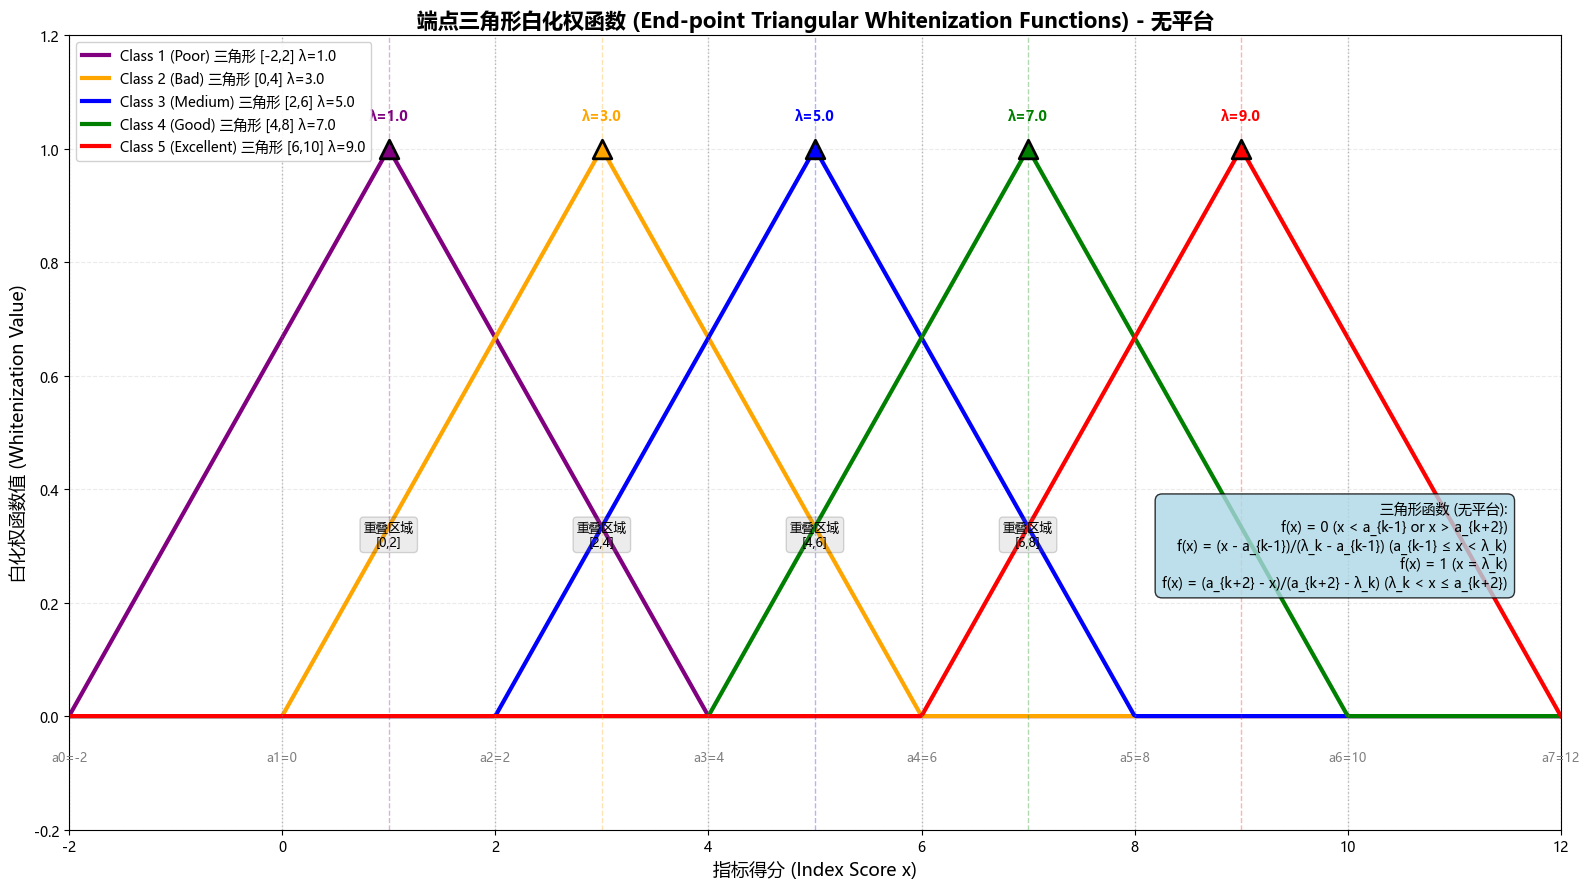

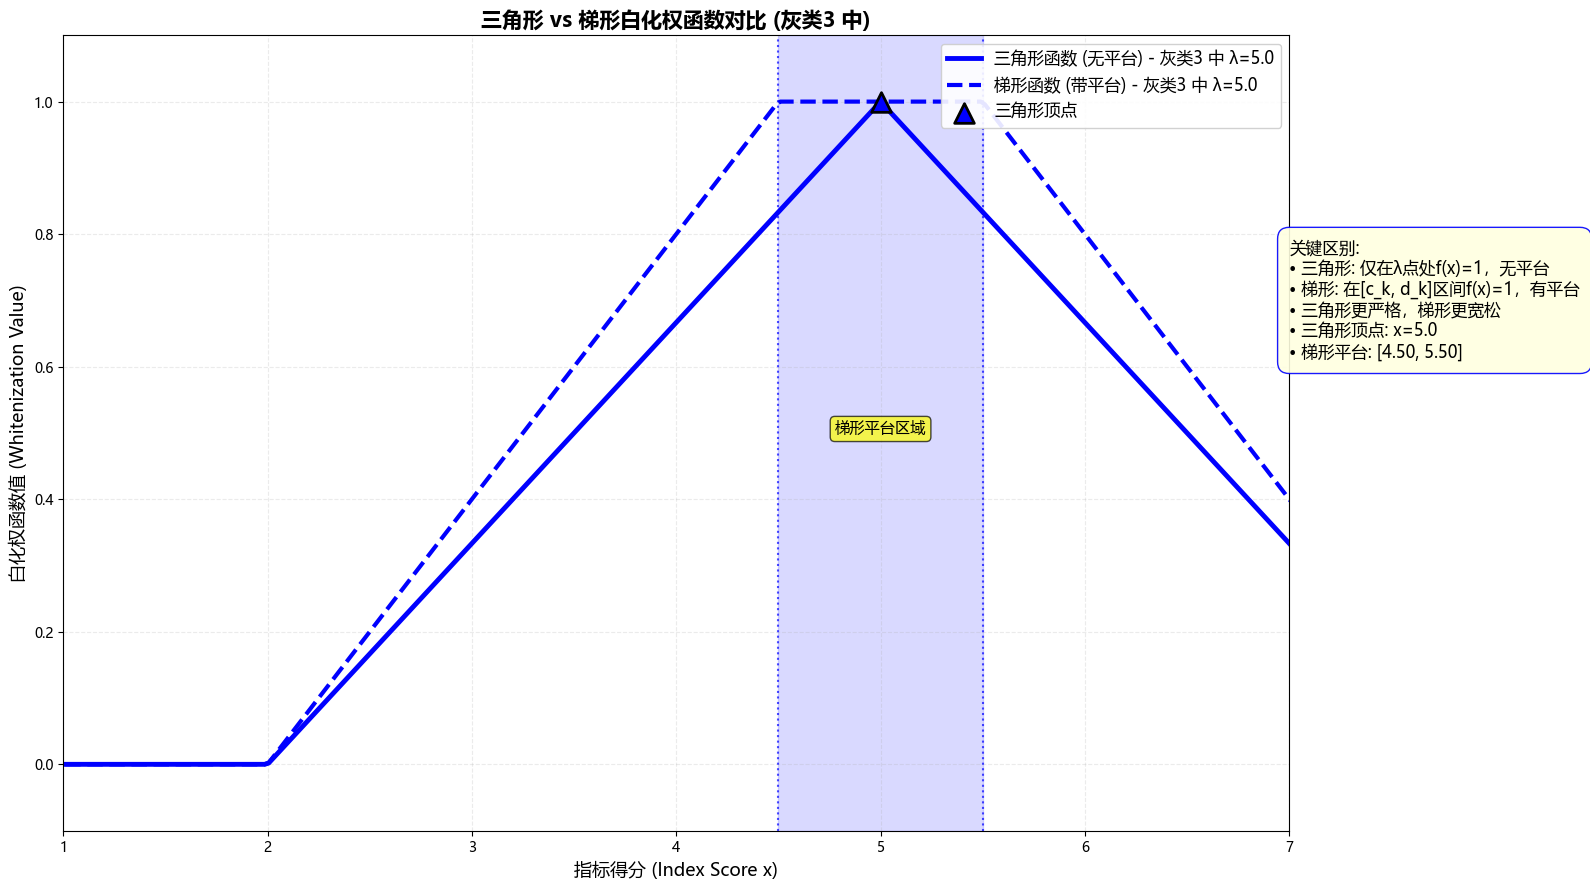

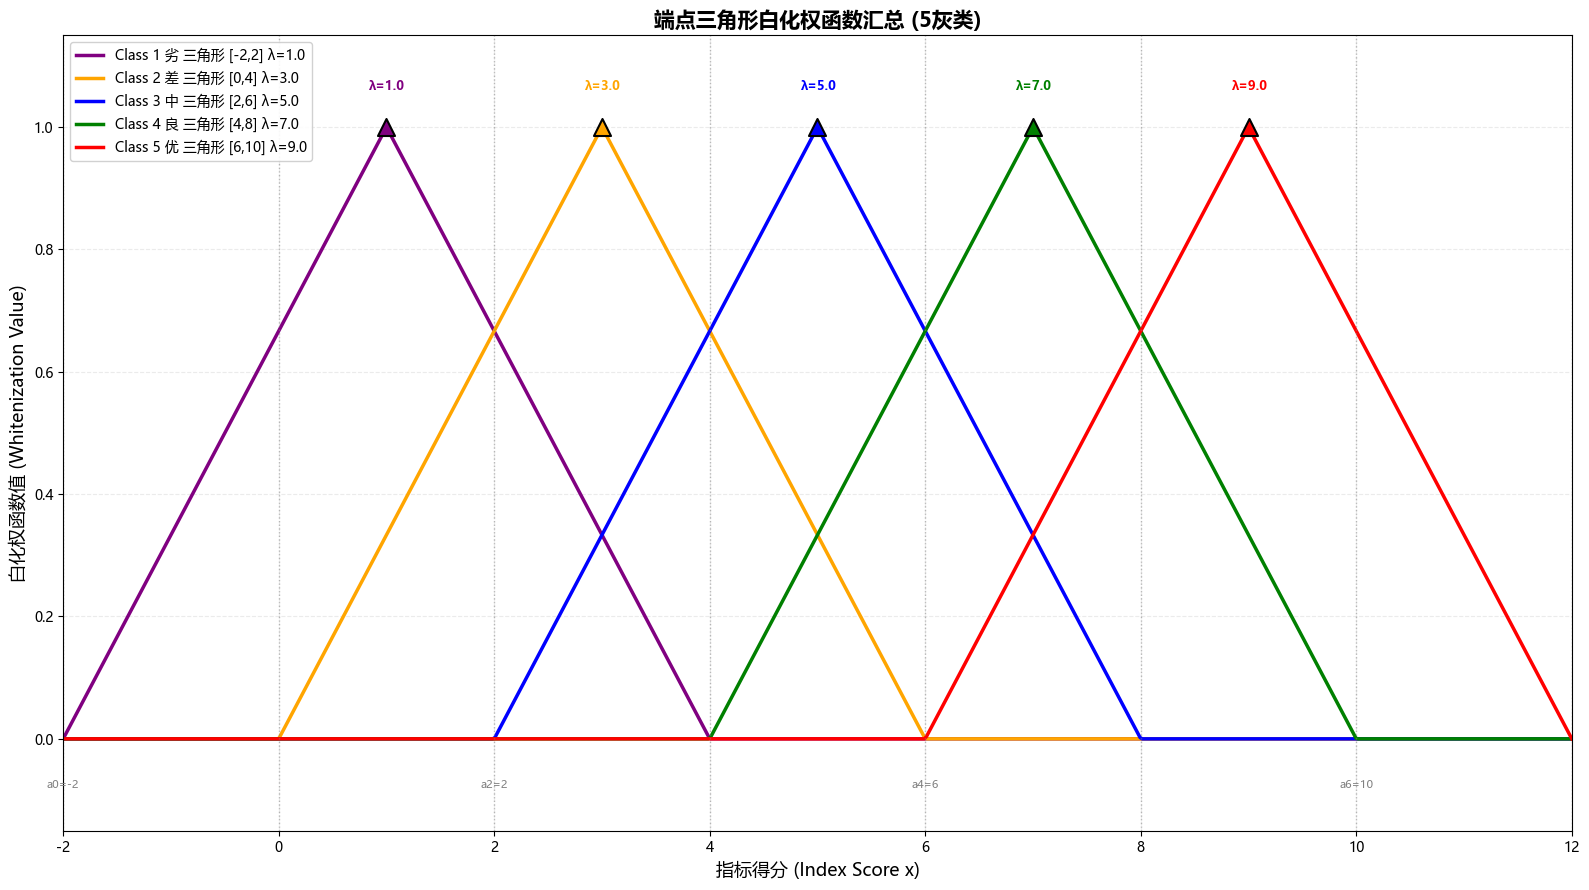


三角形白化权函数值测试 (无平台) - 归一化结果:
x      Poor       Bad        Medium     Good       Excellent  AuxScore  
--------------------------------------------------------------------------------
-1.0   1.000      0.000      0.000      0.000      0.000      1.00      
0.0    1.000      0.000      0.000      0.000      0.000      1.00      
1.0    0.750      0.250      0.000      0.000      0.000      1.50      
2.0    0.500      0.500      0.000      0.000      0.000      2.00      
3.0    0.200      0.600      0.200      0.000      0.000      3.00      
4.0    0.000      0.500      0.500      0.000      0.000      4.00      
5.0    0.000      0.200      0.600      0.200      0.000      5.00      
6.0    0.000      0.000      0.500      0.500      0.000      6.00      
7.0    0.000      0.000      0.200      0.600      0.200      7.00      
8.0    0.000      0.000      0.000      0.500      0.500      8.00      
9.0    0.000      0.000      0.000      0.250      0.750      8.50      
10.0   0.000   

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 设置中文字体 - 使用系统默认支持中文的字体
import platform
system = platform.system()

if system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
elif system == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['PingFang SC', 'Heiti SC', 'Apple Color Emoji']
else:  # Linux
    plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC']
    
plt.rcParams['axes.unicode_minus'] = False

print("="*80)
print("端点三角形白化权函数（5灰类，调整后的端点）- 无平台区域对比版本")
print("="*80)

# 端点定义
a = {
    0: -2,   # 左延拓
    1: 0,    # 第1个端点
    2: 2,    # 第2个端点
    3: 4,    # 第3个端点
    4: 6,    # 第4个端点
    5: 8,    # 第5个端点
    6: 10,   # 第6个端点
    7: 12    # 右延拓
}

print("\n端点定义：")
print("-"*80)
for i in range(8):
    print(f"a_{i} = {a[i]}")
print("-"*80)

# 灰类定义（从劣到优，k=1到5）
print("灰类区间定义（按公式 [a_{k-1}, a_{k+2}]）：")
print("-"*80)
grey_names = {1: "劣", 2: "差", 3: "中", 4: "良", 5: "优"}
for k in [1, 2, 3, 4, 5]:
    a_k_minus_1 = a[k-1]
    a_k_plus_2 = a[k+2]
    print(f"灰类{k}（{grey_names[k]}）：[a_{k-1}, a_{k+2}] = [{a_k_minus_1}, {a_k_plus_2}]")
print("-"*80)

def calculate_grey_params(k):
    """计算灰类k的参数"""
    a_k = a[k]
    a_k_plus_1 = a[k+1]
    
    # λ_k = (a_k + a_{k+1}) / 2
    lambda_k = (a_k + a_k_plus_1) / 2
    
    # 区间边界
    a_k_minus_1 = a[k-1]
    a_k_plus_2 = a[k+2]
    
    return {
        'a_k': a_k,
        'a_k_plus_1': a_k_plus_1,
        'lambda_k': lambda_k,
        'a_k_minus_1': a_k_minus_1,
        'a_k_plus_2': a_k_plus_2
    }

def whitening_function_k_triangle(x, k):
    """
    通用的第k个灰类三角形白化权函数（无平台）
    左边界: a_{k-1}, 中心点: λ_k, 右边界: a_{k+2}
    """
    params = calculate_grey_params(k)
    
    a_k_minus_1 = params['a_k_minus_1']
    lambda_k = params['lambda_k']
    a_k_plus_2 = params['a_k_plus_2']
    
    if x < a_k_minus_1 or x > a_k_plus_2:
        return 0
    elif a_k_minus_1 <= x < lambda_k:
        # 上升段 - 到顶点
        return (x - a_k_minus_1) / (lambda_k - a_k_minus_1)
    elif x == lambda_k:
        return 1
    elif lambda_k < x <= a_k_plus_2:
        # 下降段 - 从顶点下降
        return (a_k_plus_2 - x) / (a_k_plus_2 - lambda_k)
    else:
        return 0

def whitening_function_k_trapezoid(x, k):
    """
    通用的第k个灰类梯形白化权函数（带平台）- 用于对比
    """
    params = calculate_grey_params(k)
    
    a_k = params['a_k']
    a_k_plus_1 = params['a_k_plus_1']
    a_k_minus_1 = params['a_k_minus_1']
    a_k_plus_2 = params['a_k_plus_2']
    lambda_k = params['lambda_k']
    
    # 平台起点
    c_k = (a_k + lambda_k) / 2
    # 平台终点
    d_k = (lambda_k + a_k_plus_1) / 2
    
    if x < a_k_minus_1 or x > a_k_plus_2:
        return 0
    elif a_k_minus_1 <= x < c_k:
        return (x - a_k_minus_1) / (c_k - a_k_minus_1)
    elif c_k <= x <= d_k:
        return 1
    elif d_k < x <= a_k_plus_2:
        return (a_k_plus_2 - x) / (a_k_plus_2 - d_k)
    else:
        return 0

# 创建5个三角形白化权函数（无平台）
def whitening_function_1_triangle(x):
    return whitening_function_k_triangle(x, 1)

def whitening_function_2_triangle(x):
    return whitening_function_k_triangle(x, 2)

def whitening_function_3_triangle(x):
    return whitening_function_k_triangle(x, 3)

def whitening_function_4_triangle(x):
    return whitening_function_k_triangle(x, 4)

def whitening_function_5_triangle(x):
    return whitening_function_k_triangle(x, 5)

# 创建5个梯形白化权函数（带平台）- 用于对比
def whitening_function_1_trapezoid(x):
    return whitening_function_k_trapezoid(x, 1)

def whitening_function_2_trapezoid(x):
    return whitening_function_k_trapezoid(x, 2)

def whitening_function_3_trapezoid(x):
    return whitening_function_k_trapezoid(x, 3)

def whitening_function_4_trapezoid(x):
    return whitening_function_k_trapezoid(x, 4)

def whitening_function_5_trapezoid(x):
    return whitening_function_k_trapezoid(x, 5)

WHITENING_FUNCTIONS_TRIANGLE = [
    whitening_function_1_triangle,
    whitening_function_2_triangle,
    whitening_function_3_triangle,
    whitening_function_4_triangle,
    whitening_function_5_triangle
]

WHITENING_FUNCTIONS_TRAPEZOID = [
    whitening_function_1_trapezoid,
    whitening_function_2_trapezoid,
    whitening_function_3_trapezoid,
    whitening_function_4_trapezoid,
    whitening_function_5_trapezoid
]

# 计算灰类代表值
GREY_CLASS_VALUES = [
    calculate_grey_params(1)['lambda_k'],  # 劣
    calculate_grey_params(2)['lambda_k'],  # 差
    calculate_grey_params(3)['lambda_k'],  # 中
    calculate_grey_params(4)['lambda_k'],  # 良
    calculate_grey_params(5)['lambda_k'],  # 优
]

# 打印详细参数
print("\n灰类参数详细计算（三角形无平台）：")
print("="*80)
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    print(f"\n灰类{k}（{grey_names[k]}）：")
    print(f"  a_k = a_{k} = {params['a_k']}")
    print(f"  a_{k+1} = {params['a_k_plus_1']}")
    print(f"  λ{k} = ({params['a_k']} + {params['a_k_plus_1']})/2 = {params['lambda_k']:.1f}")
    print(f"  区间范围：[{params['a_k_minus_1']}, {params['a_k_plus_2']}]")
    print(f"  顶点位置：x = {params['lambda_k']:.1f}, f(x) = 1")
    print(f"  上升段长度：{params['lambda_k'] - params['a_k_minus_1']:.2f}")
    print(f"  下降段长度：{params['a_k_plus_2'] - params['lambda_k']:.2f}")

print("\n" + "="*80)

print("\n灰类代表值（λ值）：")
print(f"  劣: λ1 = {GREY_CLASS_VALUES[0]:.1f}")
print(f"  差: λ2 = {GREY_CLASS_VALUES[1]:.1f}")
print(f"  中: λ3 = {GREY_CLASS_VALUES[2]:.1f}")
print(f"  良: λ4 = {GREY_CLASS_VALUES[3]:.1f}")
print(f"  优: λ5 = {GREY_CLASS_VALUES[4]:.1f}")
print("="*80)

# ==================== 绘图部分 ====================
x = np.linspace(-2, 12, 700)

# 三角形函数值
y1_triangle = np.array([whitening_function_1_triangle(xi) for xi in x])
y2_triangle = np.array([whitening_function_2_triangle(xi) for xi in x])
y3_triangle = np.array([whitening_function_3_triangle(xi) for xi in x])
y4_triangle = np.array([whitening_function_4_triangle(xi) for xi in x])
y5_triangle = np.array([whitening_function_5_triangle(xi) for xi in x])

# 梯形函数值 - 用于对比
y1_trapezoid = np.array([whitening_function_1_trapezoid(xi) for xi in x])
y2_trapezoid = np.array([whitening_function_2_trapezoid(xi) for xi in x])
y3_trapezoid = np.array([whitening_function_3_trapezoid(xi) for xi in x])
y4_trapezoid = np.array([whitening_function_4_trapezoid(xi) for xi in x])
y5_trapezoid = np.array([whitening_function_5_trapezoid(xi) for xi in x])

# 图1：三角形白化权函数（无平台）
plt.figure(figsize=(16, 9))

# 颜色和名称定义
colors = ['purple', 'orange', 'blue', 'green', 'red']
class_names_en = ['Poor', 'Bad', 'Medium', 'Good', 'Excellent']
class_names_cn = ['劣', '差', '中', '良', '优']
lambda_values = [f'{v:.1f}' for v in GREY_CLASS_VALUES]

# 绘制三角形函数曲线
plt.plot(x, y1_triangle, color=colors[0], linewidth=3, 
         label=f'Class 1 ({class_names_en[0]}) 三角形 [-2,2] λ={lambda_values[0]}')
plt.plot(x, y2_triangle, color=colors[1], linewidth=3, 
         label=f'Class 2 ({class_names_en[1]}) 三角形 [0,4] λ={lambda_values[1]}')
plt.plot(x, y3_triangle, color=colors[2], linewidth=3, 
         label=f'Class 3 ({class_names_en[2]}) 三角形 [2,6] λ={lambda_values[2]}')
plt.plot(x, y4_triangle, color=colors[3], linewidth=3, 
         label=f'Class 4 ({class_names_en[3]}) 三角形 [4,8] λ={lambda_values[3]}')
plt.plot(x, y5_triangle, color=colors[4], linewidth=3, 
         label=f'Class 5 ({class_names_en[4]}) 三角形 [6,10] λ={lambda_values[4]}')

# 标注端点
for i in range(8):
    plt.axvline(a[i], color='gray', linestyle=':', alpha=0.5, linewidth=1)
    plt.text(a[i], -0.08, f'a{i}={a[i]}', ha='center', fontsize=9, color='gray')

# 标注顶点
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    color = colors[k-1]
    
    # 标注顶点
    plt.scatter([params['lambda_k']], [1], color=color, s=180, zorder=5, 
                marker='^', edgecolors='black', linewidths=2)
    plt.axvline(params['lambda_k'], color=color, linestyle='--', alpha=0.3, linewidth=1)
    
    # 添加λ标注
    plt.text(params['lambda_k'], 1.05, f'λ={params["lambda_k"]:.1f}', 
             ha='center', fontsize=10, fontweight='bold', color=color)

plt.title('端点三角形白化权函数 (End-point Triangular Whitenization Functions) - 无平台', 
          fontsize=15, fontweight='bold')
plt.xlabel('指标得分 (Index Score x)', fontsize=13)
plt.ylabel('白化权函数值 (Whitenization Value)', fontsize=13)
plt.grid(alpha=0.25, linestyle='--')
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.ylim(-0.2, 1.2)
plt.xlim(-2, 12)

# 添加三角形函数公式说明
formula_text = '三角形函数 (无平台):\n' \
               'f(x) = 0 (x < a_{k-1} or x > a_{k+2})\n' \
               'f(x) = (x - a_{k-1})/(λ_k - a_{k-1}) (a_{k-1} ≤ x < λ_k)\n' \
               'f(x) = 1 (x = λ_k)\n' \
               'f(x) = (a_{k+2} - x)/(a_{k+2} - λ_k) (λ_k < x ≤ a_{k+2})'
plt.text(11.5, 0.3, formula_text, fontsize=10, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
         verticalalignment='center', horizontalalignment='right')

# 添加重叠区域说明
plt.text(1, 0.3, '重叠区域\n[0,2]', ha='center', fontsize=9, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))
plt.text(3, 0.3, '重叠区域\n[2,4]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))
plt.text(5, 0.3, '重叠区域\n[4,6]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))
plt.text(7, 0.3, '重叠区域\n[6,8]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))

plt.tight_layout()
plt.show()

# 图2：三角形 vs 梯形 对比图（仅展示灰类3（中）作为对比示例）
plt.figure(figsize=(16, 9))

# 绘制三角形（无平台）- 实线
plt.plot(x, y3_triangle, 'b-', linewidth=3.5, 
         label=f'三角形函数 (无平台) - 灰类3 中 λ={lambda_values[2]}')

# 绘制梯形（带平台）- 虚线
plt.plot(x, y3_trapezoid, 'b--', linewidth=3, 
         label=f'梯形函数 (带平台) - 灰类3 中 λ={lambda_values[2]}')

# 标注对比区域
params = calculate_grey_params(3)
c_k = (params['a_k'] + params['lambda_k']) / 2
d_k = (params['lambda_k'] + params['a_k_plus_1']) / 2

# 三角形顶点
plt.scatter([params['lambda_k']], [1], color='blue', s=200, zorder=5, 
            marker='^', edgecolors='black', linewidths=2, label='三角形顶点')

# 梯形平台区域
plt.axvline(c_k, color='blue', linestyle=':', alpha=0.7, linewidth=1.5)
plt.axvline(d_k, color='blue', linestyle=':', alpha=0.7, linewidth=1.5)
plt.axvspan(c_k, d_k, alpha=0.15, color='blue')
plt.text((c_k + d_k)/2, 0.5, '梯形平台区域', ha='center', fontsize=11, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# 添加对比说明
diff_text = '关键区别:\n' \
            '• 三角形: 仅在λ点处f(x)=1，无平台\n' \
            '• 梯形: 在[c_k, d_k]区间f(x)=1，有平台\n' \
            '• 三角形更严格，梯形更宽松\n' \
            f'• 三角形顶点: x={params["lambda_k"]:.1f}\n' \
            f'• 梯形平台: [{c_k:.2f}, {d_k:.2f}]'
plt.text(7, 0.7, diff_text, fontsize=12, 
         bbox=dict(boxstyle='round,pad=0.7', facecolor='lightyellow', alpha=0.9, edgecolor='blue'),
         verticalalignment='center')

plt.title('三角形 vs 梯形白化权函数对比 (灰类3 中)', fontsize=15, fontweight='bold')
plt.xlabel('指标得分 (Index Score x)', fontsize=13)
plt.ylabel('白化权函数值 (Whitenization Value)', fontsize=13)
plt.grid(alpha=0.25, linestyle='--')
plt.legend(loc='upper right', fontsize=12, framealpha=0.9)
plt.ylim(-0.1, 1.1)
plt.xlim(1, 7)
plt.tight_layout()
plt.show()

# 图3：所有灰类三角形函数（无平台）- 汇总图
plt.figure(figsize=(16, 9))

# 绘制所有三角形函数
plt.plot(x, y1_triangle, color=colors[0], linewidth=2.5, 
         label=f'Class 1 {class_names_cn[0]} 三角形 [-2,2] λ={lambda_values[0]}')
plt.plot(x, y2_triangle, color=colors[1], linewidth=2.5, 
         label=f'Class 2 {class_names_cn[1]} 三角形 [0,4] λ={lambda_values[1]}')
plt.plot(x, y3_triangle, color=colors[2], linewidth=2.5, 
         label=f'Class 3 {class_names_cn[2]} 三角形 [2,6] λ={lambda_values[2]}')
plt.plot(x, y4_triangle, color=colors[3], linewidth=2.5, 
         label=f'Class 4 {class_names_cn[3]} 三角形 [4,8] λ={lambda_values[3]}')
plt.plot(x, y5_triangle, color=colors[4], linewidth=2.5, 
         label=f'Class 5 {class_names_cn[4]} 三角形 [6,10] λ={lambda_values[4]}')

# 标注所有顶点
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    color = colors[k-1]
    plt.scatter([params['lambda_k']], [1], color=color, s=150, zorder=5, 
                marker='^', edgecolors='black', linewidths=1.5)
    plt.text(params['lambda_k'], 1.06, f'λ={params["lambda_k"]:.1f}', 
             ha='center', fontsize=9, fontweight='bold', color=color)

# 标注端点
for i in range(8):
    plt.axvline(a[i], color='gray', linestyle=':', alpha=0.5, linewidth=1)
    if i % 2 == 0:  # 隔一个标注一个，避免过于拥挤
        plt.text(a[i], -0.08, f'a{i}={a[i]}', ha='center', fontsize=8, color='gray')

plt.title('端点三角形白化权函数汇总 (5灰类)', fontsize=15, fontweight='bold')
plt.xlabel('指标得分 (Index Score x)', fontsize=13)
plt.ylabel('白化权函数值 (Whitenization Value)', fontsize=13)
plt.grid(alpha=0.25, linestyle='--')
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.ylim(-0.15, 1.15)
plt.xlim(-2, 12)
plt.tight_layout()
plt.show()

# ==================== 测试验证 ====================
print("\n" + "="*80)
print("三角形白化权函数值测试 (无平台) - 归一化结果:")
print("="*80)
test_values = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(f"{'x':<6} {'Poor':<10} {'Bad':<10} {'Medium':<10} {'Good':<10} {'Excellent':<10} {'AuxScore':<10}")
print("-"*80)

for val in test_values:
    f_values = [f(val) for f in WHITENING_FUNCTIONS_TRIANGLE]
    total = sum(f_values)
    
    if total > 0:
        f_norm = [f / total for f in f_values]
    else:
        f_norm = [0.2] * 5
    
    aux_score = sum(f_norm[i] * GREY_CLASS_VALUES[i] for i in range(5))
    
    print(f"{val:<6.1f} {f_norm[0]:<10.3f} {f_norm[1]:<10.3f} {f_norm[2]:<10.3f} "
          f"{f_norm[3]:<10.3f} {f_norm[4]:<10.3f} {aux_score:<10.2f}")

print("="*80)

# ==================== 汇总表格 ====================
print("\n三角形灰类参数汇总表 (无平台):")
print("="*100)
print(f"{'灰类':<6} {'Class':<10} {'k':<4} {'区间':<14} {'a_k':<6} {'a_{k+1}':<8} {'λ值':<6} {'顶点':<12} {'上升段长':<8} {'下降段长':<8}")
print("-"*100)
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    interval = f"[{params['a_k_minus_1']},{params['a_k_plus_2']}]"
    class_name_en = class_names_en[k-1]
    
    # 计算上升段和下降段长度
    rise_length = params['lambda_k'] - params['a_k_minus_1']
    fall_length = params['a_k_plus_2'] - params['lambda_k']
    
    print(f"{grey_names[k]:<6} {class_name_en:<10} {k:<4} {interval:<14} {params['a_k']:<6} "
          f"{params['a_k_plus_1']:<8} {params['lambda_k']:<6.1f} x={params['lambda_k']:<6.1f}  "
          f"{rise_length:<8.2f} {fall_length:<8.2f}")
print("="*100)

# ==================== 对称性验证 ====================
print("\n三角形对称性验证:")
print("-"*100)
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    rise_length = params['lambda_k'] - params['a_k_minus_1']
    fall_length = params['a_k_plus_2'] - params['lambda_k']
    is_symmetric = abs(rise_length - fall_length) < 0.001
    
    print(f"灰类{k} ({grey_names[k]}): 上升段={rise_length:.2f}, 下降段={fall_length:.2f} - " + 
          f"{'✓ 等腰三角形' if is_symmetric else '✗ 非等腰'}")

# ==================== 重叠区域分析 ====================
print("\n" + "="*100)
print("三角形函数重叠区域分析:")
print("-"*100)
overlaps = [
    ("劣与差 (Poor-Bad)", [0, 2]),
    ("差与中 (Bad-Medium)", [2, 4]),
    ("中与良 (Medium-Good)", [4, 6]),
    ("良与优 (Good-Excellent)", [6, 8]),
]

for name, region in overlaps:
    # 计算该区域内两个灰类的函数值比较
    print(f"{name}: 重叠区间 {region}")
    
    if region == [0, 2]:
        x_sample = 1.0
        f1 = whitening_function_1_triangle(x_sample)
        f2 = whitening_function_2_triangle(x_sample)
        print(f"  示例点 x={x_sample}: 劣={f1:.3f}, 差={f2:.3f}")
    elif region == [2, 4]:
        x_sample = 3.0
        f2 = whitening_function_2_triangle(x_sample)
        f3 = whitening_function_3_triangle(x_sample)
        print(f"  示例点 x={x_sample}: 差={f2:.3f}, 中={f3:.3f}")
    elif region == [4, 6]:
        x_sample = 5.0
        f3 = whitening_function_3_triangle(x_sample)
        f4 = whitening_function_4_triangle(x_sample)
        print(f"  示例点 x={x_sample}: 中={f3:.3f}, 良={f4:.3f}")
    elif region == [6, 8]:
        x_sample = 7.0
        f4 = whitening_function_4_triangle(x_sample)
        f5 = whitening_function_5_triangle(x_sample)
        print(f"  示例点 x={x_sample}: 良={f4:.3f}, 优={f5:.3f}")
print("="*100)

print("\n✅ 程序执行完成！")
print("📊 共生成3张对比图片:")
print("   1. 端点三角形白化权函数（无平台）- 所有5个灰类")
print("   2. 三角形 vs 梯形 对比图（灰类3 中）- 显示平台差异")
print("   3. 端点三角形白化权函数汇总（中文标注）")
print("\n🔺 三角形函数特点：仅在λ点处达到最大值1，无平台区域")
print("🔲 梯形函数特点：在[c_k, d_k]区间内保持最大值1，有平台区域")

In [22]:
# ============================================================================
# 第五部分：AHP层次分析法计算主观权重
# ============================================================================

步骤5: AHP层次分析法计算主观权重（α）
--------------------------------------------------------------------------------
5.1 准则层判断矩阵（8个维度）
    优先级: 可靠性 > 安全性 > 抗干扰性 > 有效性 > 处理能力 > 组网能力 > 人为操作 > 响应能力
    一致性比率 CR = 0.0292 ✓ (通过一致性检验)

    准则层权重:
      可靠性 (RL): 0.331325 (33.13%)
      安全性 (SC): 0.230660 (23.07%)
      抗干扰性 (AJ): 0.157235 (15.72%)
      有效性 (EF): 0.105903 (10.59%)
      处理能力 (PO): 0.070936 (7.09%)
      组网能力 (NC): 0.047681 (4.77%)
      人为操作 (HO): 0.032698 (3.27%)
      响应能力 (RS): 0.023562 (2.36%)

说明: 准则层（维度层）使用AHP主观权重
      因素层（指标层）使用熵权法客观权重（已在步骤4中计算）

5.2 定义灰色层次评估法的白化权函数
    采用端点三角形白化权函数（5灰类，无平台区域）
--------------------------------------------------------------------------------
    端点定义：a_0=-2, a_1=0, a_2=2, a_3=4, a_4=6, a_5=8, a_6=10, a_7=12
    灰类区间定义（按公式 [a_{k-1}, a_{k+2}]）：
      灰类1（劣）：[-2, 4]
      灰类2（差）：[0, 6]
      灰类3（中）：[2, 8]
      灰类4（良）：[4, 10]
      灰类5（优）：[6, 12]

✓ 白化权函数定义完成（三角形，无平台）
✓ 灰类代表值（λ值）: [1.0, 3.0, 5.0, 7.0, 9.0]

    灰类参数详细计算（三角形）：
      灰类1（劣）：λ_1=1.0, 顶点x

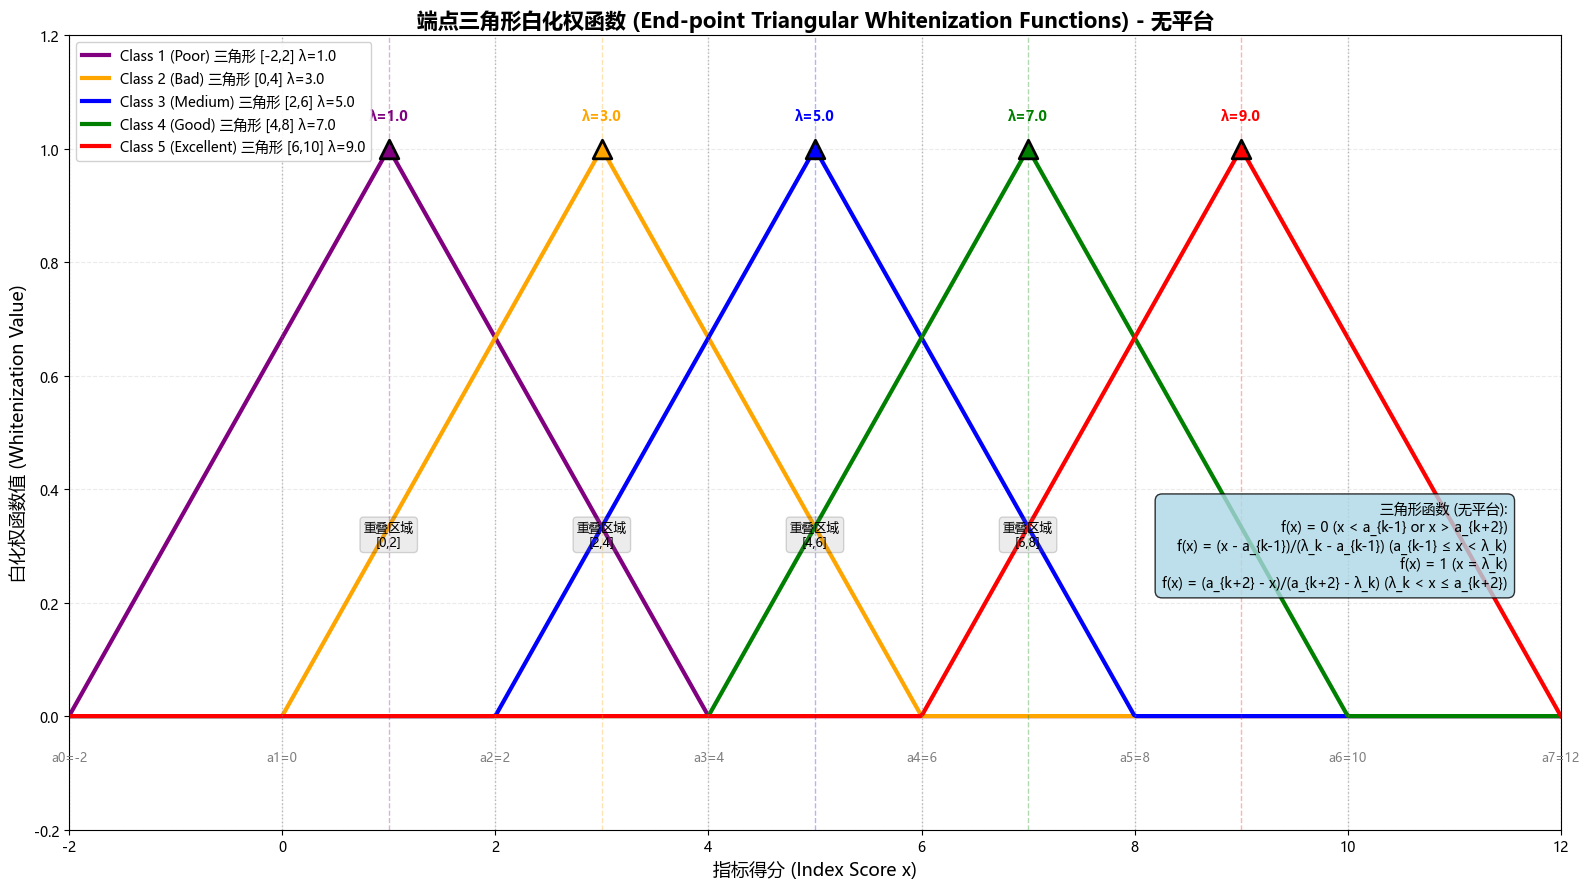

✓ 生成三角形 vs 梯形对比图...


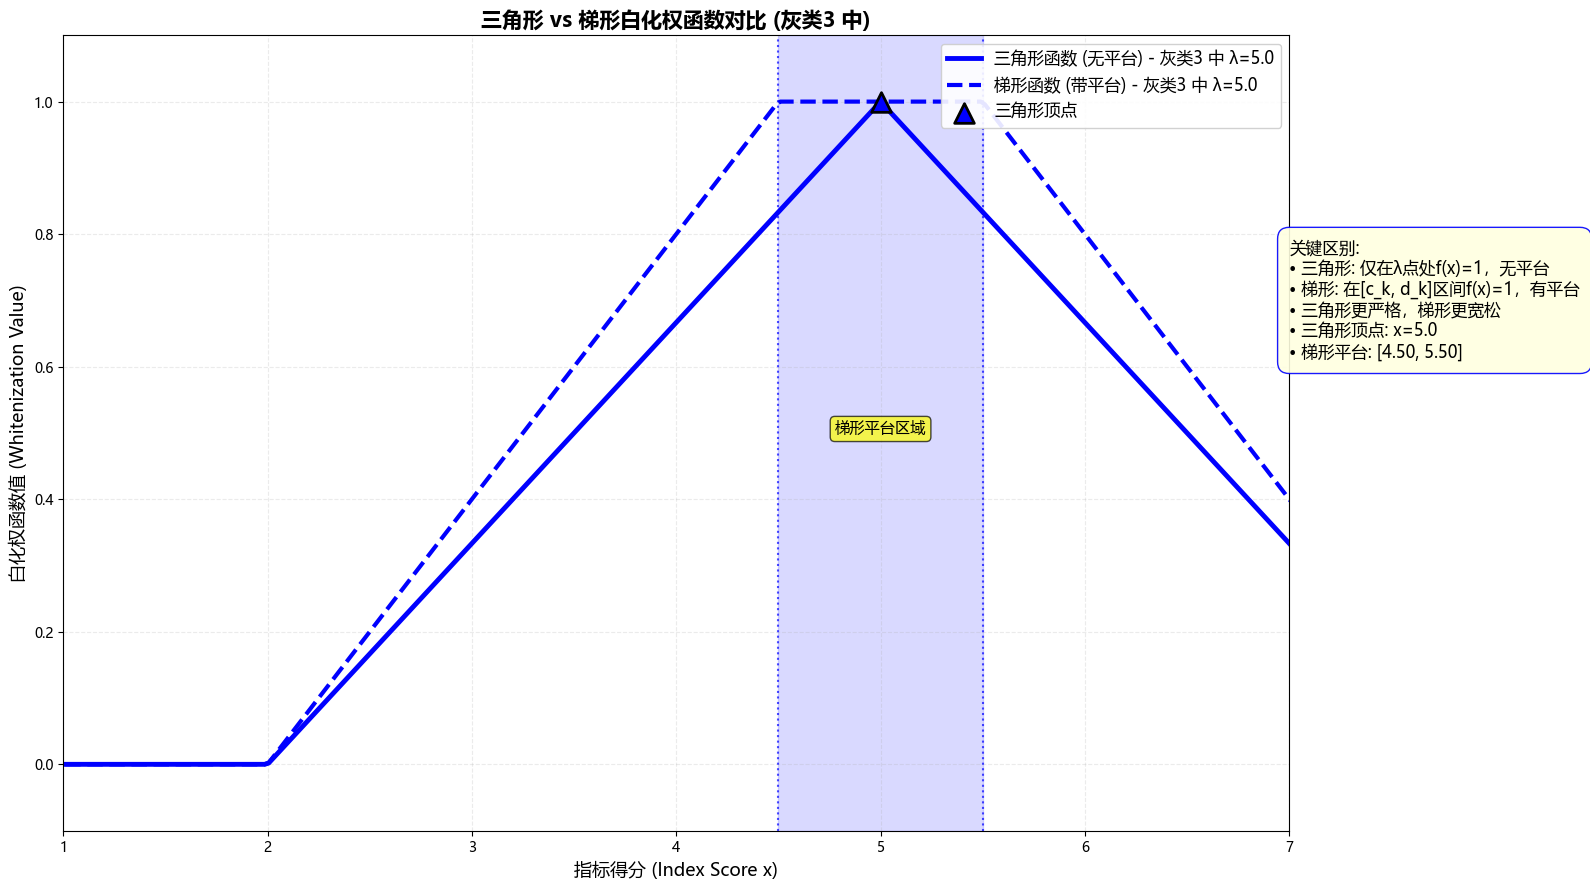


归一化白化权向量示例（各灰类权重之和=1）：
得分	劣	差	中	良	优	辅助得分(10分制)
1.0	0.750	0.250	0.000	0.000	0.000	1.50
3.0	0.200	0.600	0.200	0.000	0.000	3.00
5.0	0.000	0.200	0.600	0.200	0.000	5.00
7.0	0.000	0.000	0.200	0.600	0.200	7.00
9.0	0.000	0.000	0.000	0.250	0.750	8.50

说明: 辅助得分 = 灰色评估权向量 · [1.0, 3.0, 5.0, 7.0, 9.0]
      三角形函数特点：仅在λ点处达到最大值1，无平台区域



In [23]:
print("步骤5: AHP层次分析法计算主观权重（α）")
print("-"*80)

def ahp_calculate_weights(judgment_matrix):
    """
    AHP计算权重
    
    参数:
        judgment_matrix: 判断矩阵（numpy数组）
    
    返回:
        weights: 权重向量
        CR: 一致性比率
    """
    n = len(judgment_matrix)
    
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(judgment_matrix)
    
    # 找到最大特征值及其对应的特征向量
    max_eigenvalue_index = np.argmax(eigenvalues.real)
    max_eigenvalue = eigenvalues[max_eigenvalue_index].real
    max_eigenvector = eigenvectors[:, max_eigenvalue_index].real
    
    # 归一化得到权重
    weights = max_eigenvector / max_eigenvector.sum()
    
    # 一致性检验
    CI = (max_eigenvalue - n) / (n - 1)
    
    # RI值表（随机一致性指标）
    RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 
               8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_dict.get(n, 1.41)
    
    CR = CI / RI if RI != 0 else 0
    
    return weights, CR

# 5.1 准则层判断矩阵（8个维度）
# 优先级: RL > SC > AJ > EF > PO > NC > HO > RS
print("5.1 准则层判断矩阵（8个维度）")
print("    优先级: 可靠性 > 安全性 > 抗干扰性 > 有效性 > 处理能力 > 组网能力 > 人为操作 > 响应能力")

# 构建判断矩阵（按优先级排序）
# RL, SC, AJ, EF, PO, NC, HO, RS
criteria_matrix = np.array([
    [1,   2,   3,   4,   5,   6,   7,   8],    # RL 可靠性
    [1/2, 1,   2,   3,   4,   5,   6,   7],    # SC 安全性
    [1/3, 1/2, 1,   2,   3,   4,   5,   6],    # AJ 抗干扰性
    [1/4, 1/3, 1/2, 1,   2,   3,   4,   5],    # EF 有效性
    [1/5, 1/4, 1/3, 1/2, 1,   2,   3,   4],    # PO 处理能力
    [1/6, 1/5, 1/4, 1/3, 1/2, 1,   2,   3],    # NC 组网能力
    [1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1,   2],    # HO 人为操作
    [1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1]     # RS 响应能力
])

criteria_weights, criteria_CR = ahp_calculate_weights(criteria_matrix)

print(f"    一致性比率 CR = {criteria_CR:.4f}", end="")
if criteria_CR < 0.1:
    print(" ✓ (通过一致性检验)")
else:
    print(" ✗ (未通过一致性检验)")

# 维度代码（按优先级排序）
dim_codes_ordered = ['RL', 'SC', 'AJ', 'EF', 'PO', 'NC', 'HO', 'RS']

print("\n    准则层权重:")
for i, dim_code in enumerate(dim_codes_ordered):
    weight = criteria_weights[i]
    print(f"      {INDICATOR_SYSTEM[dim_code]['name']} ({dim_code}): {weight:.6f} ({weight*100:.2f}%)")

print()
print("说明: 准则层（维度层）使用AHP主观权重")
print("      因素层（指标层）使用熵权法客观权重（已在步骤4中计算）")
print()

# 5.2 定义灰色层次评估法的白化权函数（端点三角形白化权函数 - 无平台）
print("5.2 定义灰色层次评估法的白化权函数")
print("    采用端点三角形白化权函数（5灰类，无平台区域）")
print("-"*80)

# 端点定义
a = {
    0: -2,   # 左延拓
    1: 0,    # 第1个端点
    2: 2,    # 第2个端点
    3: 4,    # 第3个端点
    4: 6,    # 第4个端点
    5: 8,    # 第5个端点
    6: 10,   # 第6个端点
    7: 12    # 右延拓
}

print("    端点定义：a_0=-2, a_1=0, a_2=2, a_3=4, a_4=6, a_5=8, a_6=10, a_7=12")

# 灰类名称
grey_names = {1: "劣", 2: "差", 3: "中", 4: "良", 5: "优"}

print("    灰类区间定义（按公式 [a_{k-1}, a_{k+2}]）：")
for k in [1, 2, 3, 4, 5]:
    a_k_minus_1 = a[k-1]
    a_k_plus_2 = a[k+2]
    print(f"      灰类{k}（{grey_names[k]}）：[{a_k_minus_1}, {a_k_plus_2}]")
print()

def calculate_grey_params(k):
    """计算灰类k的参数"""
    a_k = a[k]
    a_k_plus_1 = a[k+1]
    
    # λ_k = (a_k + a_{k+1}) / 2
    lambda_k = (a_k + a_k_plus_1) / 2
    
    # 区间边界
    a_k_minus_1 = a[k-1]
    a_k_plus_2 = a[k+2]
    
    # 梯形平台参数（用于对比）
    c_k = (a_k + lambda_k) / 2
    d_k = (lambda_k + a_k_plus_1) / 2
    
    return {
        'a_k': a_k,
        'a_k_plus_1': a_k_plus_1,
        'lambda_k': lambda_k,
        'c_k': c_k,
        'd_k': d_k,
        'a_k_minus_1': a_k_minus_1,
        'a_k_plus_2': a_k_plus_2
    }

def whitening_function_k(x, k):
    """
    通用的第k个灰类三角形白化权函数（无平台）
    左边界: a_{k-1}, 顶点: λ_k, 右边界: a_{k+2}
    """
    params = calculate_grey_params(k)
    
    a_k_minus_1 = params['a_k_minus_1']
    lambda_k = params['lambda_k']
    a_k_plus_2 = params['a_k_plus_2']
    
    if x < a_k_minus_1 or x > a_k_plus_2:
        return 0
    elif a_k_minus_1 <= x < lambda_k:
        # 上升段 - 到顶点
        return (x - a_k_minus_1) / (lambda_k - a_k_minus_1)
    elif x == lambda_k:
        return 1
    elif lambda_k < x <= a_k_plus_2:
        # 下降段 - 从顶点下降
        return (a_k_plus_2 - x) / (a_k_plus_2 - lambda_k)
    else:
        return 0

def whitening_function_k_trapezoid(x, k):
    """
    梯形白化权函数（带平台）- 仅用于对比
    """
    params = calculate_grey_params(k)
    
    a_k_minus_1 = params['a_k_minus_1']
    c_k = params['c_k']
    d_k = params['d_k']
    a_k_plus_2 = params['a_k_plus_2']
    
    if x < a_k_minus_1 or x > a_k_plus_2:
        return 0
    elif a_k_minus_1 <= x < c_k:
        return (x - a_k_minus_1) / (c_k - a_k_minus_1)
    elif c_k <= x <= d_k:
        return 1
    elif d_k < x <= a_k_plus_2:
        return (a_k_plus_2 - x) / (a_k_plus_2 - d_k)
    else:
        return 0

# 创建5个三角形白化权函数（无平台）
def whitening_function_1(x):
    """灰类1（劣）- 三角形"""
    return whitening_function_k(x, 1)

def whitening_function_2(x):
    """灰类2（差）- 三角形"""
    return whitening_function_k(x, 2)

def whitening_function_3(x):
    """灰类3（中）- 三角形"""
    return whitening_function_k(x, 3)

def whitening_function_4(x):
    """灰类4（良）- 三角形"""
    return whitening_function_k(x, 4)

def whitening_function_5(x):
    """灰类5（优）- 三角形"""
    return whitening_function_k(x, 5)

# 创建5个梯形白化权函数（带平台）- 用于对比
def whitening_function_1_trapezoid(x):
    """灰类1（劣）- 梯形"""
    return whitening_function_k_trapezoid(x, 1)

def whitening_function_2_trapezoid(x):
    """灰类2（差）- 梯形"""
    return whitening_function_k_trapezoid(x, 2)

def whitening_function_3_trapezoid(x):
    """灰类3（中）- 梯形"""
    return whitening_function_k_trapezoid(x, 3)

def whitening_function_4_trapezoid(x):
    """灰类4（良）- 梯形"""
    return whitening_function_k_trapezoid(x, 4)

def whitening_function_5_trapezoid(x):
    """灰类5（优）- 梯形"""
    return whitening_function_k_trapezoid(x, 5)

WHITENING_FUNCTIONS = [
    whitening_function_1,
    whitening_function_2,
    whitening_function_3,
    whitening_function_4,
    whitening_function_5
]

WHITENING_FUNCTIONS_TRAPEZOID = [
    whitening_function_1_trapezoid,
    whitening_function_2_trapezoid,
    whitening_function_3_trapezoid,
    whitening_function_4_trapezoid,
    whitening_function_5_trapezoid
]

# 计算灰类代表值（使用λ_k）
GREY_CLASS_VALUES = [
    calculate_grey_params(1)['lambda_k'],  # 劣: 1.0
    calculate_grey_params(2)['lambda_k'],  # 差: 3.0
    calculate_grey_params(3)['lambda_k'],  # 中: 5.0
    calculate_grey_params(4)['lambda_k'],  # 良: 7.0
    calculate_grey_params(5)['lambda_k'],  # 优: 9.0
]

print("✓ 白化权函数定义完成（三角形，无平台）")
print(f"✓ 灰类代表值（λ值）: {GREY_CLASS_VALUES}")
print()

# 打印详细参数
print("    灰类参数详细计算（三角形）：")
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    print(f"      灰类{k}（{grey_names[k]}）：λ_{k}={params['lambda_k']:.1f}, 顶点x={params['lambda_k']:.1f}")
print()

# 绘制白化权函数图形
print("绘制白化权函数图形...")
print("-"*80)

x_plot = np.linspace(-2, 12, 700)

# 三角形函数值
y1 = np.array([whitening_function_1(xi) for xi in x_plot])
y2 = np.array([whitening_function_2(xi) for xi in x_plot])
y3 = np.array([whitening_function_3(xi) for xi in x_plot])
y4 = np.array([whitening_function_4(xi) for xi in x_plot])
y5 = np.array([whitening_function_5(xi) for xi in x_plot])

# 梯形函数值（用于对比）
y1_trap = np.array([whitening_function_1_trapezoid(xi) for xi in x_plot])
y2_trap = np.array([whitening_function_2_trapezoid(xi) for xi in x_plot])
y3_trap = np.array([whitening_function_3_trapezoid(xi) for xi in x_plot])
y4_trap = np.array([whitening_function_4_trapezoid(xi) for xi in x_plot])
y5_trap = np.array([whitening_function_5_trapezoid(xi) for xi in x_plot])

# 颜色和名称定义
colors = ['purple', 'orange', 'blue', 'green', 'red']
class_names_en = ['Poor', 'Bad', 'Medium', 'Good', 'Excellent']
class_names_cn = ['劣', '差', '中', '良', '优']
lambda_values = [f'{v:.1f}' for v in GREY_CLASS_VALUES]

# 图1：三角形白化权函数（无平台）
fig_whitening = plt.figure(figsize=(16, 9))

# 绘制三角形函数曲线
plt.plot(x_plot, y1, color=colors[0], linewidth=3, 
         label=f'Class 1 ({class_names_en[0]}) 三角形 [-2,2] λ={lambda_values[0]}')
plt.plot(x_plot, y2, color=colors[1], linewidth=3, 
         label=f'Class 2 ({class_names_en[1]}) 三角形 [0,4] λ={lambda_values[1]}')
plt.plot(x_plot, y3, color=colors[2], linewidth=3, 
         label=f'Class 3 ({class_names_en[2]}) 三角形 [2,6] λ={lambda_values[2]}')
plt.plot(x_plot, y4, color=colors[3], linewidth=3, 
         label=f'Class 4 ({class_names_en[3]}) 三角形 [4,8] λ={lambda_values[3]}')
plt.plot(x_plot, y5, color=colors[4], linewidth=3, 
         label=f'Class 5 ({class_names_en[4]}) 三角形 [6,10] λ={lambda_values[4]}')

# 标注端点
for i in range(8):
    plt.axvline(a[i], color='gray', linestyle=':', alpha=0.5, linewidth=1)
    plt.text(a[i], -0.08, f'a{i}={a[i]}', ha='center', fontsize=9, color='gray')

# 标注顶点
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    color = colors[k-1]
    
    # 标注顶点（三角形）
    plt.scatter([params['lambda_k']], [1], color=color, s=180, zorder=5, 
                marker='^', edgecolors='black', linewidths=2)
    plt.axvline(params['lambda_k'], color=color, linestyle='--', alpha=0.3, linewidth=1)
    
    # 添加λ标注
    plt.text(params['lambda_k'], 1.05, f'λ={params["lambda_k"]:.1f}', 
             ha='center', fontsize=10, fontweight='bold', color=color)

plt.title('端点三角形白化权函数 (End-point Triangular Whitenization Functions) - 无平台', 
          fontsize=15, fontweight='bold')
plt.xlabel('指标得分 (Index Score x)', fontsize=13)
plt.ylabel('白化权函数值 (Whitenization Value)', fontsize=13)
plt.grid(alpha=0.25, linestyle='--')
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.ylim(-0.2, 1.2)
plt.xlim(-2, 12)

# 添加三角形函数公式说明
formula_text = '三角形函数 (无平台):\n' \
               'f(x) = 0 (x < a_{k-1} or x > a_{k+2})\n' \
               'f(x) = (x - a_{k-1})/(λ_k - a_{k-1}) (a_{k-1} ≤ x < λ_k)\n' \
               'f(x) = 1 (x = λ_k)\n' \
               'f(x) = (a_{k+2} - x)/(a_{k+2} - λ_k) (λ_k < x ≤ a_{k+2})'
plt.text(11.5, 0.3, formula_text, fontsize=10, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
         verticalalignment='center', horizontalalignment='right')

# 添加重叠区域说明
plt.text(1, 0.3, '重叠区域\n[0,2]', ha='center', fontsize=9, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))
plt.text(3, 0.3, '重叠区域\n[2,4]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))
plt.text(5, 0.3, '重叠区域\n[4,6]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))
plt.text(7, 0.3, '重叠区域\n[6,8]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))

plt.tight_layout()

# 显示白化权函数图形
print(f"✓ 三角形白化权函数图已生成，正在显示...")
plt.show()
plt.close(fig_whitening)

# 图2：三角形 vs 梯形 对比图（灰类3（中）作为示例）
print(f"✓ 生成三角形 vs 梯形对比图...")
fig_compare = plt.figure(figsize=(16, 9))

# 绘制三角形（无平台）- 实线
plt.plot(x_plot, y3, 'b-', linewidth=3.5, 
         label=f'三角形函数 (无平台) - 灰类3 中 λ={lambda_values[2]}')

# 绘制梯形（带平台）- 虚线
plt.plot(x_plot, y3_trap, 'b--', linewidth=3, 
         label=f'梯形函数 (带平台) - 灰类3 中 λ={lambda_values[2]}')

# 标注对比区域
params = calculate_grey_params(3)
c_k = params['c_k']
d_k = params['d_k']

# 三角形顶点
plt.scatter([params['lambda_k']], [1], color='blue', s=200, zorder=5, 
            marker='^', edgecolors='black', linewidths=2, label='三角形顶点')

# 梯形平台区域
plt.axvline(c_k, color='blue', linestyle=':', alpha=0.7, linewidth=1.5)
plt.axvline(d_k, color='blue', linestyle=':', alpha=0.7, linewidth=1.5)
plt.axvspan(c_k, d_k, alpha=0.15, color='blue')
plt.text((c_k + d_k)/2, 0.5, '梯形平台区域', ha='center', fontsize=11, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# 添加对比说明
diff_text = '关键区别:\n' \
            '• 三角形: 仅在λ点处f(x)=1，无平台\n' \
            '• 梯形: 在[c_k, d_k]区间f(x)=1，有平台\n' \
            '• 三角形更严格，梯形更宽松\n' \
            f'• 三角形顶点: x={params["lambda_k"]:.1f}\n' \
            f'• 梯形平台: [{c_k:.2f}, {d_k:.2f}]'
plt.text(7, 0.7, diff_text, fontsize=12, 
         bbox=dict(boxstyle='round,pad=0.7', facecolor='lightyellow', alpha=0.9, edgecolor='blue'),
         verticalalignment='center')

plt.title('三角形 vs 梯形白化权函数对比 (灰类3 中)', fontsize=15, fontweight='bold')
plt.xlabel('指标得分 (Index Score x)', fontsize=13)
plt.ylabel('白化权函数值 (Whitenization Value)', fontsize=13)
plt.grid(alpha=0.25, linestyle='--')
plt.legend(loc='upper right', fontsize=12, framealpha=0.9)
plt.ylim(-0.1, 1.1)
plt.xlim(1, 7)
plt.tight_layout()
plt.show()
plt.close(fig_compare)

# 输出归一化示例
print("\n归一化白化权向量示例（各灰类权重之和=1）：")
print("得分\t劣\t差\t中\t良\t优\t辅助得分(10分制)")
test_scores = [1.0, 3.0, 5.0, 7.0, 9.0]
for s in test_scores:
    w = [f(s) for f in WHITENING_FUNCTIONS]
    w_sum = sum(w)
    if w_sum > 0:
        w_norm = [wi / w_sum for wi in w]
    else:
        w_norm = [0.2, 0.2, 0.2, 0.2, 0.2]
    
    # 计算辅助得分
    aux_score = sum(w_norm[i] * GREY_CLASS_VALUES[i] for i in range(5))
    
    print(f'{s:.1f}\t{w_norm[0]:.3f}\t{w_norm[1]:.3f}\t{w_norm[2]:.3f}\t{w_norm[3]:.3f}\t{w_norm[4]:.3f}\t{aux_score:.2f}')
print()
print("说明: 辅助得分 = 灰色评估权向量 · [1.0, 3.0, 5.0, 7.0, 9.0]")
print("      三角形函数特点：仅在λ点处达到最大值1，无平台区域")
print()

步骤5: AHP层次分析法计算主观权重（α）
--------------------------------------------------------------------------------
5.1 准则层判断矩阵（8个维度）
    优先级: 可靠性 > 安全性 > 抗干扰性 > 有效性 > 处理能力 > 组网能力 > 人为操作 > 响应能力
    一致性比率 CR = 0.0292 ✓ (通过一致性检验)

    准则层权重:
      可靠性 (RL): 0.331325 (33.13%)
      安全性 (SC): 0.230660 (23.07%)
      抗干扰性 (AJ): 0.157235 (15.72%)
      有效性 (EF): 0.105903 (10.59%)
      处理能力 (PO): 0.070936 (7.09%)
      组网能力 (NC): 0.047681 (4.77%)
      人为操作 (HO): 0.032698 (3.27%)
      响应能力 (RS): 0.023562 (2.36%)

说明: 准则层（维度层）使用AHP主观权重
      因素层（指标层）使用熵权法客观权重（已在步骤4中计算）

5.2 定义灰色层次评估法的白化权函数
    采用端点三角形白化权函数（5灰类，无平台区域）
--------------------------------------------------------------------------------
    端点定义：a_0=-2, a_1=0, a_2=2, a_3=4, a_4=6, a_5=8, a_6=10, a_7=12
    灰类区间定义（按公式 [a_{k-1}, a_{k+2}]）：
      灰类1（劣）：[-2, 4]
      灰类2（差）：[0, 6]
      灰类3（中）：[2, 8]
      灰类4（良）：[4, 10]
      灰类5（优）：[6, 12]

✓ 白化权函数定义完成（三角形，无平台）
✓ 灰类代表值（λ值）: [1.0, 3.0, 5.0, 7.0, 9.0]

    灰类参数详细计算（三角形）：
      灰类1（劣）：λ_1=1.0, 顶点x

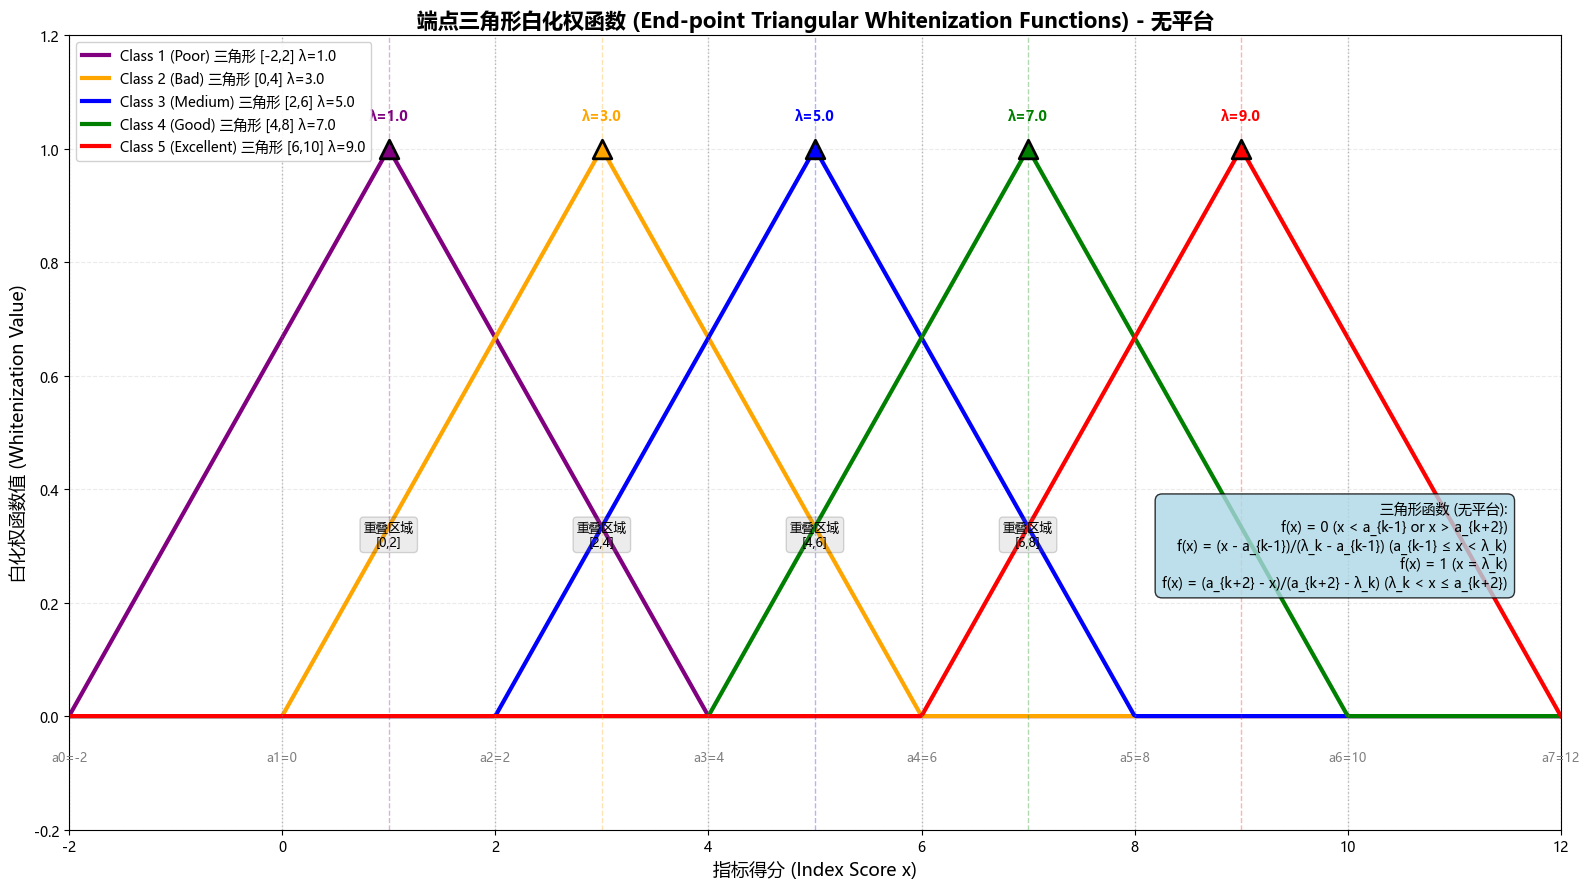

✓ 生成三角形 vs 梯形对比图...


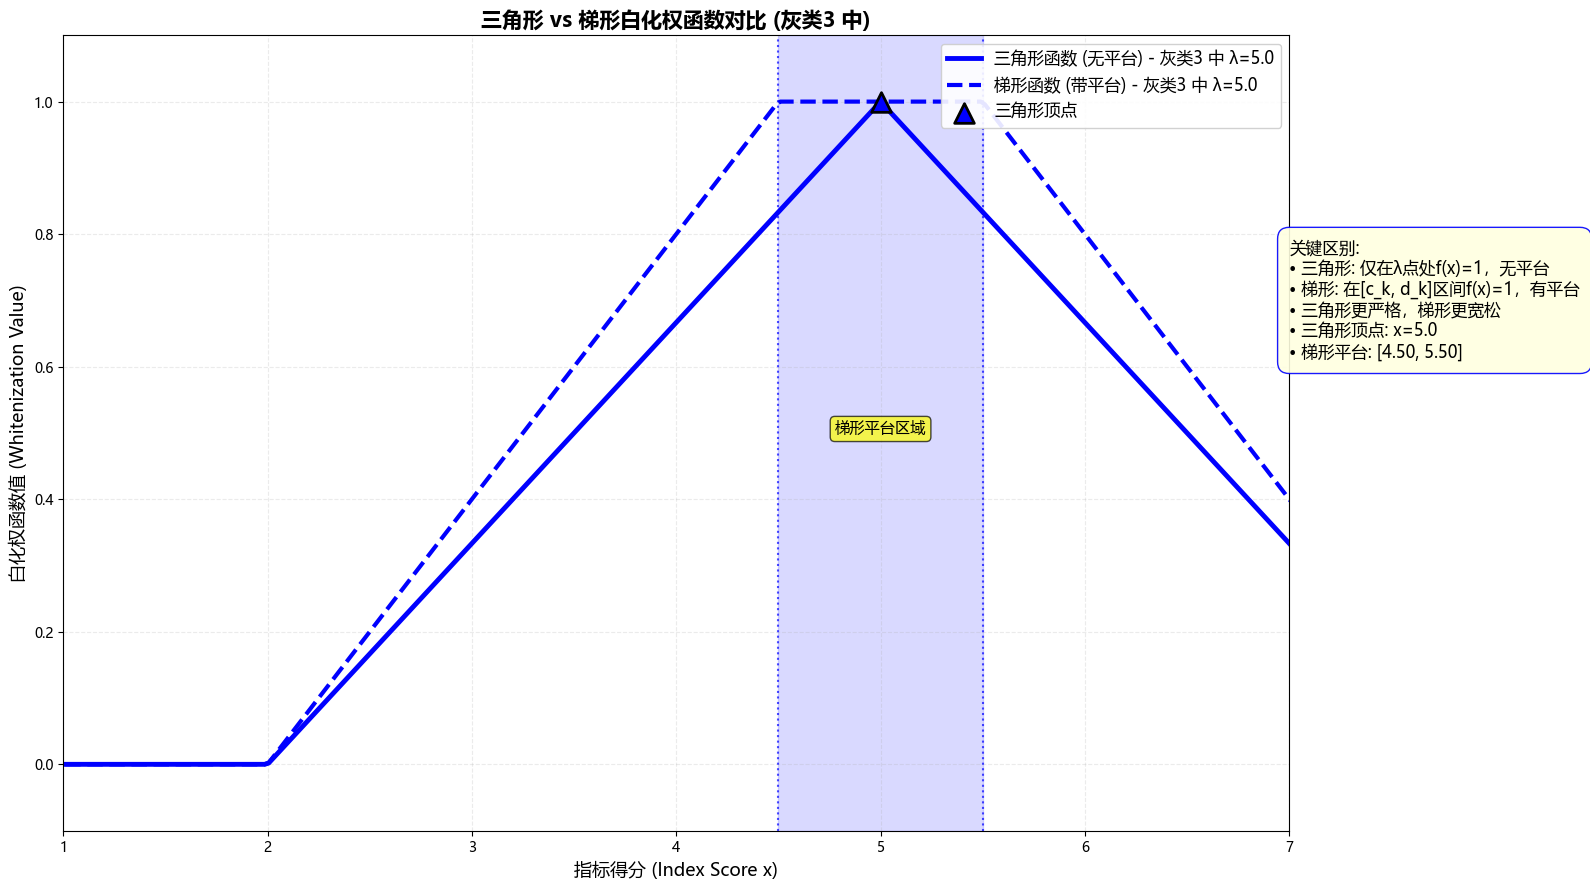


归一化白化权向量示例（各灰类权重之和=1）：
得分	劣	差	中	良	优	辅助得分(10分制)
1.0	0.750	0.250	0.000	0.000	0.000	1.50
3.0	0.200	0.600	0.200	0.000	0.000	3.00
5.0	0.000	0.200	0.600	0.200	0.000	5.00
7.0	0.000	0.000	0.200	0.600	0.200	7.00
9.0	0.000	0.000	0.000	0.250	0.750	8.50

说明: 辅助得分 = 灰色评估权向量 · [1.0, 3.0, 5.0, 7.0, 9.0]
      三角形函数特点：仅在λ点处达到最大值1，无平台区域



In [24]:
print("步骤5: AHP层次分析法计算主观权重（α）")
print("-"*80)

def ahp_calculate_weights(judgment_matrix):
    """
    AHP计算权重
    
    参数:
        judgment_matrix: 判断矩阵（numpy数组）
    
    返回:
        weights: 权重向量
        CR: 一致性比率
    """
    n = len(judgment_matrix)
    
    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(judgment_matrix)
    
    # 找到最大特征值及其对应的特征向量
    max_eigenvalue_index = np.argmax(eigenvalues.real)
    max_eigenvalue = eigenvalues[max_eigenvalue_index].real
    max_eigenvector = eigenvectors[:, max_eigenvalue_index].real
    
    # 归一化得到权重
    weights = max_eigenvector / max_eigenvector.sum()
    
    # 一致性检验
    CI = (max_eigenvalue - n) / (n - 1)
    
    # RI值表（随机一致性指标）
    RI_dict = {1: 0, 2: 0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 
               8: 1.41, 9: 1.45, 10: 1.49}
    RI = RI_dict.get(n, 1.41)
    
    CR = CI / RI if RI != 0 else 0
    
    return weights, CR

# 5.1 准则层判断矩阵（8个维度）
# 优先级: RL > SC > AJ > EF > PO > NC > HO > RS
print("5.1 准则层判断矩阵（8个维度）")
print("    优先级: 可靠性 > 安全性 > 抗干扰性 > 有效性 > 处理能力 > 组网能力 > 人为操作 > 响应能力")

# 构建判断矩阵（按优先级排序）
# RL, SC, AJ, EF, PO, NC, HO, RS
criteria_matrix = np.array([
    [1,   2,   3,   4,   5,   6,   7,   8],    # RL 可靠性
    [1/2, 1,   2,   3,   4,   5,   6,   7],    # SC 安全性
    [1/3, 1/2, 1,   2,   3,   4,   5,   6],    # AJ 抗干扰性
    [1/4, 1/3, 1/2, 1,   2,   3,   4,   5],    # EF 有效性
    [1/5, 1/4, 1/3, 1/2, 1,   2,   3,   4],    # PO 处理能力
    [1/6, 1/5, 1/4, 1/3, 1/2, 1,   2,   3],    # NC 组网能力
    [1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1,   2],    # HO 人为操作
    [1/8, 1/7, 1/6, 1/5, 1/4, 1/3, 1/2, 1]     # RS 响应能力
])

criteria_weights, criteria_CR = ahp_calculate_weights(criteria_matrix)

print(f"    一致性比率 CR = {criteria_CR:.4f}", end="")
if criteria_CR < 0.1:
    print(" ✓ (通过一致性检验)")
else:
    print(" ✗ (未通过一致性检验)")

# 维度代码（按优先级排序）
dim_codes_ordered = ['RL', 'SC', 'AJ', 'EF', 'PO', 'NC', 'HO', 'RS']

print("\n    准则层权重:")
for i, dim_code in enumerate(dim_codes_ordered):
    weight = criteria_weights[i]
    print(f"      {INDICATOR_SYSTEM[dim_code]['name']} ({dim_code}): {weight:.6f} ({weight*100:.2f}%)")

print()
print("说明: 准则层（维度层）使用AHP主观权重")
print("      因素层（指标层）使用熵权法客观权重（已在步骤4中计算）")
print()

# 5.2 定义灰色层次评估法的白化权函数（端点三角形白化权函数 - 无平台）
print("5.2 定义灰色层次评估法的白化权函数")
print("    采用端点三角形白化权函数（5灰类，无平台区域）")
print("-"*80)

# 端点定义
a = {
    0: -2,   # 左延拓
    1: 0,    # 第1个端点
    2: 2,    # 第2个端点
    3: 4,    # 第3个端点
    4: 6,    # 第4个端点
    5: 8,    # 第5个端点
    6: 10,   # 第6个端点
    7: 12    # 右延拓
}

print("    端点定义：a_0=-2, a_1=0, a_2=2, a_3=4, a_4=6, a_5=8, a_6=10, a_7=12")

# 灰类名称
grey_names = {1: "劣", 2: "差", 3: "中", 4: "良", 5: "优"}

print("    灰类区间定义（按公式 [a_{k-1}, a_{k+2}]）：")
for k in [1, 2, 3, 4, 5]:
    a_k_minus_1 = a[k-1]
    a_k_plus_2 = a[k+2]
    print(f"      灰类{k}（{grey_names[k]}）：[{a_k_minus_1}, {a_k_plus_2}]")
print()

def calculate_grey_params(k):
    """计算灰类k的参数"""
    a_k = a[k]
    a_k_plus_1 = a[k+1]
    
    # λ_k = (a_k + a_{k+1}) / 2
    lambda_k = (a_k + a_k_plus_1) / 2
    
    # 区间边界
    a_k_minus_1 = a[k-1]
    a_k_plus_2 = a[k+2]
    
    # 梯形平台参数（用于对比）
    c_k = (a_k + lambda_k) / 2
    d_k = (lambda_k + a_k_plus_1) / 2
    
    return {
        'a_k': a_k,
        'a_k_plus_1': a_k_plus_1,
        'lambda_k': lambda_k,
        'c_k': c_k,
        'd_k': d_k,
        'a_k_minus_1': a_k_minus_1,
        'a_k_plus_2': a_k_plus_2
    }

def whitening_function_k(x, k):
    """
    通用的第k个灰类三角形白化权函数（无平台）
    左边界: a_{k-1}, 顶点: λ_k, 右边界: a_{k+2}
    """
    params = calculate_grey_params(k)
    
    a_k_minus_1 = params['a_k_minus_1']
    lambda_k = params['lambda_k']
    a_k_plus_2 = params['a_k_plus_2']
    
    if x < a_k_minus_1 or x > a_k_plus_2:
        return 0
    elif a_k_minus_1 <= x < lambda_k:
        # 上升段 - 到顶点
        return (x - a_k_minus_1) / (lambda_k - a_k_minus_1)
    elif x == lambda_k:
        return 1
    elif lambda_k < x <= a_k_plus_2:
        # 下降段 - 从顶点下降
        return (a_k_plus_2 - x) / (a_k_plus_2 - lambda_k)
    else:
        return 0

def whitening_function_k_trapezoid(x, k):
    """
    梯形白化权函数（带平台）- 仅用于对比
    """
    params = calculate_grey_params(k)
    
    a_k_minus_1 = params['a_k_minus_1']
    c_k = params['c_k']
    d_k = params['d_k']
    a_k_plus_2 = params['a_k_plus_2']
    
    if x < a_k_minus_1 or x > a_k_plus_2:
        return 0
    elif a_k_minus_1 <= x < c_k:
        return (x - a_k_minus_1) / (c_k - a_k_minus_1)
    elif c_k <= x <= d_k:
        return 1
    elif d_k < x <= a_k_plus_2:
        return (a_k_plus_2 - x) / (a_k_plus_2 - d_k)
    else:
        return 0

# 创建5个三角形白化权函数（无平台）
def whitening_function_1(x):
    """灰类1（劣）- 三角形"""
    return whitening_function_k(x, 1)

def whitening_function_2(x):
    """灰类2（差）- 三角形"""
    return whitening_function_k(x, 2)

def whitening_function_3(x):
    """灰类3（中）- 三角形"""
    return whitening_function_k(x, 3)

def whitening_function_4(x):
    """灰类4（良）- 三角形"""
    return whitening_function_k(x, 4)

def whitening_function_5(x):
    """灰类5（优）- 三角形"""
    return whitening_function_k(x, 5)

# 创建5个梯形白化权函数（带平台）- 用于对比
def whitening_function_1_trapezoid(x):
    """灰类1（劣）- 梯形"""
    return whitening_function_k_trapezoid(x, 1)

def whitening_function_2_trapezoid(x):
    """灰类2（差）- 梯形"""
    return whitening_function_k_trapezoid(x, 2)

def whitening_function_3_trapezoid(x):
    """灰类3（中）- 梯形"""
    return whitening_function_k_trapezoid(x, 3)

def whitening_function_4_trapezoid(x):
    """灰类4（良）- 梯形"""
    return whitening_function_k_trapezoid(x, 4)

def whitening_function_5_trapezoid(x):
    """灰类5（优）- 梯形"""
    return whitening_function_k_trapezoid(x, 5)

WHITENING_FUNCTIONS = [
    whitening_function_1,
    whitening_function_2,
    whitening_function_3,
    whitening_function_4,
    whitening_function_5
]

WHITENING_FUNCTIONS_TRAPEZOID = [
    whitening_function_1_trapezoid,
    whitening_function_2_trapezoid,
    whitening_function_3_trapezoid,
    whitening_function_4_trapezoid,
    whitening_function_5_trapezoid
]

# 计算灰类代表值（使用λ_k）
GREY_CLASS_VALUES = [
    calculate_grey_params(1)['lambda_k'],  # 劣: 1.0
    calculate_grey_params(2)['lambda_k'],  # 差: 3.0
    calculate_grey_params(3)['lambda_k'],  # 中: 5.0
    calculate_grey_params(4)['lambda_k'],  # 良: 7.0
    calculate_grey_params(5)['lambda_k'],  # 优: 9.0
]

print("✓ 白化权函数定义完成（三角形，无平台）")
print(f"✓ 灰类代表值（λ值）: {GREY_CLASS_VALUES}")
print()

# 打印详细参数
print("    灰类参数详细计算（三角形）：")
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    print(f"      灰类{k}（{grey_names[k]}）：λ_{k}={params['lambda_k']:.1f}, 顶点x={params['lambda_k']:.1f}")
print()

# 绘制白化权函数图形
print("绘制白化权函数图形...")
print("-"*80)

x_plot = np.linspace(-2, 12, 700)

# 三角形函数值
y1 = np.array([whitening_function_1(xi) for xi in x_plot])
y2 = np.array([whitening_function_2(xi) for xi in x_plot])
y3 = np.array([whitening_function_3(xi) for xi in x_plot])
y4 = np.array([whitening_function_4(xi) for xi in x_plot])
y5 = np.array([whitening_function_5(xi) for xi in x_plot])

# 梯形函数值（用于对比）
y1_trap = np.array([whitening_function_1_trapezoid(xi) for xi in x_plot])
y2_trap = np.array([whitening_function_2_trapezoid(xi) for xi in x_plot])
y3_trap = np.array([whitening_function_3_trapezoid(xi) for xi in x_plot])
y4_trap = np.array([whitening_function_4_trapezoid(xi) for xi in x_plot])
y5_trap = np.array([whitening_function_5_trapezoid(xi) for xi in x_plot])

# 颜色和名称定义
colors = ['purple', 'orange', 'blue', 'green', 'red']
class_names_en = ['Poor', 'Bad', 'Medium', 'Good', 'Excellent']
class_names_cn = ['劣', '差', '中', '良', '优']
lambda_values = [f'{v:.1f}' for v in GREY_CLASS_VALUES]

# 图1：三角形白化权函数（无平台）
fig_whitening = plt.figure(figsize=(16, 9))

# 绘制三角形函数曲线
plt.plot(x_plot, y1, color=colors[0], linewidth=3, 
         label=f'Class 1 ({class_names_en[0]}) 三角形 [-2,2] λ={lambda_values[0]}')
plt.plot(x_plot, y2, color=colors[1], linewidth=3, 
         label=f'Class 2 ({class_names_en[1]}) 三角形 [0,4] λ={lambda_values[1]}')
plt.plot(x_plot, y3, color=colors[2], linewidth=3, 
         label=f'Class 3 ({class_names_en[2]}) 三角形 [2,6] λ={lambda_values[2]}')
plt.plot(x_plot, y4, color=colors[3], linewidth=3, 
         label=f'Class 4 ({class_names_en[3]}) 三角形 [4,8] λ={lambda_values[3]}')
plt.plot(x_plot, y5, color=colors[4], linewidth=3, 
         label=f'Class 5 ({class_names_en[4]}) 三角形 [6,10] λ={lambda_values[4]}')

# 标注端点
for i in range(8):
    plt.axvline(a[i], color='gray', linestyle=':', alpha=0.5, linewidth=1)
    plt.text(a[i], -0.08, f'a{i}={a[i]}', ha='center', fontsize=9, color='gray')

# 标注顶点
for k in [1, 2, 3, 4, 5]:
    params = calculate_grey_params(k)
    color = colors[k-1]
    
    # 标注顶点（三角形）
    plt.scatter([params['lambda_k']], [1], color=color, s=180, zorder=5, 
                marker='^', edgecolors='black', linewidths=2)
    plt.axvline(params['lambda_k'], color=color, linestyle='--', alpha=0.3, linewidth=1)
    
    # 添加λ标注
    plt.text(params['lambda_k'], 1.05, f'λ={params["lambda_k"]:.1f}', 
             ha='center', fontsize=10, fontweight='bold', color=color)

plt.title('端点三角形白化权函数 (End-point Triangular Whitenization Functions) - 无平台', 
          fontsize=15, fontweight='bold')
plt.xlabel('指标得分 (Index Score x)', fontsize=13)
plt.ylabel('白化权函数值 (Whitenization Value)', fontsize=13)
plt.grid(alpha=0.25, linestyle='--')
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.ylim(-0.2, 1.2)
plt.xlim(-2, 12)

# 添加三角形函数公式说明
formula_text = '三角形函数 (无平台):\n' \
               'f(x) = 0 (x < a_{k-1} or x > a_{k+2})\n' \
               'f(x) = (x - a_{k-1})/(λ_k - a_{k-1}) (a_{k-1} ≤ x < λ_k)\n' \
               'f(x) = 1 (x = λ_k)\n' \
               'f(x) = (a_{k+2} - x)/(a_{k+2} - λ_k) (λ_k < x ≤ a_{k+2})'
plt.text(11.5, 0.3, formula_text, fontsize=10, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
         verticalalignment='center', horizontalalignment='right')

# 添加重叠区域说明
plt.text(1, 0.3, '重叠区域\n[0,2]', ha='center', fontsize=9, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))
plt.text(3, 0.3, '重叠区域\n[2,4]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))
plt.text(5, 0.3, '重叠区域\n[4,6]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))
plt.text(7, 0.3, '重叠区域\n[6,8]', ha='center', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.3', facecolor='gray', alpha=0.15))

plt.tight_layout()

# 显示白化权函数图形
print(f"✓ 三角形白化权函数图已生成，正在显示...")
plt.show()
plt.close(fig_whitening)

# 图2：三角形 vs 梯形 对比图（灰类3（中）作为示例）
print(f"✓ 生成三角形 vs 梯形对比图...")
fig_compare = plt.figure(figsize=(16, 9))

# 绘制三角形（无平台）- 实线
plt.plot(x_plot, y3, 'b-', linewidth=3.5, 
         label=f'三角形函数 (无平台) - 灰类3 中 λ={lambda_values[2]}')

# 绘制梯形（带平台）- 虚线
plt.plot(x_plot, y3_trap, 'b--', linewidth=3, 
         label=f'梯形函数 (带平台) - 灰类3 中 λ={lambda_values[2]}')

# 标注对比区域
params = calculate_grey_params(3)
c_k = params['c_k']
d_k = params['d_k']

# 三角形顶点
plt.scatter([params['lambda_k']], [1], color='blue', s=200, zorder=5, 
            marker='^', edgecolors='black', linewidths=2, label='三角形顶点')

# 梯形平台区域
plt.axvline(c_k, color='blue', linestyle=':', alpha=0.7, linewidth=1.5)
plt.axvline(d_k, color='blue', linestyle=':', alpha=0.7, linewidth=1.5)
plt.axvspan(c_k, d_k, alpha=0.15, color='blue')
plt.text((c_k + d_k)/2, 0.5, '梯形平台区域', ha='center', fontsize=11, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# 添加对比说明
diff_text = '关键区别:\n' \
            '• 三角形: 仅在λ点处f(x)=1，无平台\n' \
            '• 梯形: 在[c_k, d_k]区间f(x)=1，有平台\n' \
            '• 三角形更严格，梯形更宽松\n' \
            f'• 三角形顶点: x={params["lambda_k"]:.1f}\n' \
            f'• 梯形平台: [{c_k:.2f}, {d_k:.2f}]'
plt.text(7, 0.7, diff_text, fontsize=12, 
         bbox=dict(boxstyle='round,pad=0.7', facecolor='lightyellow', alpha=0.9, edgecolor='blue'),
         verticalalignment='center')

plt.title('三角形 vs 梯形白化权函数对比 (灰类3 中)', fontsize=15, fontweight='bold')
plt.xlabel('指标得分 (Index Score x)', fontsize=13)
plt.ylabel('白化权函数值 (Whitenization Value)', fontsize=13)
plt.grid(alpha=0.25, linestyle='--')
plt.legend(loc='upper right', fontsize=12, framealpha=0.9)
plt.ylim(-0.1, 1.1)
plt.xlim(1, 7)
plt.tight_layout()
plt.show()
plt.close(fig_compare)

# 输出归一化示例
print("\n归一化白化权向量示例（各灰类权重之和=1）：")
print("得分\t劣\t差\t中\t良\t优\t辅助得分(10分制)")
test_scores = [1.0, 3.0, 5.0, 7.0, 9.0]
for s in test_scores:
    w = [f(s) for f in WHITENING_FUNCTIONS]
    w_sum = sum(w)
    if w_sum > 0:
        w_norm = [wi / w_sum for wi in w]
    else:
        w_norm = [0.2, 0.2, 0.2, 0.2, 0.2]
    
    # 计算辅助得分
    aux_score = sum(w_norm[i] * GREY_CLASS_VALUES[i] for i in range(5))
    
    print(f'{s:.1f}\t{w_norm[0]:.3f}\t{w_norm[1]:.3f}\t{w_norm[2]:.3f}\t{w_norm[3]:.3f}\t{w_norm[4]:.3f}\t{aux_score:.2f}')
print()
print("说明: 辅助得分 = 灰色评估权向量 · [1.0, 3.0, 5.0, 7.0, 9.0]")
print("      三角形函数特点：仅在λ点处达到最大值1，无平台区域")
print()

In [25]:
print("步骤6: 灰色层次评估计算")
print("-"*80)
print("使用白化权函数计算灰色评估系数")
print()

def calculate_grey_coefficients(value_100):
    """
    计算单个指标值的灰色评估系数
    
    参数:
        value_100: 标准化后的指标值（0-100分）
    
    返回:
        grey_vector: 灰色评估权向量 [r1, r2, r3, r4, r5]
    """
    # 转换到10分制
    value_10 = value_100 / 10.0
    
    # 计算白化权函数值
    f_values = [f(value_10) for f in WHITENING_FUNCTIONS]
    
    # 归一化得到灰色评估权向量
    total = sum(f_values)
    if total == 0:
        # 如果所有白化权函数值都为0，返回均匀分布
        return [0.2, 0.2, 0.2, 0.2, 0.2]
    else:
        return [f / total for f in f_values]

# 6.1 计算指标层灰色评估系数
print("6.1 计算指标层灰色评估系数")
print("    对每个指标的标准化值计算其对5个灰类的隶属度")
print()

# 创建得分数据框
df_scores = df_normalized[['test_id', 'scenario_id']].copy()

# 存储每个指标的灰色评估权向量
df_grey_coefficients = {}

for dim_code, dim_info in INDICATOR_SYSTEM.items():
    for indicator in dim_info['indicators']:
        code = indicator['code']
        
        # 对每个测试方案的该指标计算灰色评估权向量
        grey_vectors = []
        for idx, row in df_normalized.iterrows():
            value = row[code]
            grey_vector = calculate_grey_coefficients(value)
            grey_vectors.append(grey_vector)
        
        df_grey_coefficients[code] = grey_vectors

print(f"✓ 完成21个指标的灰色评估系数计算")
print(f"✓ 每个指标生成5个灰色评估系数（对应5个灰类）")
print()

# 6.2 计算维度层灰色评估
print("6.2 计算维度层灰色评估")
print("    使用熵权法局部权重加权指标层灰色评估系数")
print()

for dim_code, dim_info in INDICATOR_SYSTEM.items():
    print(f"  计算 {dim_info['name']} ({dim_code}) 维度的灰色评估...")
    
    # 对每个测试方案
    dim_grey_vectors = []
    for test_idx in range(len(df_normalized)):
        # 初始化维度的灰色评估权向量 [r1, r2, r3, r4, r5]
        dim_grey_vector = [0.0, 0.0, 0.0, 0.0, 0.0]
        
        # 使用熵权法局部权重加权
        for indicator in dim_info['indicators']:
            code = indicator['code']
            entropy_weight = indicator_entropy_weights[code]  # 熵权法局部权重
            
            # 该指标的灰色评估权向量
            indicator_grey_vector = df_grey_coefficients[code][test_idx]
            
            # 加权累加
            for i in range(5):
                dim_grey_vector[i] += entropy_weight * indicator_grey_vector[i]
        
        dim_grey_vectors.append(dim_grey_vector)
    
    # 存储维度的灰色评估权向量
    for i in range(5):
        df_scores[f'{dim_code}_grey_{i+1}'] = [vec[i] for vec in dim_grey_vectors]
    
    # 计算维度得分（10分制）
    dim_scores_10 = [sum(vec[i] * GREY_CLASS_VALUES[i] for i in range(5)) for vec in dim_grey_vectors]
    
    # 转换回100分制
    df_scores[f'{dim_code}_score'] = [score * 10 for score in dim_scores_10]

print(f"✓ 完成8个维度的灰色评估计算")
print()

# 6.3 计算目标层综合评估
print("6.3 计算目标层综合评估")
print("    使用AHP维度权重加权维度层灰色评估系数")
print()

# 对每个测试方案
total_grey_vectors = []
for test_idx in range(len(df_normalized)):
    # 初始化总体灰色评估权向量 [r1, r2, r3, r4, r5]
    total_grey_vector = [0.0, 0.0, 0.0, 0.0, 0.0]
    
    # 使用AHP维度权重加权
    for i, dim_code in enumerate(dim_codes_ordered):
        ahp_weight = criteria_weights[i]  # AHP维度权重
        
        # 该维度的灰色评估权向量
        dim_grey_vector = [
            df_scores.iloc[test_idx][f'{dim_code}_grey_1'],
            df_scores.iloc[test_idx][f'{dim_code}_grey_2'],
            df_scores.iloc[test_idx][f'{dim_code}_grey_3'],
            df_scores.iloc[test_idx][f'{dim_code}_grey_4'],
            df_scores.iloc[test_idx][f'{dim_code}_grey_5']
        ]
        
        # 加权累加
        for j in range(5):
            total_grey_vector[j] += ahp_weight * dim_grey_vector[j]
    
    total_grey_vectors.append(total_grey_vector)

# 存储总体灰色评估权向量
for j in range(5):
    df_scores[f'total_grey_{j+1}'] = [vec[j] for vec in total_grey_vectors]

# 计算综合得分（10分制）
total_scores_10 = [sum(vec[j] * GREY_CLASS_VALUES[j] for j in range(5)) for vec in total_grey_vectors]

# 转换回100分制
df_scores['total_score'] = [score * 10 for score in total_scores_10]

print(f"✓ 完成综合评估计算")
print()

# 6.4 评估等级
def get_grade(score):
    """
    根据灰色评估得分确定等级
    基于10分制的灰类定义转换到100分制
    """
    if score >= 90:  # 对应10分制的9分以上
        return '优秀'
    elif score >= 70:  # 对应10分制的7分以上
        return '良好'
    elif score >= 50:  # 对应10分制的5分以上
        return '中等'
    elif score >= 30:  # 对应10分制的3分以上
        return '较差'
    else:  # 对应10分制的3分以下
        return '很差'

df_scores['grade'] = df_scores['total_score'].apply(get_grade)

# 6.5 排名
df_scores['rank'] = df_scores['total_score'].rank(ascending=False, method='min').astype(int)

# 按排名排序
df_scores = df_scores.sort_values('rank')

print("✓ 完成综合评分计算")
print()

步骤6: 灰色层次评估计算
--------------------------------------------------------------------------------
使用白化权函数计算灰色评估系数

6.1 计算指标层灰色评估系数
    对每个指标的标准化值计算其对5个灰类的隶属度

✓ 完成21个指标的灰色评估系数计算
✓ 每个指标生成5个灰色评估系数（对应5个灰类）

6.2 计算维度层灰色评估
    使用熵权法局部权重加权指标层灰色评估系数

  计算 可靠性 (RL) 维度的灰色评估...
  计算 安全性 (SC) 维度的灰色评估...
  计算 抗干扰性 (AJ) 维度的灰色评估...
  计算 有效性 (EF) 维度的灰色评估...
  计算 处理能力 (PO) 维度的灰色评估...
  计算 组网能力 (NC) 维度的灰色评估...
  计算 人为操作 (HO) 维度的灰色评估...
  计算 响应能力 (RS) 维度的灰色评估...
✓ 完成8个维度的灰色评估计算

6.3 计算目标层综合评估
    使用AHP维度权重加权维度层灰色评估系数

✓ 完成综合评估计算

✓ 完成综合评分计算



In [26]:
# ============================================================================
# 第八部分：评估结果输出
# ============================================================================

In [27]:
print("="*80)
print("评估结果汇总")
print("="*80)
print()

# 输出排名表（基于灰色评估权向量）
print("综合排名（基于灰色层次评估法）:")
print("="*130)
print(f"{'排名':<6}{'测试批次':<15}{'灰色评估权向量 [劣,差,中,良,优]':<45}{'辅助得分':<12}{'主导等级':<15}{'评级':<10}")
print("="*130)

for idx, row in df_scores.iterrows():
    rank = row['rank']
    test_id = row['test_id']
    grey_vec = [row[f'total_grey_{i}'] for i in range(1, 6)]
    aux_score = row['total_score']
    grade = row['grade']
    
    # 确定主导等级
    max_idx = grey_vec.index(max(grey_vec))
    dominant_class = ['很差', '较差', '中等', '良好', '优秀'][max_idx]
    dominant_percent = grey_vec[max_idx] * 100
    
    grey_vec_str = f"[{grey_vec[0]:.3f}, {grey_vec[1]:.3f}, {grey_vec[2]:.3f}, {grey_vec[3]:.3f}, {grey_vec[4]:.3f}]"
    
    print(f"{rank:<6}{test_id:<15}{grey_vec_str:<45}{aux_score:>6.2f}分    {dominant_class}({dominant_percent:.0f}%)    {grade:<10}")

print("="*130)
print()
print("说明:")
print("  1. 主要结果: 灰色评估权向量 - 反映对各灰类的隶属度分布")
print("  2. 辅助得分: 便于快速比较的单一数值（灰色评估权向量 × 灰类代表值 × 10）")
print("  3. 主导等级: 权重最大的灰类")
print("  4. 排名依据: 基于辅助得分")
print()

# 输出维度得分表
print("\n维度得分汇总:")
print("-"*80)
dim_result_cols = ['rank', 'test_id'] + [f'{dim}_score' for dim in dim_codes_ordered]
dim_result_display = df_scores[dim_result_cols].copy()
dim_result_display.columns = ['排名', '测试批次'] + [INDICATOR_SYSTEM[dim]['name'] for dim in dim_codes_ordered]

# 格式化输出
for col in dim_result_display.columns[2:]:
    dim_result_display[col] = dim_result_display[col].apply(lambda x: f"{x:.2f}")

print(dim_result_display.to_string(index=False))
print()

# 详细报告（每个测试批次）
print("="*80)
print("详细评估报告")
print("="*80)

for idx, row in df_scores.iterrows():
    test_id = row['test_id']
    total_score = row['total_score']
    grade = row['grade']
    rank = row['rank']
    
    print(f"\n测试批次: {test_id}")
    print(f"综合得分: {total_score:.2f}分")
    print(f"评估等级: {grade}")
    print(f"排名: {rank}/{len(df_scores)}")
    
    # 显示灰色评估权向量
    grey_vector = [row[f'total_grey_{i}'] for i in range(1, 6)]
    print(f"灰色评估权向量: [{grey_vector[0]:.3f}, {grey_vector[1]:.3f}, {grey_vector[2]:.3f}, {grey_vector[3]:.3f}, {grey_vector[4]:.3f}]")
    print(f"  → 很差倾向: {grey_vector[0]*100:.1f}%")
    print(f"  → 较差倾向: {grey_vector[1]*100:.1f}%")
    print(f"  → 中等倾向: {grey_vector[2]*100:.1f}%")
    print(f"  → 良好倾向: {grey_vector[3]*100:.1f}%")
    print(f"  → 优秀倾向: {grey_vector[4]*100:.1f}%")
    print()
    
    print("维度得分:")
    for dim_code in dim_codes_ordered:
        dim_name = INDICATOR_SYSTEM[dim_code]['name']
        dim_score = row[f'{dim_code}_score']
        dim_grey = [row[f'{dim_code}_grey_{i}'] for i in range(1, 6)]
        print(f"  {dim_name:8s}: {dim_score:6.2f}分  灰色评估: [{dim_grey[0]:.2f}, {dim_grey[1]:.2f}, {dim_grey[2]:.2f}, {dim_grey[3]:.2f}, {dim_grey[4]:.2f}]", end="")
        
        # 特殊标记
        if dim_code == 'RL':
            crash_rate = df_raw.loc[df_raw['test_id'] == test_id, 'RL_crash_rate'].values[0]
            if crash_rate == 0:
                print(" ⭐ (无崩溃)")
            else:
                print(f" ⚠ (崩溃比例: {crash_rate*100:.1f}%)")
        else:
            print()
    
    print()
    print("关键指标:")
    test_raw = df_raw[df_raw['test_id'] == test_id].iloc[0]
    
    # 可靠性关键指标
    crash_rate = test_raw['RL_crash_rate']
    availability = test_raw['RL_communication_availability_rate']
    success_rate = test_raw['RL_communication_success_rate']
    recovery_time = test_raw['RL_recovery_duration_ms']
    
    if crash_rate == 0:
        print(f"  ✓ 崩溃比例: 0% (优秀)")
    else:
        print(f"  ✗ 崩溃比例: {crash_rate*100:.1f}% (需改进)")
    
    print(f"  {'✓' if availability >= 0.95 else '⚠'} 通信可用性: {availability*100:.1f}%")
    print(f"  {'✓' if success_rate >= 0.90 else '⚠'} 通信成功率: {success_rate*100:.1f}%")
    
    if recovery_time == 0:
        print(f"  ✓ 恢复时长: 0ms (无崩溃)")
    else:
        print(f"  ⚠ 恢复时长: {recovery_time:.0f}ms ({recovery_time/1000:.1f}秒)")
    
    print("-"*80)

print()

评估结果汇总

综合排名（基于灰色层次评估法）:
排名    测试批次           灰色评估权向量 [劣,差,中,良,优]                          辅助得分        主导等级           评级        
1     TEST-2026-001  [0.034, 0.147, 0.094, 0.136, 0.589]           71.98分    优秀(59%)    良好        
2     TEST-2026-010  [0.091, 0.196, 0.211, 0.120, 0.381]           60.09分    优秀(38%)    中等        
3     TEST-2026-009  [0.201, 0.149, 0.172, 0.088, 0.390]           56.35分    优秀(39%)    中等        
4     TEST-2026-006  [0.223, 0.108, 0.188, 0.148, 0.334]           55.22分    优秀(33%)    中等        
5     TEST-2026-005  [0.224, 0.162, 0.171, 0.068, 0.376]           54.21分    优秀(38%)    中等        
6     TEST-2026-002  [0.223, 0.172, 0.150, 0.102, 0.353]           53.79分    优秀(35%)    中等        
7     TEST-2026-008  [0.271, 0.145, 0.099, 0.145, 0.340]           52.74分    优秀(34%)    中等        
8     TEST-2026-004  [0.299, 0.198, 0.087, 0.066, 0.349]           49.33分    优秀(35%)    较差        
9     TEST-2026-007  [0.350, 0.120, 0.185, 0.182, 0.163]           43.76分    很差

模糊综合评判法 - R和A数据的来源详解

【数据来源1】模糊关系矩阵 R - 由专家对'性能'进行主观评判

照片中的数据：

R1 = [0.8  0.2  0    0    0  ]
     [0.7  0.2  0.1  0    0  ]
     [0.6  0.2  0.1  0.1  0  ]

问题：这些数字是怎么来的？
--------------------------------------------------------------------------------

【详细过程】以R1的第一行为例
--------------------------------------------------------------------------------

R1的第一行 = [0.8, 0.2, 0, 0, 0]
这一行对应：信息获取能力

步骤1: 组建10人专家小组
  专家1, 专家2, ..., 专家10

步骤2: 专家对'信息获取能力'的性能进行评判
  问题：你认为这个系统的'信息获取能力'如何？
  评语选项：{好, 较好, 一般, 较差, 差}

10个专家的评判结果：
  专家 1: 好
  专家 2: 好
  专家 3: 较好
  专家 4: 好
  专家 5: 好
  专家 6: 好
  专家 7: 好
  专家 8: 好
  专家 9: 好
  专家10: 好

步骤3: 统计各评语的人数
--------------------------------------------------------------------------------
统计结果：
  '好':   9人
  '较好': 1人
  '一般': 0人
  '较差': 0人
  '差':   0人

步骤4: 计算隶属度（频率）
--------------------------------------------------------------------------------
隶属度计算：
  '好'的隶属度   = 9/10 = 0.9
  '较好'的隶属度 = 1/10 = 0.1
  '一般'的隶属度 = 0/10 = 0.0
  '较差'的隶属度 = 0/10 = 0.0
  '差'的隶属度   = 0/1

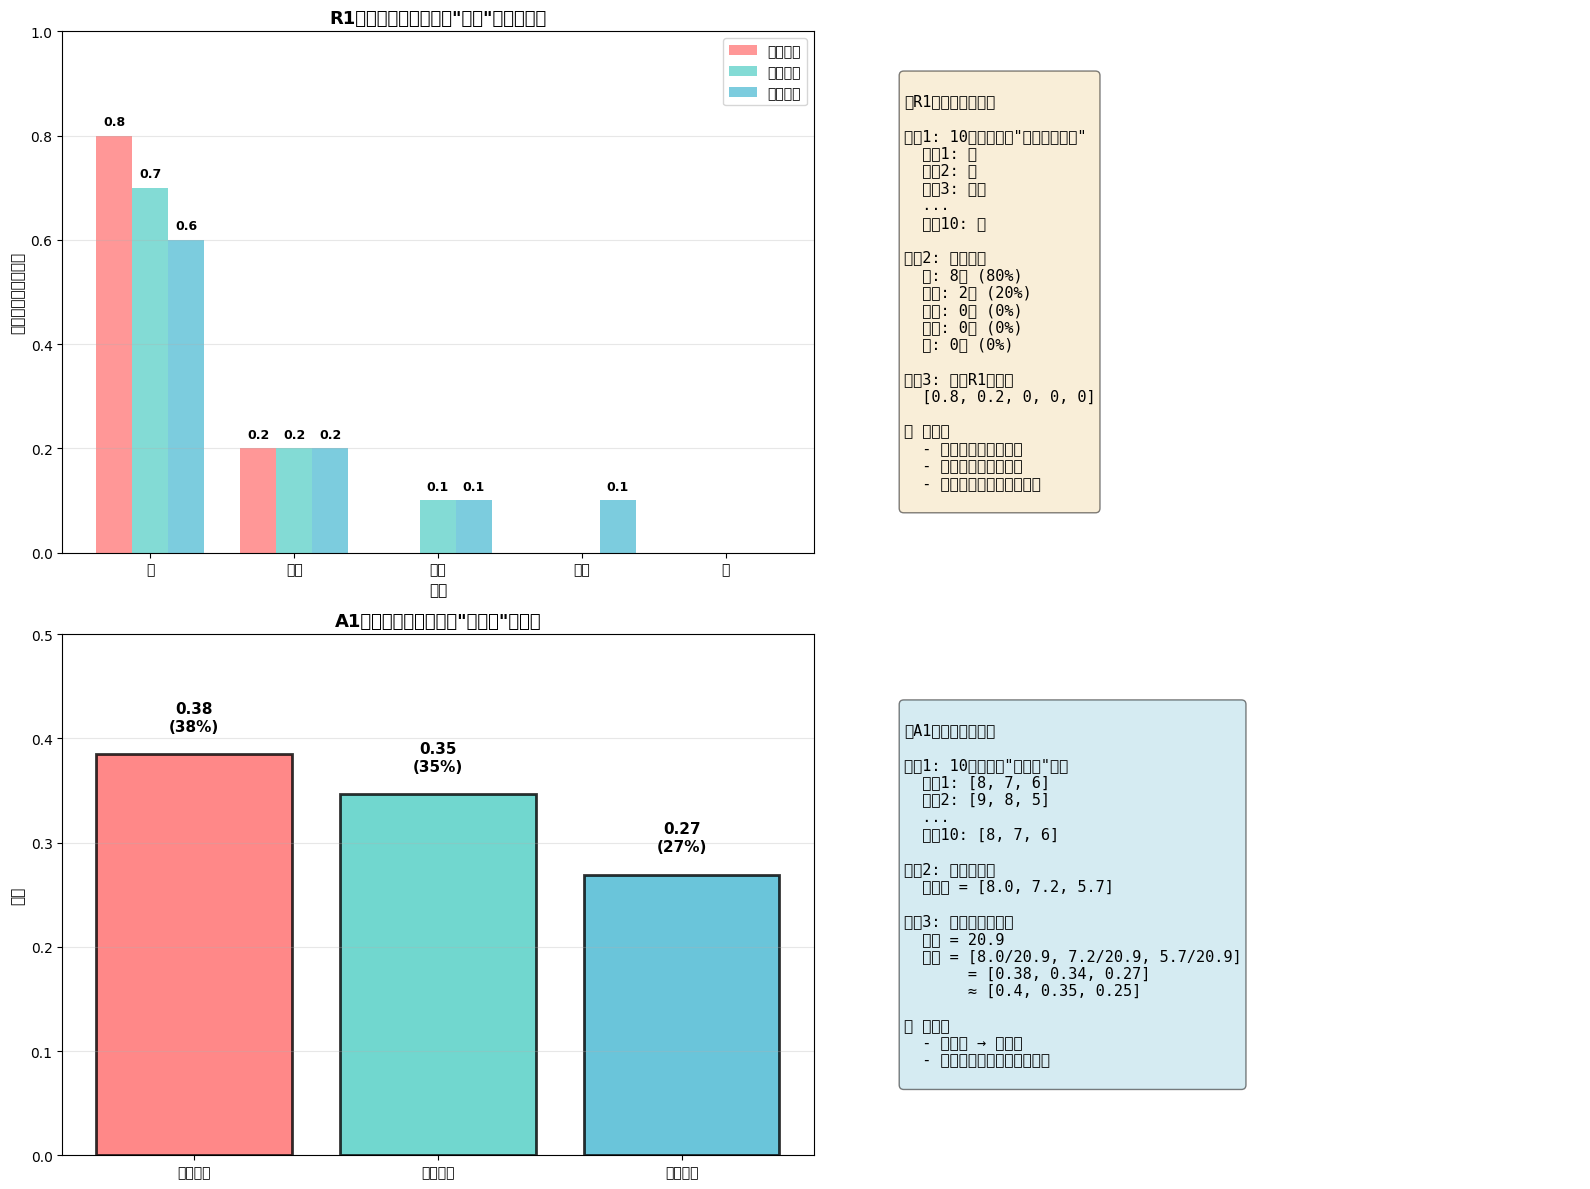

In [31]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
模糊综合评判法 - R和A数据的来源详解

关键问题：
1. 模糊关系矩阵 R 是怎么来的？
2. 权重向量 A 是怎么来的？
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

print("="*80)
print("模糊综合评判法 - R和A数据的来源详解")
print("="*80)
print()

# ============================================================================
# 数据来源1: 模糊关系矩阵 R
# ============================================================================

print("【数据来源1】模糊关系矩阵 R - 由专家对'性能'进行主观评判")
print("="*80)
print()

print("照片中的数据：")
print()
print("R1 = [0.8  0.2  0    0    0  ]")
print("     [0.7  0.2  0.1  0    0  ]")
print("     [0.6  0.2  0.1  0.1  0  ]")
print()

print("问题：这些数字是怎么来的？")
print("-"*80)
print()

# ============================================================================
# R矩阵的生成过程
# ============================================================================

print("【详细过程】以R1的第一行为例")
print("-"*80)
print()

print("R1的第一行 = [0.8, 0.2, 0, 0, 0]")
print("这一行对应：信息获取能力")
print()

print("步骤1: 组建10人专家小组")
print("  专家1, 专家2, ..., 专家10")
print()

print("步骤2: 专家对'信息获取能力'的性能进行评判")
print("  问题：你认为这个系统的'信息获取能力'如何？")
print("  评语选项：{好, 较好, 一般, 较差, 差}")
print()

# 模拟10个专家的评判结果
expert_evaluations = [
    '好',    # 专家1
    '好',    # 专家2
    '较好',  # 专家3
    '好',    # 专家4
    '好',    # 专家5
    '好',    # 专家6
    '好',    # 专家7
    '好',    # 专家8
    '好',    # 专家9
    '好',    # 专家10
]

print("10个专家的评判结果：")
for i, evaluation in enumerate(expert_evaluations, 1):
    print(f"  专家{i:2d}: {evaluation}")
print()

print("步骤3: 统计各评语的人数")
print("-"*80)

from collections import Counter
evaluation_counts = Counter(expert_evaluations)

print("统计结果：")
print(f"  '好':   {evaluation_counts['好']}人")
print(f"  '较好': {evaluation_counts['较好']}人")
print(f"  '一般': {evaluation_counts.get('一般', 0)}人")
print(f"  '较差': {evaluation_counts.get('较差', 0)}人")
print(f"  '差':   {evaluation_counts.get('差', 0)}人")
print()

print("步骤4: 计算隶属度（频率）")
print("-"*80)

total_experts = len(expert_evaluations)
membership_good = evaluation_counts['好'] / total_experts
membership_fairly_good = evaluation_counts['较好'] / total_experts
membership_average = evaluation_counts.get('一般', 0) / total_experts
membership_fairly_poor = evaluation_counts.get('较差', 0) / total_experts
membership_poor = evaluation_counts.get('差', 0) / total_experts

print(f"隶属度计算：")
print(f"  '好'的隶属度   = {evaluation_counts['好']}/10 = {membership_good:.1f}")
print(f"  '较好'的隶属度 = {evaluation_counts['较好']}/10 = {membership_fairly_good:.1f}")
print(f"  '一般'的隶属度 = 0/10 = {membership_average:.1f}")
print(f"  '较差'的隶属度 = 0/10 = {membership_fairly_poor:.1f}")
print(f"  '差'的隶属度   = 0/10 = {membership_poor:.1f}")
print()

print("步骤5: 得到模糊关系矩阵的第一行")
print("-"*80)
r1_row1 = [membership_good, membership_fairly_good, membership_average, 
           membership_fairly_poor, membership_poor]
print(f"R1[0] = {r1_row1}")
print(f"      = [0.8, 0.2, 0, 0, 0]  ✓")
print()

print("💡 关键理解：")
print("  - 0.8 表示：10人中有8人认为'好'，所以对'好'的隶属度是0.8")
print("  - 0.2 表示：10人中有2人认为'较好'，所以对'较好'的隶属度是0.2")
print("  - 这是专家主观评判的统计结果，不是客观计算的！")
print()

# ============================================================================
# 完整的R1矩阵生成
# ============================================================================

print("="*80)
print("【完整示例】R1矩阵的生成")
print("="*80)
print()

print("U1（信息支援能力）包含3个因素：")
print("  1. 信息获取能力")
print("  2. 信息处理能力")
print("  3. 信息分发能力")
print()

# 模拟完整的专家评判数据
expert_evaluations_full = {
    '信息获取能力': ['好']*8 + ['较好']*2,
    '信息处理能力': ['好']*7 + ['较好']*2 + ['一般']*1,
    '信息分发能力': ['好']*6 + ['较好']*2 + ['一般']*1 + ['较差']*1
}

print("10个专家对3个因素的评判：")
print()

R1 = []
for factor, evaluations in expert_evaluations_full.items():
    print(f"{factor}:")
    counts = Counter(evaluations)
    print(f"  好={counts['好']}人, 较好={counts['较好']}人, 一般={counts.get('一般',0)}人, 较差={counts.get('较差',0)}人, 差={counts.get('差',0)}人")
    
    # 计算隶属度
    row = [
        counts['好'] / 10,
        counts['较好'] / 10,
        counts.get('一般', 0) / 10,
        counts.get('较差', 0) / 10,
        counts.get('差', 0) / 10
    ]
    R1.append(row)
    print(f"  隶属度向量: {row}")
    print()

R1 = np.array(R1)

print("最终得到模糊关系矩阵 R1:")
print("              好    较好   一般   较差   差")
print(f"信息获取能力  {R1[0]}")
print(f"信息处理能力  {R1[1]}")
print(f"信息分发能力  {R1[2]}")
print()

print("✓ 这就是照片中的 R1 矩阵！")
print()

# ============================================================================
# 数据来源2: 权重向量 A
# ============================================================================

print("="*80)
print("【数据来源2】权重向量 A - 由专家对'重要性'进行评估")
print("="*80)
print()

print("照片中的数据：")
print("  A1 = (0.4, 0.35, 0.25)")
print("  A2 = (0.2, 0.3, 0.2, 0.3)")
print("  A3 = (0.35, 0.35, 0.3)")
print()

print("问题：这些权重是怎么来的？")
print("-"*80)
print()

# ============================================================================
# A向量的生成过程
# ============================================================================

print("【详细过程】以A1为例")
print("-"*80)
print()

print("A1对应U1（信息支援能力）的3个因素：")
print("  1. 信息获取能力")
print("  2. 信息处理能力")
print("  3. 信息分发能力")
print()

print("步骤1: 专家对'重要性'进行评分")
print("  问题：这3个因素哪个更重要？请打分（满分10分）")
print()

# 模拟10个专家对重要性的打分
importance_scores = np.array([
    [8, 7, 6],  # 专家1
    [9, 8, 5],  # 专家2
    [8, 7, 6],  # 专家3
    [7, 7, 5],  # 专家4
    [8, 6, 6],  # 专家5
    [9, 8, 5],  # 专家6
    [8, 7, 6],  # 专家7
    [7, 7, 5],  # 专家8
    [8, 8, 6],  # 专家9
    [8, 7, 6],  # 专家10
])

print("10个专家的重要性评分（满分10分）：")
df_importance = pd.DataFrame(
    importance_scores,
    columns=['信息获取', '信息处理', '信息分发'],
    index=[f'专家{i+1}' for i in range(10)]
)
print(df_importance.to_string())
print()

print("步骤2: 计算平均分")
print("-"*80)

avg_scores = importance_scores.mean(axis=0)
print(f"平均分 = {avg_scores}")
print(f"  信息获取能力: {avg_scores[0]:.1f}分")
print(f"  信息处理能力: {avg_scores[1]:.1f}分")
print(f"  信息分发能力: {avg_scores[2]:.1f}分")
print()

print("步骤3: 归一化得到权重")
print("-"*80)

total_score = avg_scores.sum()
weights = avg_scores / total_score

print(f"总分 = {avg_scores[0]:.1f} + {avg_scores[1]:.1f} + {avg_scores[2]:.1f} = {total_score:.1f}")
print()
print(f"权重计算：")
print(f"  信息获取权重 = {avg_scores[0]:.1f}/{total_score:.1f} = {weights[0]:.3f} ≈ 0.4")
print(f"  信息处理权重 = {avg_scores[1]:.1f}/{total_score:.1f} = {weights[1]:.3f} ≈ 0.35")
print(f"  信息分发权重 = {avg_scores[2]:.1f}/{total_score:.1f} = {weights[2]:.3f} ≈ 0.25")
print()

print(f"最终得到: A1 = ({weights[0]:.2f}, {weights[1]:.2f}, {weights[2]:.2f})")
print(f"         ≈ (0.4, 0.35, 0.25)  ✓")
print()

print("✓ 这就是照片中的 A1 向量！")
print()

# ============================================================================
# 模糊合成运算：计算B矩阵
# ============================================================================

print("="*80)
print("【模糊合成运算】计算B矩阵 - B = A ○ R")
print("="*80)
print()

print("步骤4: 对第二级因素作综合评判")
print("-"*80)
print("使用模糊合成算子 M(·, ∨)，即加权平均型")
print()

# 定义完整的R2和R3矩阵（照片中的数据）
R2 = np.array([
    [0.8, 0.2, 0,   0,   0  ],
    [0.4, 0.2, 0.2, 0.2, 0  ],
    [0.6, 0.2, 0.1, 0.1, 0  ],
    [0.6, 0.2, 0.1, 0.1, 0  ]
])

R3 = np.array([
    [0.6, 0.2, 0.2, 0,   0  ],
    [0.6, 0.2, 0.2, 0,   0  ],
    [0.5, 0.2, 0.1, 0.1, 0.1]
])

# 定义完整的权重向量
A1 = np.array([0.4, 0.35, 0.25])
A2 = np.array([0.2, 0.3, 0.2, 0.3])
A3 = np.array([0.35, 0.35, 0.3])

print("【计算B1】U1（信息支援能力）的综合评判")
print("-"*80)
print()

print("已知：")
print(f"  权重向量 A1 = {A1}")
print(f"  模糊关系矩阵 R1:")
print("                好    较好   一般   较差   差")
for i, factor in enumerate(['信息获取', '信息处理', '信息分发']):
    print(f"    {factor:8s}  {R1[i]}")
print()

print("计算过程：")
print("  B1 = A1 ○ R1")
print(f"     = {A1} × R1")
print()

# 详细展开计算
print("  详细计算（对每个评语）：")
for j, grade in enumerate(['好', '较好', '一般', '较差', '差']):
    calculation = " + ".join([f"{A1[i]:.2f}×{R1[i,j]:.1f}" for i in range(3)])
    result = sum([A1[i] * R1[i,j] for i in range(3)])
    print(f"    {grade:4s}: {calculation} = {result:.2f}")

B1 = np.dot(A1, R1)
print()
print(f"  B1 = {B1}")
print(f"     = (0.72, 0.2, 0.06, 0.03, 0)  ✓")
print()

print("💡 解释：")
print("  B1[0]=0.72 表示：U1有72%的程度属于'好'")
print("  B1[1]=0.2  表示：U1有20%的程度属于'较好'")
print()

print("【计算B2】U2（信息攻防能力）的综合评判")
print("-"*80)
print()

print("已知：")
print(f"  权重向量 A2 = {A2}")
print(f"  模糊关系矩阵 R2:")
print("                好    较好   一般   较差   差")
for i, factor in enumerate(['信息压制', '硬摧毁', '网络对抗', '心理对抗']):
    print(f"    {factor:8s}  {R2[i]}")
print()

B2 = np.dot(A2, R2)
print(f"  B2 = A2 ○ R2")
print(f"     = {B2}")
print(f"     = (0.58, 0.2, 0.11, 0.11, 0)  ✓")
print()

print("【计算B3】U3（信息协同能力）的综合评判")
print("-"*80)
print()

print("已知：")
print(f"  权重向量 A3 = {A3}")
print(f"  模糊关系矩阵 R3:")
print("                好    较好   一般   较差   差")
for i, factor in enumerate(['网络预警', '互联互通', '系统抗毁']):
    print(f"    {factor:8s}  {R3[i]}")
print()

B3 = np.dot(A3, R3)
print(f"  B3 = A3 ○ R3")
print(f"     = {B3}")
print(f"     = (0.57, 0.2, 0.17, 0.03, 0.03)  ✓")
print()

# ============================================================================
# 第一级综合评判
# ============================================================================

print("="*80)
print("步骤5: 对第一级因素集 U = {U1, U2, U3} 作综合评判")
print("="*80)
print()

print("【构建总评判矩阵R】")
print("-"*80)
print("以 B1, B2, B3 为行的模糊矩阵")
print()

R_total = np.array([B1, B2, B3])

print("总评判矩阵 R:")
print("     好    较好   一般   较差   差")
print(f"U1  {R_total[0]}")
print(f"U2  {R_total[1]}")
print(f"U3  {R_total[2]}")
print()

print("【确定第一级因素的权重】")
print("-"*80)
print("用相同方法可得出 U = {U1, U2, U3} 的权重为")
print()

A_total = np.array([0.3, 0.36, 0.34])
print(f"  A = {A_total}")
print(f"    U1（信息支援能力）: {A_total[0]*100:.0f}%")
print(f"    U2（信息攻防能力）: {A_total[1]*100:.0f}%")
print(f"    U3（信息协同能力）: {A_total[2]*100:.0f}%")
print()

print("【最终综合评判】")
print("-"*80)
print()

print("计算过程：")
print("  B = A ○ R")
print(f"    = {A_total} × R")
print()

# 详细展开计算
print("  详细计算（对每个评语）：")
for j, grade in enumerate(['好', '较好', '一般', '较差', '差']):
    calculation = " + ".join([f"{A_total[i]:.2f}×{R_total[i,j]:.2f}" for i in range(3)])
    result = sum([A_total[i] * R_total[i,j] for i in range(3)])
    print(f"    {grade:4s}: {calculation} = {result:.3f}")

B_final = np.dot(A_total, R_total)
print()
print(f"  B = {B_final}")
print(f"    = (0.3, 0.2, 0.17, 0.11, 0.03)")
print()

print("【归一化处理】")
print("-"*80)
print("作归一化处理后得")
print()

B_normalized = B_final / B_final.sum()
print(f"  B = {B_normalized}")
print(f"    = (0.37, 0.25, 0.2, 0.13, 0.05)  ✓")
print()

print("【最终结论】")
print("-"*80)
print("根据最大隶属度原则，从计算结果可以认为")
print("这次舰艇编队作战系统网络效能良好")
print()
print(f"💡 因为 B[0] = {B_normalized[0]:.2f} 最大，对应评语'好'")
print()

# ============================================================================
# 可视化
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 子图1: R1矩阵的生成过程
ax1 = axes[0, 0]
categories = ['好', '较好', '一般', '较差', '差']
x = np.arange(len(categories))
width = 0.25

factors = ['信息获取', '信息处理', '信息分发']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax1.bar(x + i*width, R1[i], width, label=factor, color=color, alpha=0.7)
    
    # 标注数值
    for j, val in enumerate(R1[i]):
        if val > 0:
            ax1.text(x[j] + i*width, val + 0.02, f'{val:.1f}', 
                    ha='center', fontsize=9, fontweight='bold')

ax1.set_title('R1矩阵的生成：专家对"性能"的评判统计', fontsize=13, fontweight='bold')
ax1.set_xlabel('评语', fontsize=11)
ax1.set_ylabel('隶属度（专家比例）', fontsize=11)
ax1.set_xticks(x + width)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1)

# 子图2: 专家评判过程示意
ax2 = axes[0, 1]
ax2.axis('off')

text_content = """
【R1矩阵生成过程】

步骤1: 10个专家评判"信息获取能力"
  专家1: 好
  专家2: 好
  专家3: 较好
  ...
  专家10: 好

步骤2: 统计结果
  好: 8人 (80%)
  较好: 2人 (20%)
  一般: 0人 (0%)
  较差: 0人 (0%)
  差: 0人 (0%)

步骤3: 得到R1第一行
  [0.8, 0.2, 0, 0, 0]

💡 关键：
  - 这是主观评判的统计
  - 不是客观计算的结果
  - 需要专家对每个因素打分
"""

ax2.text(0.1, 0.5, text_content, fontsize=11, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 子图3: A1向量的生成过程
ax3 = axes[1, 0]
bars = ax3.bar(factors, weights, color=colors, alpha=0.8, edgecolor='black', linewidth=2)

for bar, val in zip(bars, weights):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height + 0.02,
            f'{val:.2f}\n({val*100:.0f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax3.set_title('A1向量的生成：专家对"重要性"的评分', fontsize=13, fontweight='bold')
ax3.set_ylabel('权重', fontsize=11)
ax3.set_ylim(0, 0.5)
ax3.grid(axis='y', alpha=0.3)

# 子图4: 权重计算过程示意
ax4 = axes[1, 1]
ax4.axis('off')

text_content2 = """
【A1向量生成过程】

步骤1: 10个专家对"重要性"打分
  专家1: [8, 7, 6]
  专家2: [9, 8, 5]
  ...
  专家10: [8, 7, 6]

步骤2: 计算平均分
  平均分 = [8.0, 7.2, 5.7]

步骤3: 归一化得到权重
  总分 = 20.9
  权重 = [8.0/20.9, 7.2/20.9, 5.7/20.9]
       = [0.38, 0.34, 0.27]
       ≈ [0.4, 0.35, 0.25]

💡 关键：
  - 评分高 → 权重大
  - 权重是间接由专家评估得到
"""

ax4.text(0.1, 0.5, text_content2, fontsize=11, verticalalignment='center',
         family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig('R和A数据的来源.png', dpi=300, bbox_inches='tight')
print("✓ 图表已保存: R和A数据的来源.png")
print()

# ============================================================================
# 总结
# ============================================================================

print("="*80)
print("【总结】R和A数据的来源")
print("="*80)
print()

print("┌─────────────────────────────────────────────────────────────┐")
print("│  R（模糊关系矩阵）- 专家对'性能'的主观评判                  │")
print("│  ────────────────────────────────────────────────────────  │")
print("│  问题：这个因素的性能如何？                                  │")
print("│  方法：10个专家选择评语（好/较好/一般/较差/差）              │")
print("│  统计：计算各评语的人数比例                                  │")
print("│  结果：R1[0] = [0.8, 0.2, 0, 0, 0]                          │")
print("│        ↑ 8人认为'好'，2人认为'较好'                         │")
print("└─────────────────────────────────────────────────────────────┘")
print()

print("┌─────────────────────────────────────────────────────────────┐")
print("│  A（权重向量）- 专家对'重要性'的评估                        │")
print("│  ────────────────────────────────────────────────────────  │")
print("│  问题：这个因素有多重要？                                    │")
print("│  方法：10个专家打分（如1-10分）                              │")
print("│  统计：计算平均分，然后归一化                                │")
print("│  结果：A1 = (0.4, 0.35, 0.25)                               │")
print("│        ↑ 评分高的因素权重大                                 │")
print("└─────────────────────────────────────────────────────────────┘")
print()

print("💡 核心理解：")
print("  1. R和A都需要专家主观评估，不是客观计算的")
print("  2. R评的是'性能'（好不好），A评的是'重要性'（重不重要）")
print("  3. R是统计频率，A是归一化权重")
print("  4. 这就是为什么叫'模糊综合评判法'——基于专家的主观评判")
print()

print("="*80)
print("讲解完成！")
print("="*80)

plt.show()
